
# Welcome to the IndabaX 2024 Guided Hackathon with Isazi!


## 1. Introduction
*********************************

#### 1.1. Problem Domain

In the fast-paced retail sector, understanding and predicting sales volumes is crucial for effective inventory management, pricing strategy, and promotional planning. Accurately forecasting sales not only optimizes operational efficiencies but also enhances customer satisfaction by ensuring product availability and competitive pricing.

#### 1.2 Challenge Description

Participants are tasked with developing a predictive model that forecasts the future sales volumes of various products based on historical sales data. The dataset provided includes daily sales figures, promotional activities, and pricing information. The primary objective is to predict the volume of product sales for upcoming dates, which is critical for managing supply chain and marketing strategies.

#### 1.3. Objectives
- **Feature Engineering**: Identify and harness the influence of promotional activities and pricing strategies on sales volumes.
- **Model Development**: Build robust time series forecasting models that can accurately predict sales volumes.

#### 1.4. Evaluation Criteria

The evaluation of forecasting models in this challenge uses two primary metrics: Overall Forecast Accuracy and Relative Bias. These metrics are calculated as follows:

1. **Total Sales Volume**: Sum the actual sales volumes across all time series to obtain the total actual volume.
2. **Total Predicted Volume**: Sum the predicted sales volumes across all time series.
3. **Total Error**: Compute the absolute error between predicted and actual sales volumes for each prediction, and then sum these errors across all time series.
4. **Relative Error**: Divide the total error by the total actual volume to obtain the relative error.
5. **Forecast Accuracy**: Calculate forecast accuracy as `1 - Relative Error`.
6. **Relative Bias**: Compute the relative bias by subtracting the total actual volume from the total predicted volume and dividing the result by the total actual volume. This metric indicates the tendency of the models to overestimate or underestimate the sales volumes.

These metrics ensure a comprehensive evaluation of model performance:
- **Forecast Accuracy** emphasizes the precision of individual predictions and is weighted towards time series with higher sales volumes, which are more significant for overall business performance.
- **Relative Bias** measures the overall tendency of the predictions to be higher or lower than actual values, providing insight into the systemic accuracy of the models.

Models will be judged not only on how accurately they predict sales volumes but also on how well they maintain balance, avoiding systematic overestimation or underestimation of sales.

#### 1.5. Usefulness of the Challenge

The solutions developed during this hackathon will help businesses:
- **Enhance Decision Making**: Improve inventory and pricing decisions by predicting demand more accurately.
- **Optimize Promotional Strategies**: Understand the impact of various promotional tactics on sales and adjust these strategies to maximize profitability.
- **Reduce Waste and Shortages**: Better demand forecasts lead to more efficient supply chain management, reducing both excess stock and product shortages.

#### 1.6. Outcome

This challenge offers participants the opportunity to apply machine learning techniques to a real-world problem, enhancing their skills in data manipulation, model building, and evaluation. The top-performing models could potentially be implemented in real retail environments, demonstrating the practical value of predictive analytics in business contexts.

#### 1.7. Support Channels
* SwapCard Hackathon Discussion Forum

#### 1.8. Mentor and Support
* Kilian Massa

#### 1.9. Submission Process
The evaluation of forecasting models in this competition focuses on two key metrics:
Overall Forecast Accuracy and Relative Bias.

### Let's get started!

## 0. Setup
****************************************************************

#### 0.1 Mounting Google Drive

Running this Notebook on Google Colab?

* If yes, run the next cell.
* If No, Skip to 0.3: Update working directory.

#### 0.2. Update Working Directory

In [1]:
import os
path = os.getcwd()
path

'/home/ryan/Workspace/personal/isazi-hackathon-indabaX'

#### 0.3. Install Necessary Packages

#### 0.4 Import Packages

In [2]:
import json  # Standard library for working with JSON data

import pandas as pd  # Powerful data manipulation and analysis library
import numpy as np  # Library for numerical computations
np.bool = np.bool_
import matplotlib.pyplot as plt  # Library for creating static, animated, and interactive visualizations
import seaborn as sns  # Data visualization library based on matplotlib, provides a high-level interface for drawing attractive and informative statistical graphics

from sklearn.model_selection import train_test_split  # Utility for splitting the dataset into training and testing sets
from sklearn.preprocessing import StandardScaler  # Utility for standardizing features by removing the mean and scaling to unit variance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # Metrics for evaluating the performance of a regression model

from gluonts.dataset.pandas import PandasDataset  # GluonTS utility for creating datasets from pandas dataframes
from gluonts.evaluation.backtest import make_evaluation_predictions  # Utility for generating evaluation predictions from a trained model
from gluonts.evaluation import Evaluator  # Utility for evaluating the performance of time series forecasting models

from gluonts.mx import SimpleFeedForwardEstimator, Trainer # GluonTS classes for creating and training a simple feed-forward neural network model


/home/ryan/Workspace/personal/isazi-hackathon-indabaX/hackathon-venv/lib/python3.9/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


#### 0.5 Define Constants

In [3]:
# Dataset paths and column definitions
time_series_id_col = 'product_code'
date_col = 'sales_date'
target_col = 'volume'
freq = "1D"
prediction_length = 28
data_path = os.path.join(path, "data/isazi_ts_dataset.csv")


## 2. Loading Data
*********************************

In [4]:
# Load the dataset
df = pd.read_csv(data_path)
# Rename the incorrect column
df.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)

# Convert the sales date to a datetime type
df['sales_date'] = pd.to_datetime(df['sales_date'], format='%Y-%m-%d')

# Display the df
df

,ID,sales_date,volume,rel_promo_price,is_promo,is_single_price_promo,is_multibuy_promo,rsp,planned_promo_vol,product_code
0,0,2022-05-01,61.0,1.0000,0,0,0,32.9500,NaN,1
1,1,2022-05-01,102.0,1.0000,0,0,0,40.1204,NaN,2
2,2,2022-05-01,52.0,1.0000,0,0,0,32.7825,NaN,3
3,3,2022-05-01,309.0,0.9091,1,0,0,41.3318,0.0001,4
4,4,2022-05-01,106.0,0.9091,1,0,0,44.6441,0.0001,5
...,...,...,...,...,...,...,...,...,...,...
300763,300763,2024-06-05,63.0,0.8333,1,0,1,77.9900,107.7537,156
300764,300764,2024-06-05,26.0,1.0000,0,0,0,77.4567,NaN,147
300765,300765,2024-06-05,71.0,1.0000,0,0,0,18.0111,NaN,85
300766,300766,2024-06-05,0.0,1.0000,0,0,0,35.9900,NaN,98


## 3. Data Preprocessing
********************************
In this section, we'll preprocess the data to make it suitable for modeling. This includes handling missing values, encoding categorical variables, and scaling numerical features.

The dataset consists of the following columns:
- `sales_date`: Date of the sales record.
- `volume`: Number of units sold.
- `rel_promo_price`: Relative promotional price.
- `is_promo`: Indicator if the item was on promotion.
- `is_single_price_promo`: Indicator if there was a single price promotion.
- `is_multibuy_promo`: Indicator if there was a multibuy promotion.
- `rsp`: Retail selling price.
- `planned_promo_vol`: Planned promotional volume.
- `product_code`: Unique product identifier.
"""

`NB`: all the promo covariates (is_promo, planned_promo_vol, rel_promo_price, is_multibuy_promo) are reported by the supplier, and the volume we are predicting is the volume sold by the retailer, i.e. the supplier is essentially giving us an estimate of the retailer's promotions.

## 4. Exploratory Data Analysis (EDA)
********************************

Before building the model, it's essential to understand the data through exploratory data analysis (EDA).


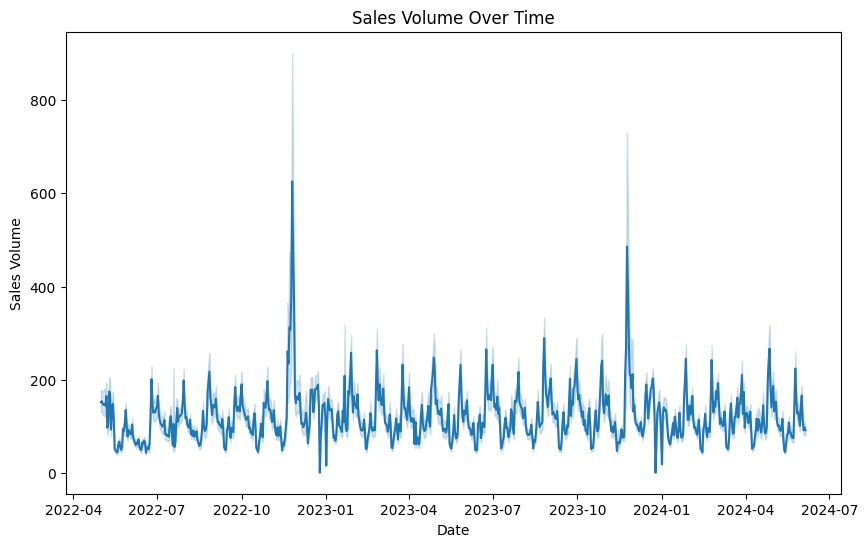

In [5]:
# Plot total sales volume (aggregate over product) over time
plt.figure(figsize=(10, 6))
sns.lineplot(x='sales_date', y='volume', data=df)
plt.title('Sales Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.show()

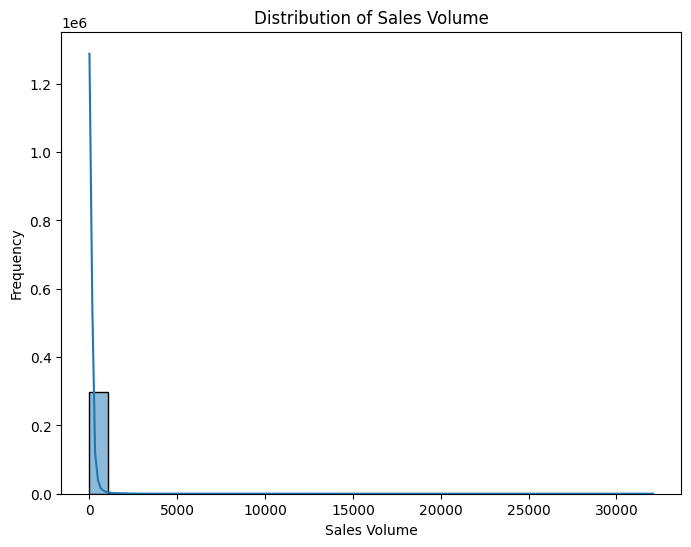

/home/ryan/Workspace/personal/isazi-hackathon-indabaX/hackathon-venv/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


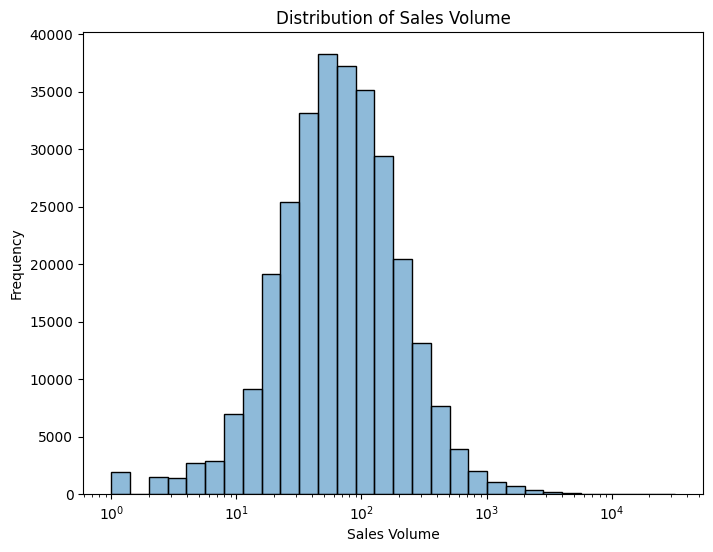

In [6]:
# Distribution of sales volume
plt.figure(figsize=(8, 6))
sns.histplot(df['volume'], bins=30, kde=True)
plt.title('Distribution of Sales Volume')
plt.xlabel('Sales Volume')
plt.ylabel('Frequency')
plt.show()

# Distribution of log of the sales volume
plt.figure(figsize=(8, 6))
sns.histplot(df['volume'], bins=30, kde=True, log_scale = True)
plt.title('Distribution of Sales Volume')
plt.xlabel('Sales Volume')
plt.ylabel('Frequency')
plt.show()

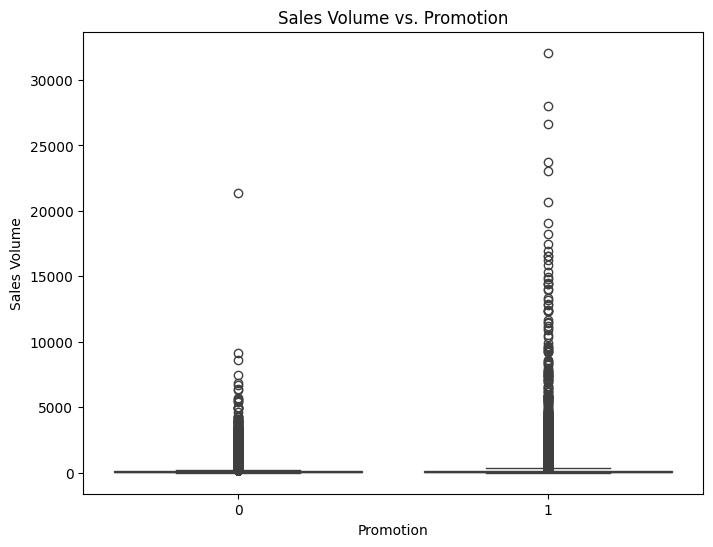

Average sales volume by promotion:
is_promo
0     96.271113
1    143.403851
Name: volume, dtype: float64


In [7]:
# Sales volume vs. promotion
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_promo', y='volume', data=df)
plt.title('Sales Volume vs. Promotion')
plt.xlabel('Promotion')
plt.ylabel('Sales Volume')
plt.show()

# Average sales volume by promotion
print("Average sales volume by promotion:")
print(df.groupby('is_promo')['volume'].mean())


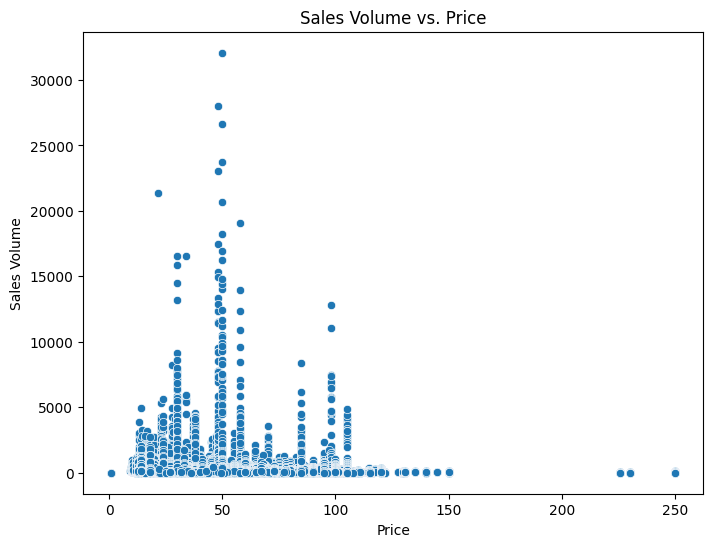

Correlation between price and sales volume:
             rsp    volume
rsp     1.000000 -0.120048
volume -0.120048  1.000000


In [8]:
# Sales volume vs. price
plt.figure(figsize=(8, 6))
sns.scatterplot(x='rsp', y='volume', data=df)
plt.title('Sales Volume vs. Price')
plt.xlabel('Price')
plt.ylabel('Sales Volume')
plt.show()

# Correlation between price and sales volume
print("Correlation between price and sales volume:")
print(df[['rsp', 'volume']].corr())


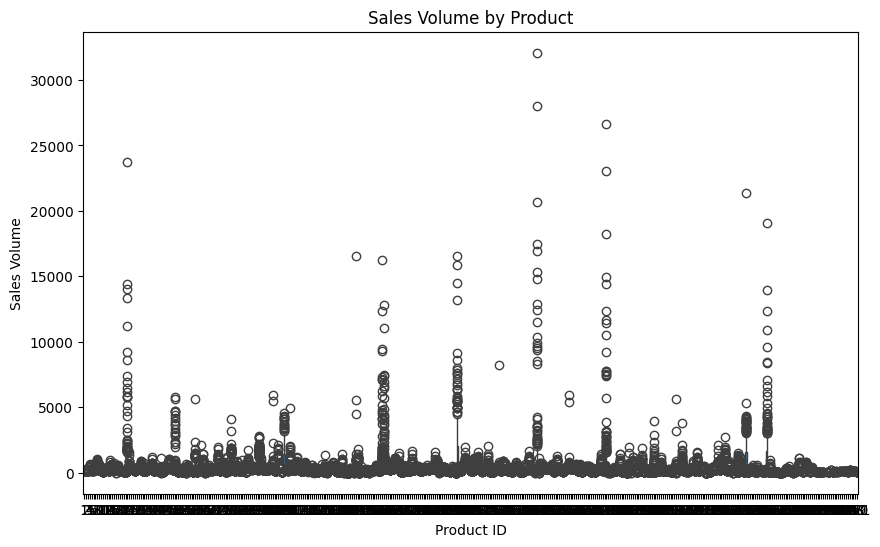

Average sales volume by product:
product_code
1       76.757497
2       64.371578
3       56.235984
4      171.852673
5       66.667536
          ...    
407     82.383764
408     58.664207
409     44.660517
410     59.051661
411     20.435424
Name: volume, Length: 411, dtype: float64


In [9]:
# Sales volume by product
plt.figure(figsize=(10, 6))
sns.boxplot(x='product_code', y='volume', data=df)
plt.title('Sales Volume by Product')
plt.xlabel('Product ID')
plt.ylabel('Sales Volume')
plt.show()

# Average sales volume by product
print("Average sales volume by product:")
print(df.groupby('product_code')['volume'].mean())


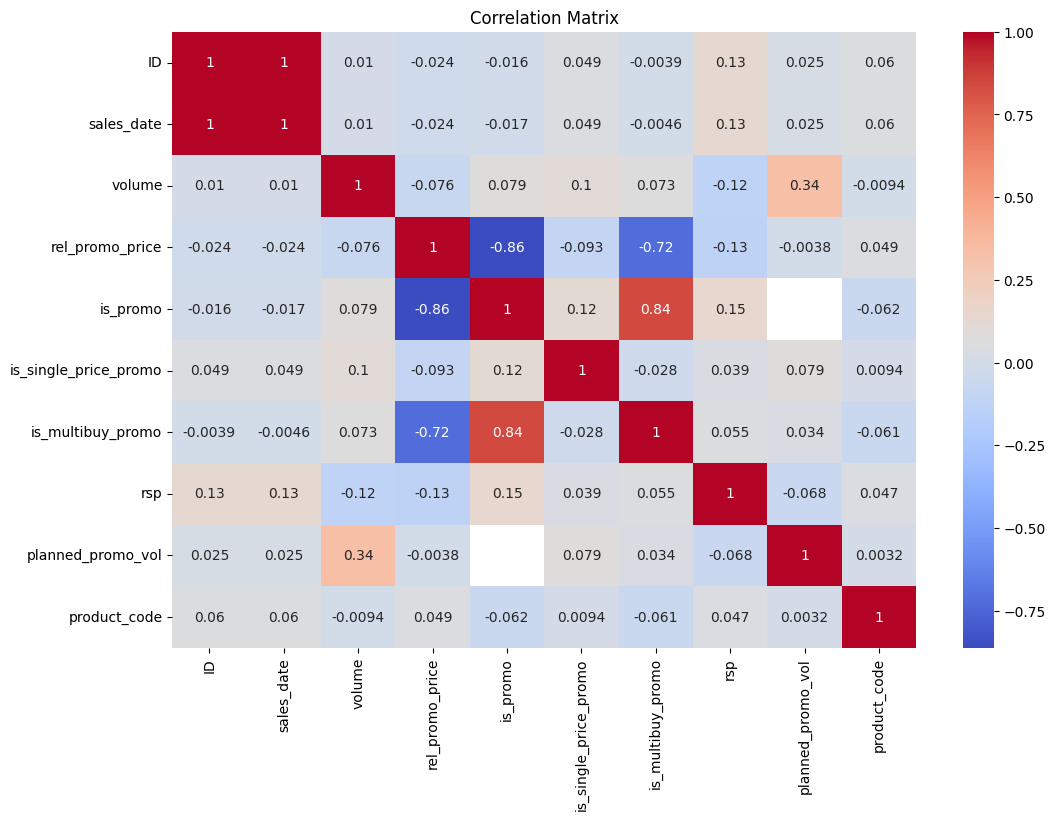

In [10]:
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## 5. Feature Engineering
********************************
Feature engineering involves creating new features or modifying existing ones to improve the model's performance.


In [11]:
# Extract additional time features
df['year'] = df['sales_date'].dt.year
df['month'] = df['sales_date'].dt.month
df['day'] = df['sales_date'].dt.day
df['dayofweek'] = df['sales_date'].dt.dayofweek

# Create date diff string
sales_starting_date = df['sales_date'].iloc[0]
df['date_diff'] = (df['sales_date'] - sales_starting_date) / np.timedelta64(1, 'D') # Basically a column that tells you what day you are at relative to the start

# Fill nans in planned_promo_vol
df.fillna(0, inplace = True) # Replace any NaNs with 0

df

,ID,sales_date,volume,rel_promo_price,is_promo,is_single_price_promo,is_multibuy_promo,rsp,planned_promo_vol,product_code,year,month,day,dayofweek,date_diff
0,0,2022-05-01,61.0,1.0000,0,0,0,32.9500,0.0000,1,2022,5,1,6,0.0
1,1,2022-05-01,102.0,1.0000,0,0,0,40.1204,0.0000,2,2022,5,1,6,0.0
2,2,2022-05-01,52.0,1.0000,0,0,0,32.7825,0.0000,3,2022,5,1,6,0.0
3,3,2022-05-01,309.0,0.9091,1,0,0,41.3318,0.0001,4,2022,5,1,6,0.0
4,4,2022-05-01,106.0,0.9091,1,0,0,44.6441,0.0001,5,2022,5,1,6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300763,300763,2024-06-05,63.0,0.8333,1,0,1,77.9900,107.7537,156,2024,6,5,2,766.0
300764,300764,2024-06-05,26.0,1.0000,0,0,0,77.4567,0.0000,147,2024,6,5,2,766.0
300765,300765,2024-06-05,71.0,1.0000,0,0,0,18.0111,0.0000,85,2024,6,5,2,766.0
300766,300766,2024-06-05,0.0,1.0000,0,0,0,35.9900,0.0000,98,2024,6,5,2,766.0


## 6. Data Preparation
********************************

#### 6.1 Split into Train and Test Set

In [12]:
def split_time_series(df, prediction_length):
    """
    Function to split off a df of time series into time series, where the second time series
    includes the last `prediction_length` time steps.
    """
    # Create an empty dataframe for train and validation sets
    train_df = pd.DataFrame()
    validation_df = pd.DataFrame()

    # Group by the time series identifier
    grouped = df.groupby(time_series_id_col)

    # Iterate over each group (i.e., each individual time series)
    for item_id, group in grouped:
        # Sort the group by date if it's not already sorted
        group = group.sort_index()

        # Define the split point
        split_point = len(group) - prediction_length

        # Split the data into training and validation sets
        train_group = group.iloc[:split_point]
        validation_group = group

        # Append to the respective dataframes
        train_df = pd.concat([train_df, train_group])
        validation_df = pd.concat([validation_df, validation_group])

    return train_df, validation_df

train_df, test_df = split_time_series(df, prediction_length)

In [13]:
train_df

,ID,sales_date,volume,rel_promo_price,is_promo,is_single_price_promo,is_multibuy_promo,rsp,planned_promo_vol,product_code,year,month,day,dayofweek,date_diff
0,0,2022-05-01,61.0,1.0,0,0,0,32.9500,0.0,1,2022,5,1,6,0.0
599,599,2022-05-02,61.0,1.0,0,0,0,32.9500,0.0,1,2022,5,2,0,1.0
843,843,2022-05-03,60.0,1.0,0,0,0,32.9500,0.0,1,2022,5,3,1,2.0
1409,1409,2022-05-04,61.0,1.0,0,0,0,32.9656,0.0,1,2022,5,4,2,3.0
1485,1485,2022-05-05,49.0,1.0,0,0,0,32.9656,0.0,1,2022,5,5,3,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287531,287531,2024-05-04,15.0,1.0,0,0,0,16.0679,0.0,411,2024,5,4,5,734.0
287796,287796,2024-05-05,10.0,1.0,0,0,0,16.0679,0.0,411,2024,5,5,6,735.0
288185,288185,2024-05-06,12.0,1.0,0,0,0,16.0679,0.0,411,2024,5,6,0,736.0
288598,288598,2024-05-07,14.0,1.0,0,0,0,16.0679,0.0,411,2024,5,7,1,737.0


In [14]:
test_df

,ID,sales_date,volume,rel_promo_price,is_promo,is_single_price_promo,is_multibuy_promo,rsp,planned_promo_vol,product_code,year,month,day,dayofweek,date_diff
0,0,2022-05-01,61.0,1.0,0,0,0,32.9500,0.0,1,2022,5,1,6,0.0
599,599,2022-05-02,61.0,1.0,0,0,0,32.9500,0.0,1,2022,5,2,0,1.0
843,843,2022-05-03,60.0,1.0,0,0,0,32.9500,0.0,1,2022,5,3,1,2.0
1409,1409,2022-05-04,61.0,1.0,0,0,0,32.9656,0.0,1,2022,5,4,2,3.0
1485,1485,2022-05-05,49.0,1.0,0,0,0,32.9656,0.0,1,2022,5,5,3,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299032,299032,2024-06-01,15.0,1.0,0,0,0,16.0679,0.0,411,2024,6,1,5,762.0
299331,299331,2024-06-02,7.0,1.0,0,0,0,16.0679,0.0,411,2024,6,2,6,763.0
299673,299673,2024-06-03,13.0,1.0,0,0,0,16.0679,0.0,411,2024,6,3,0,764.0
300005,300005,2024-06-04,6.0,1.0,0,0,0,16.0679,0.0,411,2024,6,4,1,765.0


#### 6.2. Scaling and Normalization

In [15]:
# Encode categorical variables (if any)
# For simplicity, we'll use one-hot encoding
# df_hot_encoded = pd.get_dummies(df, columns=['product_code'], drop_first=True)

# Scale numerical features
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[['rel_promo_price', 'rsp', 'planned_promo_vol']] = scaler.fit_transform(df[['rel_promo_price', 'rsp', 'planned_promo_vol']])
df_scaled

# Recompute the training and evaluation datasets
train_df, test_df = split_time_series(df_scaled, prediction_length)

#### 6.3. Helper functions

In [16]:
def compute_error(actuals_path, preds_path):
    """
    Computes the relative error and relative bias from csv files of predictions and actual targets.
    """
    # Read predicted and actuals from their respective files if not already provided
    actuals_df = pd.read_csv(actuals_path, parse_dates=[date_col])
    preds_df = pd.read_csv(preds_path, parse_dates=[date_col])

    # Rename 'target' column to add suffix for 'preds' and 'actuals' respectively
    actuals_df.rename(columns={target_col: f'{target_col}_actuals'}, inplace=True)
    preds_df.rename(columns={target_col: f'{target_col}_preds'}, inplace=True)

    # Merge the two dataframes on the timestamp column and the time series identifier column
    df = pd.merge(actuals_df, preds_df, on=[date_col, time_series_id_col])

    actual_var = target_col + '_actuals'
    pred_var = target_col +'_preds'
    measure_level = [time_series_id_col, date_col]

    # Drop all unecessary columns
    keep_vars = list(set(measure_level + [actual_var, pred_var]))
    df_filtered = df.dropna(subset=[actual_var])[keep_vars]
    df_filtered.rename(columns={actual_var: 'A', pred_var: 'P'}, inplace=True)

    # Group by measure_level and aggregate A and P
    grouped = df_filtered.groupby(measure_level, observed=False).agg(A=('A', 'sum'), P=('P', 'sum'))

    # Calculate the errors initially at measure_level (not the absolute sum yet)
    grouped['E'] = (grouped['A'] - grouped['P']).abs()

    # Aggregate all data to one row
    grouped = grouped.sum()

    # Calculate relative error (rE) and relative bias (rB)
    grouped['rE'] = grouped['E'] / grouped['A']
    grouped['rB'] = (grouped['P'] - grouped['A']) / grouped['A']
    return grouped

## 7. Model Development
********************************

In [39]:
import pmdarima as pm
from tqdm import tqdm

def create_arima_models(df):
    eps = 1e-6
    
    # Compute means for each group (just because)
    mean_df = df.groupby('product_code').agg(volume_mean_per_code=('volume', 'mean'))

    # Get the number of product codes
    num_product_codes = len(mean_df) # possible because group by product code
    product_codes = mean_df.index.to_numpy()

    # Define the model dict
    model_dict = {}
    
    # Iterate and optimise
    for i in tqdm(range(num_product_codes)):
        product_index = product_codes[i]
        
        # Process the training data
        sliced_df = df[df['product_code']==product_index]
        volume_train = sliced_df['volume'].to_numpy()

        # Optimise
        model_init_iter = pm.auto_arima(
            volume_train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5,
                      seasonal=True, m=12) 

        # Store
        model_dict[f"{product_index}"] = model_init_iter

    return model_dict

def make_predictions(model_dict, df, prediction_length):

    num_product_codes = len(set(df['product_code'])) # possible because group by product code
    
    predicted_volume = np.array([])

    # Get the sorted data by date and then by product code (so that we can extract the period to extract over
    sliced_df = df.sort_values(by=['sales_date', 'product_code'], ascending=[True, True]).iloc[-num_product_codes*prediction_length:]

    # Re-arrange so that its all of the sales for a given product code
    eval_df = sliced_df.sort_values(by=['product_code', 'sales_date'], ascending=[True, True])
    
    for i in tqdm(range(num_product_codes)):

        row_data = eval_df.iloc[i]

        product_code = row_data['product_code']
        
        opt_model = model_dict[f"{product_code}"]
        
        prediction = opt_model.predict(prediction_length)

        print(len(prediction))
        
        predicted_volume = np.concatenate((predicted_volume, prediction))

    # Create the prediction dict
    pred_dict = {
        'sales_date': eval_df['sales_date'].values,
        'product_code': eval_df['product_code'].values,
        'volume': predicted_volume
    }

    # Create the prediction dataframe
    pred_df = pd.DataFrame(pred_dict)

    # Sort by product code and then by sales_date
    pred_df.sort_values(by=['product_code', 'sales_date'], ascending=[True, True], inplace = True)

    return pred_df

In [40]:
ARIMA_opt = create_arima_models(train_df)

  0%|                                                                                                                                                                                                                                       | 0/411 [00:00<?, ?it/s]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6648.006, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6802.252, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6757.752, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6715.405, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6800.254, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6643.548, Time=0.38 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6661.971, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6647.828, Time=0.86 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6645.033, Time=0.26 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=6651.344, Time=0.84 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=6641.878, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=6659.105, Time=0.07 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=6648.557, Time=0.31 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=6642.962, Time=0.68 sec
 ARIMA(1,1,2)(1,0,0

  0%|▌                                                                                                                                                                                                                            | 1/411 [00:12<1:23:45, 12.26s/it]

 ARIMA(2,1,2)(0,0,1)[12]             : AIC=6641.368, Time=0.22 sec

Best model:  ARIMA(1,1,1)(0,0,1)[12]          
Total fit time: 12.252 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6810.531, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7323.459, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6709.841, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6972.815, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8422.884, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6717.338, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6714.314, Time=0.46 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6742.106, Time=0.30 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6707.581, Time=0.24 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6706.949, Time=0.79 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=6742.842, Time=0.72 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=7321.684, Time=0.50 sec
 ARIMA(

  0%|█                                                                                                                                                                                                                            | 2/411 [00:22<1:15:11, 11.03s/it]

 ARIMA(2,0,0)(0,0,2)[12]             : AIC=6773.031, Time=0.53 sec

Best model:  ARIMA(2,0,0)(0,0,2)[12] intercept
Total fit time: 10.167 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6491.106, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7154.841, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6499.272, Time=0.22 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6840.895, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8240.625, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=6467.716, Time=0.56 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=6466.741, Time=0.09 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=6472.611, Time=0.37 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=6469.205, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=6472.656, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[12] intercept   : AIC=6467.336, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[12] intercept   : AIC=6529.823, Time=0.06 sec
 ARIMA(

  1%|█▋                                                                                                                                                                                                                             | 3/411 [00:25<49:36,  7.29s/it]

 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=6468.730, Time=0.06 sec
 ARIMA(3,0,3)(0,0,0)[12] intercept   : AIC=6472.756, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[12]             : AIC=6492.815, Time=0.03 sec

Best model:  ARIMA(2,0,2)(0,0,0)[12] intercept
Total fit time: 2.842 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=8113.496, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8924.328, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=8095.558, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8530.263, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9917.350, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=8106.771, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=8097.493, Time=0.86 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=8099.312, Time=0.25 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=8094.905, Time=0.27 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=8096.901, Time=0.56 sec
 ARIMA(1

  1%|██▏                                                                                                                                                                                                                            | 4/411 [00:30<44:11,  6.51s/it]

 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=8109.159, Time=0.31 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=8146.905, Time=0.19 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 5.314 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6781.723, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7514.717, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6731.580, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7092.877, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8510.240, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6741.557, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6734.394, Time=0.40 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6732.093, Time=0.24 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6729.596, Time=0.20 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6730.999, Time=0.65 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=6753.124, Time=0.65 sec
 ARIMA(0

  1%|██▋                                                                                                                                                                                                                          | 5/411 [00:45<1:05:39,  9.70s/it]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7350.487, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7399.655, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7385.652, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7383.159, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7397.659, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7342.973, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7353.627, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7342.735, Time=0.69 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7342.313, Time=0.82 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=7344.194, Time=0.93 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=7343.902, Time=0.79 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=7364.633, Time=1.04 sec
 ARIMA(2,1,1)(1,0,2)[12] intercept   : AIC=7329.146, Time=1.23 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=7329.171, Time=0.82 sec
 ARIMA(2,1,1)(1,0,1

  1%|███▏                                                                                                                                                                                                                         | 6/411 [01:01<1:17:53, 11.54s/it]

 ARIMA(3,1,2)(0,0,1)[12]             : AIC=7330.235, Time=0.24 sec

Best model:  ARIMA(2,1,1)(0,0,1)[12]          
Total fit time: 15.095 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7133.506, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7761.280, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7080.089, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7440.762, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8866.502, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7079.924, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=7079.988, Time=0.23 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7117.420, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=7069.761, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=7068.398, Time=0.17 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=7074.013, Time=0.74 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=7085.045, Time=0.40 sec
 ARIMA(

  2%|███▊                                                                                                                                                                                                                         | 7/411 [01:06<1:04:48,  9.62s/it]

 ARIMA(3,0,1)(0,0,1)[12] intercept   : AIC=7073.205, Time=0.30 sec
 ARIMA(2,0,0)(0,0,1)[12]             : AIC=7117.155, Time=0.18 sec

Best model:  ARIMA(2,0,0)(0,0,1)[12] intercept
Total fit time: 5.677 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8799.700, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8869.592, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8840.656, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8833.933, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8867.593, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=8782.600, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=8810.672, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=8781.129, Time=0.87 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=8780.171, Time=0.97 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=8782.205, Time=1.09 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=8779.851, Time=0.86 sec
 ARIMA(2

  2%|████▎                                                                                                                                                                                                                        | 8/411 [01:27<1:27:42, 13.06s/it]

 ARIMA(1,1,5)(2,0,0)[12]             : AIC=8756.687, Time=0.40 sec

Best model:  ARIMA(0,1,4)(2,0,0)[12]          
Total fit time: 20.402 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8029.159, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8098.625, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8088.397, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8081.692, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8096.626, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=8018.582, Time=0.45 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=8021.271, Time=1.02 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=8013.624, Time=0.29 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=8020.833, Time=1.35 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=8027.289, Time=1.28 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=8029.831, Time=0.23 sec
 ARIMA(2,1,1

  2%|████▊                                                                                                                                                                                                                        | 9/411 [01:38<1:24:14, 12.57s/it]

 ARIMA(3,1,3)(1,0,0)[12]             : AIC=8033.213, Time=0.17 sec

Best model:  ARIMA(2,1,2)(1,0,0)[12]          
Total fit time: 11.499 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6558.629, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6679.649, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6627.066, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6597.830, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6677.649, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6553.324, Time=0.53 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6578.089, Time=0.10 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6554.227, Time=1.35 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6552.782, Time=0.41 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=6554.032, Time=1.30 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=6555.666, Time=1.27 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=6549.542, Time=0.22 sec
 ARIMA(

  2%|█████▎                                                                                                                                                                                                                      | 10/411 [02:01<1:46:11, 15.89s/it]

 ARIMA(3,1,2)(0,0,1)[12]             : AIC=6545.317, Time=0.26 sec

Best model:  ARIMA(2,1,1)(0,0,1)[12]          
Total fit time: 23.307 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5591.416, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5693.336, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5643.985, Time=0.19 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5607.472, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5691.350, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=5589.783, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=5590.426, Time=0.10 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=5585.371, Time=0.81 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=5586.862, Time=0.95 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=5582.403, Time=0.92 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=5587.018, Time=0.37 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=5584.116, Time=0.99 sec
 ARIMA(

  3%|█████▉                                                                                                                                                                                                                      | 11/411 [02:18<1:47:32, 16.13s/it]

 ARIMA(1,1,3)(0,0,2)[12]             : AIC=5580.740, Time=1.00 sec

Best model:  ARIMA(0,1,2)(0,0,2)[12]          
Total fit time: 16.676 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7379.553, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7452.794, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7443.056, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7438.017, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7450.794, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7373.029, Time=0.38 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7382.117, Time=0.10 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7369.677, Time=0.84 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7367.999, Time=1.45 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=7381.234, Time=1.18 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=7369.852, Time=1.31 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=7356.569, Time=0.92 sec
 ARIMA(

  3%|██████▍                                                                                                                                                                                                                     | 12/411 [02:40<1:59:42, 18.00s/it]

 ARIMA(1,1,4)(0,0,2)[12]             : AIC=7355.286, Time=0.81 sec

Best model:  ARIMA(0,1,3)(0,0,2)[12]          
Total fit time: 22.270 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7214.078, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7810.185, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7150.956, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7447.824, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8880.123, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7171.881, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7160.707, Time=0.49 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7188.464, Time=0.28 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=7147.694, Time=0.23 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=7148.969, Time=0.51 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=7184.430, Time=0.97 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=7811.694, Time=0.24 sec
 ARIMA(

  3%|██████▉                                                                                                                                                                                                                     | 13/411 [03:06<2:14:55, 20.34s/it]

 ARIMA(1,0,5)(0,0,1)[12]             : AIC=7133.022, Time=0.36 sec

Best model:  ARIMA(1,0,5)(0,0,1)[12] intercept
Total fit time: 25.708 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6659.193, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7128.200, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6603.732, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6783.419, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8190.020, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6610.958, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6604.572, Time=0.41 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6684.466, Time=0.33 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6601.414, Time=0.24 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6596.286, Time=0.54 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=6744.756, Time=0.69 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=7082.647, Time=0.52 sec
 ARIMA(

  3%|███████▍                                                                                                                                                                                                                    | 14/411 [03:13<1:48:21, 16.38s/it]

 ARIMA(1,0,0)(0,0,2)[12]             : AIC=6689.879, Time=0.42 sec

Best model:  ARIMA(1,0,0)(0,0,2)[12] intercept
Total fit time: 7.214 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8027.652, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8103.856, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8101.191, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8100.792, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8101.858, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=8022.580, Time=0.71 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=8021.621, Time=0.12 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=8022.117, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=8017.998, Time=0.09 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=8014.950, Time=0.20 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=8016.443, Time=0.84 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=8018.778, Time=0.52 sec
 ARIMA(1

  4%|████████                                                                                                                                                                                                                    | 15/411 [03:27<1:42:06, 15.47s/it]

 ARIMA(2,1,3)(0,0,1)[12]             : AIC=8038.289, Time=0.28 sec

Best model:  ARIMA(1,1,2)(0,0,1)[12]          
Total fit time: 13.365 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=8284.419, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9216.119, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=8271.724, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8814.755, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10026.268, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=8270.580, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=8271.676, Time=0.22 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=8288.116, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=8271.449, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=8271.286, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=8815.933, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=8274.987, Time=0.05 sec


  4%|████████▌                                                                                                                                                                                                                   | 16/411 [03:28<1:14:26, 11.31s/it]

 ARIMA(1,0,0)(0,0,0)[12]             : AIC=8309.253, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.633 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7481.950, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7539.430, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7541.668, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7541.374, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7537.434, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7478.684, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7476.873, Time=0.09 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7477.412, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=7464.185, Time=0.08 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=7465.740, Time=0.19 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7465.638, Time=0.35 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=7467.918, Time=0.38 sec
 ARIMA(0

  4%|█████████▏                                                                                                                                                                                                                    | 17/411 [03:32<59:57,  9.13s/it]

 ARIMA(0,1,3)(0,0,0)[12]             : AIC=7500.324, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[12]             : AIC=7524.808, Time=0.03 sec
 ARIMA(2,1,3)(0,0,0)[12]             : AIC=7491.895, Time=0.04 sec

Best model:  ARIMA(1,1,2)(0,0,0)[12]          
Total fit time: 4.064 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7526.806, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7517.592, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7491.707, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7473.682, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7515.594, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=7511.577, Time=0.07 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=7490.223, Time=0.28 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=7459.739, Time=0.63 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=7448.600, Time=0.72 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=7428.536, Time=0.85 sec
 ARIMA(0

  4%|█████████▋                                                                                                                                                                                                                  | 18/411 [04:01<1:37:26, 14.88s/it]

 ARIMA(2,1,3)(1,0,2)[12]             : AIC=7340.851, Time=0.76 sec

Best model:  ARIMA(1,1,2)(1,0,2)[12]          
Total fit time: 28.246 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7872.793, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7926.961, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7911.735, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7907.241, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7924.973, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7863.548, Time=0.36 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7879.304, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7862.869, Time=0.72 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7863.455, Time=1.24 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=7867.764, Time=0.99 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=7855.477, Time=0.92 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=7855.334, Time=0.37 sec
 ARIMA(

  5%|██████████▏                                                                                                                                                                                                                 | 19/411 [04:14<1:33:37, 14.33s/it]

 ARIMA(3,1,2)(0,0,1)[12]             : AIC=7867.923, Time=0.40 sec

Best model:  ARIMA(2,1,1)(0,0,1)[12]          
Total fit time: 13.045 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6565.507, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7336.206, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6552.837, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6942.472, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8079.881, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6550.784, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6552.777, Time=0.22 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6557.135, Time=0.28 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=6543.013, Time=0.08 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=6545.958, Time=0.17 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=6544.909, Time=0.26 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=6553.480, Time=0.25 sec
 ARIMA(

  5%|██████████▋                                                                                                                                                                                                                 | 20/411 [04:19<1:15:13, 11.54s/it]

 ARIMA(5,0,1)(0,0,0)[12] intercept   : AIC=6522.560, Time=0.08 sec
 ARIMA(4,0,0)(0,0,0)[12]             : AIC=6535.974, Time=0.04 sec

Best model:  ARIMA(4,0,0)(0,0,0)[12] intercept
Total fit time: 5.048 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6334.195, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6925.165, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6325.520, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6535.072, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7982.048, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6330.908, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6331.030, Time=0.64 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6365.572, Time=0.37 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6323.962, Time=0.24 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6323.482, Time=0.54 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=6348.139, Time=0.66 sec
 ARIMA(0

  5%|███████████▏                                                                                                                                                                                                                | 21/411 [04:26<1:06:34, 10.24s/it]

 ARIMA(1,0,0)(0,0,2)[12]             : AIC=6404.413, Time=0.46 sec

Best model:  ARIMA(1,0,0)(0,0,2)[12] intercept
Total fit time: 7.204 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6621.331, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6070.189, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5889.879, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5870.021, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7517.061, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=5882.481, Time=0.05 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=10290.276, Time=0.27 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=5870.771, Time=0.63 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=5898.335, Time=0.19 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=6050.070, Time=0.24 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=5837.082, Time=0.29 sec
 ARIMA(1,0,1

  5%|███████████▊                                                                                                                                                                                                                | 22/411 [04:35<1:04:48, 10.00s/it]

 ARIMA(3,0,1)(0,0,1)[12] intercept   : AIC=5845.171, Time=0.34 sec
 ARIMA(2,0,0)(0,0,1)[12]             : AIC=6011.792, Time=0.19 sec

Best model:  ARIMA(2,0,0)(0,0,1)[12] intercept
Total fit time: 9.413 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6032.404, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6479.308, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6007.207, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6203.856, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7528.073, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6009.330, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6005.749, Time=0.63 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=6150.194, Time=0.80 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6052.693, Time=0.29 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=6467.051, Time=0.36 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=6080.093, Time=0.65 sec
 ARIMA(1

  6%|████████████▍                                                                                                                                                                                                                 | 23/411 [04:41<56:16,  8.70s/it]

 ARIMA(1,0,0)(2,0,0)[12]             : AIC=6108.995, Time=0.26 sec

Best model:  ARIMA(1,0,0)(2,0,0)[12] intercept
Total fit time: 5.680 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=11878.927, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=12962.764, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=11990.738, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=12531.501, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=13075.129, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=11877.642, Time=0.38 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=11875.815, Time=0.09 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=11877.984, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=11873.699, Time=0.08 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=11876.448, Time=0.19 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=11876.319, Time=0.68 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=11877.389, Time=1.03 

  6%|████████████▉                                                                                                                                                                                                                 | 24/411 [04:49<55:04,  8.54s/it]

 ARIMA(4,0,4)(0,0,0)[12] intercept   : AIC=11871.373, Time=0.10 sec
 ARIMA(3,0,3)(0,0,0)[12]             : AIC=11875.689, Time=0.04 sec

Best model:  ARIMA(3,0,3)(0,0,0)[12] intercept
Total fit time: 8.154 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8754.455, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8978.848, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8839.605, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8746.808, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8976.848, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=8757.807, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=8748.462, Time=0.31 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=8740.925, Time=0.69 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=8740.169, Time=0.71 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=8742.036, Time=0.90 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=8739.735, Time=1.04 sec
 ARIMA

  6%|█████████████▍                                                                                                                                                                                                              | 25/411 [05:10<1:18:00, 12.13s/it]

 ARIMA(1,1,4)(2,0,0)[12]             : AIC=8732.633, Time=0.43 sec

Best model:  ARIMA(0,1,3)(2,0,0)[12]          
Total fit time: 20.484 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7652.157, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7727.137, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7709.867, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7705.656, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7725.137, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7645.080, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7662.412, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7643.651, Time=0.81 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7645.893, Time=0.95 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=7629.216, Time=0.78 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7630.553, Time=0.32 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=7631.676, Time=0.89 sec
 ARIMA(

  6%|█████████████▉                                                                                                                                                                                                              | 26/411 [05:37<1:46:14, 16.56s/it]

 ARIMA(1,1,5)(0,0,2)[12]             : AIC=7617.152, Time=0.74 sec

Best model:  ARIMA(0,1,4)(0,0,2)[12]          
Total fit time: 26.878 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7408.829, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7480.045, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7470.663, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7467.564, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7478.045, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7404.187, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7412.271, Time=0.06 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7406.427, Time=0.76 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7407.750, Time=0.25 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7392.518, Time=0.79 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=7411.610, Time=0.91 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=7396.859, Time=0.84 sec
 ARIMA(

  7%|██████████████▍                                                                                                                                                                                                             | 27/411 [05:51<1:42:25, 16.00s/it]

 ARIMA(3,1,2)(0,0,1)[12]             : AIC=7392.602, Time=0.21 sec

Best model:  ARIMA(2,1,1)(0,0,1)[12]          
Total fit time: 14.700 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6238.832, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6309.425, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6286.346, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6271.801, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6307.426, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6234.855, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6235.642, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6231.355, Time=0.78 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=6234.226, Time=1.06 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=6228.873, Time=0.75 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=6231.543, Time=0.33 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=6231.505, Time=0.76 sec
 ARIMA(

  7%|██████████████▉                                                                                                                                                                                                             | 28/411 [06:08<1:42:49, 16.11s/it]

 ARIMA(2,1,2)(0,0,2)[12]             : AIC=6229.423, Time=0.46 sec

Best model:  ARIMA(1,1,1)(0,0,2)[12]          
Total fit time: 16.352 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7434.928, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7415.403, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7406.320, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7400.905, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7413.403, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=7406.293, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=7406.174, Time=0.30 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=7394.489, Time=0.63 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=7395.901, Time=0.70 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=7407.010, Time=0.66 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=7392.035, Time=0.68 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=7397.950, Time=0.32 sec
 ARIMA(

  7%|███████████████▌                                                                                                                                                                                                            | 29/411 [06:29<1:52:56, 17.74s/it]

 ARIMA(1,1,4)(0,0,2)[12]             : AIC=7361.178, Time=0.72 sec

Best model:  ARIMA(0,1,3)(0,0,2)[12]          
Total fit time: 21.534 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7609.338, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7598.671, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7593.410, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7607.345, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=7605.771, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=7602.513, Time=0.28 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=7593.522, Time=0.62 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=7595.505, Time=0.15 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=7592.621, Time=0.74 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=7591.551, Time=0.96 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=7591.205, Time=0.58 sec
 ARIMA(0,1,1

  7%|████████████████                                                                                                                                                                                                            | 30/411 [06:50<1:58:16, 18.63s/it]

 ARIMA(3,1,2)(2,0,0)[12]             : AIC=7536.533, Time=0.30 sec

Best model:  ARIMA(2,1,1)(2,0,0)[12]          
Total fit time: 20.684 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8599.239, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8685.282, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8674.191, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8669.115, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8683.288, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=8594.592, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=8606.342, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=8596.122, Time=0.98 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=8595.304, Time=0.27 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=8597.219, Time=0.89 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=8591.685, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=8603.937, Time=0.08 sec
 ARIMA(

  8%|████████████████▌                                                                                                                                                                                                           | 31/411 [07:08<1:56:08, 18.34s/it]

 ARIMA(1,1,4)(0,0,1)[12]             : AIC=8590.855, Time=0.41 sec

Best model:  ARIMA(0,1,3)(0,0,1)[12]          
Total fit time: 17.659 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6806.011, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7352.640, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6729.326, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6956.100, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8328.608, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6737.979, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6725.799, Time=0.40 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=6789.081, Time=0.84 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6749.805, Time=0.25 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=7361.315, Time=0.30 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=6726.345, Time=0.52 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=6750.112, Time=0.81 sec
 ARIMA(

  8%|█████████████████▏                                                                                                                                                                                                          | 32/411 [07:13<1:30:44, 14.37s/it]

 ARIMA(1,0,0)(2,0,0)[12]             : AIC=6809.332, Time=0.22 sec

Best model:  ARIMA(1,0,0)(2,0,0)[12] intercept
Total fit time: 5.091 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7748.781, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8740.155, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7733.576, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8305.624, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9368.588, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7734.328, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7732.232, Time=0.47 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=7742.588, Time=0.70 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7740.909, Time=0.28 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=8713.534, Time=0.30 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=7734.535, Time=0.69 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=7738.482, Time=0.53 sec
 ARIMA(0

  8%|█████████████████▋                                                                                                                                                                                                          | 33/411 [07:18<1:12:48, 11.56s/it]

 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=7763.054, Time=0.50 sec
 ARIMA(1,0,0)(2,0,0)[12]             : AIC=7765.166, Time=0.18 sec

Best model:  ARIMA(1,0,0)(2,0,0)[12] intercept
Total fit time: 4.998 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6662.266, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7379.115, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6616.582, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6948.823, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8138.984, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6641.291, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6621.066, Time=0.55 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6619.116, Time=0.25 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6615.243, Time=0.24 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6617.196, Time=0.59 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=6634.274, Time=0.62 sec
 ARIMA(0

  8%|██████████████████▏                                                                                                                                                                                                         | 34/411 [07:36<1:25:08, 13.55s/it]

 ARIMA(4,0,1)(1,0,0)[12] intercept   : AIC=6595.859, Time=0.35 sec
 ARIMA(5,0,0)(1,0,0)[12]             : AIC=6587.592, Time=0.19 sec

Best model:  ARIMA(5,0,0)(1,0,0)[12] intercept
Total fit time: 18.195 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7161.108, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7197.201, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7195.443, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7194.423, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7195.201, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7157.734, Time=0.40 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7157.640, Time=0.10 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7157.870, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=7153.869, Time=0.07 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=7152.737, Time=0.18 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=7150.454, Time=0.62 sec
 ARIMA(

  9%|██████████████████▋                                                                                                                                                                                                         | 35/411 [07:51<1:28:35, 14.14s/it]

 ARIMA(1,1,4)(2,0,0)[12]             : AIC=7142.428, Time=0.52 sec

Best model:  ARIMA(0,1,3)(2,0,0)[12]          
Total fit time: 15.493 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7752.501, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7814.596, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7783.195, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7782.020, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7812.599, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7728.024, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7744.911, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7732.280, Time=0.79 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7729.508, Time=0.27 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7742.836, Time=0.88 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7701.780, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=7736.204, Time=0.08 sec
 ARIMA(

  9%|███████████████████▎                                                                                                                                                                                                        | 36/411 [08:10<1:36:18, 15.41s/it]

 ARIMA(1,1,4)(0,0,1)[12]             : AIC=7693.988, Time=0.36 sec

Best model:  ARIMA(0,1,3)(0,0,1)[12]          
Total fit time: 18.362 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=8632.073, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9312.968, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=8609.371, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8917.346, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10411.920, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=8620.650, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=8610.985, Time=0.46 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=8629.996, Time=0.26 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=8606.775, Time=0.22 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=8607.887, Time=0.66 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=8635.664, Time=0.80 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=9301.447, Time=0.22 sec
 ARIMA

  9%|███████████████████▊                                                                                                                                                                                                        | 37/411 [08:26<1:37:43, 15.68s/it]

 ARIMA(5,0,0)(0,0,1)[12]             : AIC=8638.031, Time=0.24 sec

Best model:  ARIMA(5,0,0)(0,0,1)[12] intercept
Total fit time: 16.297 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6564.336, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6659.005, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6620.853, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6590.810, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6657.007, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6561.014, Time=0.39 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6560.785, Time=0.09 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6561.160, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=6559.189, Time=0.08 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=6557.987, Time=0.19 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=6559.158, Time=0.56 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=6560.473, Time=0.41 sec
 ARIMA(

  9%|████████████████████▎                                                                                                                                                                                                       | 38/411 [08:38<1:31:00, 14.64s/it]

 ARIMA(2,1,2)(0,0,1)[12]             : AIC=6559.020, Time=0.23 sec

Best model:  ARIMA(1,1,1)(0,0,1)[12]          
Total fit time: 12.208 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7142.672, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7816.681, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7128.936, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7489.167, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8667.372, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7129.400, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7130.931, Time=0.74 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7147.047, Time=0.33 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=7128.997, Time=0.26 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=7222.202, Time=0.66 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=7799.146, Time=0.09 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=7112.300, Time=0.15 sec
 ARIMA(

  9%|████████████████████▉                                                                                                                                                                                                       | 39/411 [08:53<1:31:08, 14.70s/it]

 ARIMA(4,0,0)(0,0,1)[12]             : AIC=7111.274, Time=0.23 sec

Best model:  ARIMA(4,0,0)(0,0,1)[12] intercept
Total fit time: 14.835 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6296.139, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7253.785, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6295.382, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6713.639, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7976.546, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6293.805, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6295.279, Time=0.23 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6300.452, Time=0.31 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=6288.769, Time=0.08 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=6295.638, Time=0.16 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=6289.732, Time=0.27 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=6314.488, Time=0.38 sec
 ARIMA(

 10%|█████████████████████▍                                                                                                                                                                                                      | 40/411 [08:57<1:10:47, 11.45s/it]

 ARIMA(4,0,1)(0,0,0)[12] intercept   : AIC=6281.444, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[12]             : AIC=6296.630, Time=0.03 sec

Best model:  ARIMA(3,0,0)(0,0,0)[12] intercept
Total fit time: 3.854 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7645.790, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8612.764, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7635.007, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8162.169, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9230.621, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7642.956, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7630.097, Time=0.50 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=7637.037, Time=0.63 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7637.694, Time=0.27 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=8542.568, Time=0.59 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=7638.620, Time=0.80 sec
 ARIMA(1

 10%|██████████████████████▏                                                                                                                                                                                                       | 41/411 [09:03<59:44,  9.69s/it]

 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=7687.454, Time=0.53 sec
 ARIMA(1,0,0)(2,0,0)[12]             : AIC=7664.918, Time=0.19 sec

Best model:  ARIMA(1,0,0)(2,0,0)[12] intercept
Total fit time: 5.576 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7825.647, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8203.025, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8011.125, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7814.176, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8201.025, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=7807.351, Time=0.07 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=7812.105, Time=0.14 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=7818.908, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=7811.600, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=7803.233, Time=0.04 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=7807.019, Time=0.20 sec
 ARIMA(0

 10%|██████████████████████▋                                                                                                                                                                                                       | 42/411 [09:07<49:29,  8.05s/it]

 ARIMA(1,1,3)(0,0,0)[12]             : AIC=7803.363, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[12]          
Total fit time: 4.212 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5718.536, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5807.817, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5759.492, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5740.998, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5805.817, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=5714.234, Time=0.40 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=5719.250, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=5712.914, Time=0.95 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=5714.583, Time=0.94 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=5713.615, Time=0.83 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=5740.708, Time=0.88 sec
 ARIMA(3,1,2)(0,0,2)[12] intercept   : AIC=5715.448, Time=1.07 sec
 ARIMA(2

 10%|███████████████████████                                                                                                                                                                                                     | 43/411 [09:38<1:30:58, 14.83s/it]

 ARIMA(1,1,4)(0,0,2)[12]             : AIC=5712.795, Time=1.54 sec

Best model:  ARIMA(0,1,3)(0,0,2)[12]          
Total fit time: 30.663 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7823.319, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7892.614, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7884.938, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7879.907, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7890.615, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7814.197, Time=0.37 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7822.298, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7815.668, Time=1.77 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7812.141, Time=0.28 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=7812.303, Time=1.24 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=7815.528, Time=1.37 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,1,1

 11%|███████████████████████▌                                                                                                                                                                                                    | 44/411 [09:51<1:28:11, 14.42s/it]

 ARIMA(0,1,2)(0,0,0)[12]             : AIC=7828.809, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[12]             : AIC=7854.873, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[12]             : AIC=7820.303, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[12]          
Total fit time: 13.438 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7679.561, Time=1.14 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7754.338, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7740.804, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7733.092, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7752.339, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7668.497, Time=0.55 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7677.235, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7668.459, Time=1.51 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7671.336, Time=1.67 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=7678.072, Time=1.49 sec
 ARIMA(

 11%|████████████████████████                                                                                                                                                                                                    | 45/411 [10:12<1:39:52, 16.37s/it]

 ARIMA(2,1,2)(0,0,1)[12]             : AIC=7666.573, Time=0.18 sec

Best model:  ARIMA(1,1,1)(0,0,1)[12]          
Total fit time: 20.931 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8853.088, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8895.844, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8891.354, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8886.260, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8893.845, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=8850.650, Time=0.40 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=8850.357, Time=0.10 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=8850.667, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=8848.001, Time=0.09 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=8848.078, Time=0.23 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=8848.147, Time=0.43 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=8850.661, Time=0.36 sec
 ARIMA(

 11%|████████████████████████▌                                                                                                                                                                                                   | 46/411 [10:17<1:18:09, 12.85s/it]

 ARIMA(1,1,1)(1,0,1)[12]             : AIC=8847.888, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=8883.593, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=8888.625, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[12]             : AIC=8844.611, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[12]             : AIC=8846.000, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[12]             : AIC=8847.594, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[12]             : AIC=8862.098, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[12]             : AIC=8848.359, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[12]          
Total fit time: 4.617 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7996.287, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8576.596, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7936.008, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8186.058, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9530.883, Time=0.01 sec
 ARIMA(1

 11%|█████████████████████████▏                                                                                                                                                                                                  | 47/411 [10:30<1:18:37, 12.96s/it]

 ARIMA(4,0,0)(0,0,1)[12]             : AIC=7967.631, Time=0.22 sec

Best model:  ARIMA(4,0,0)(0,0,1)[12] intercept
Total fit time: 13.215 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7114.408, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8098.962, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7116.992, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7646.089, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8773.109, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=7105.626, Time=0.39 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=7105.561, Time=0.09 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=7104.342, Time=0.20 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=7106.084, Time=0.86 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=7118.762, Time=0.89 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=7103.380, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=7102.992, Time=0.08 sec
 ARIMA(

 12%|█████████████████████████▋                                                                                                                                                                                                  | 48/411 [10:38<1:10:45, 11.70s/it]

 ARIMA(1,0,2)(0,0,1)[12]             : AIC=7119.176, Time=0.22 sec

Best model:  ARIMA(1,0,2)(0,0,1)[12] intercept
Total fit time: 8.739 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=10425.769, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=11574.475, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=10435.508, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=11124.561, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=11651.909, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=10425.610, Time=0.37 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=10423.977, Time=0.09 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=10425.952, Time=0.26 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=10427.174, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=10436.047, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[12] intercept   : AIC=10428.948, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[12] intercept   : AIC=10431.296, Time=0.07 

 12%|██████████████████████████▏                                                                                                                                                                                                 | 49/411 [10:55<1:18:29, 13.01s/it]

 ARIMA(0,0,4)(0,0,0)[12] intercept   : AIC=10728.401, Time=0.06 sec
 ARIMA(1,0,5)(0,0,0)[12]             : AIC=10370.809, Time=0.06 sec

Best model:  ARIMA(1,0,5)(0,0,0)[12] intercept
Total fit time: 16.063 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7368.702, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7462.411, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7442.282, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7432.329, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7460.412, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7362.007, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7375.960, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7364.254, Time=0.73 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7361.716, Time=0.26 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=7363.622, Time=0.84 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=7364.553, Time=0.87 sec
 ARIM

 12%|██████████████████████████▊                                                                                                                                                                                                 | 50/411 [11:03<1:10:05, 11.65s/it]

 ARIMA(3,1,1)(1,0,0)[12]             : AIC=7383.378, Time=0.11 sec
 ARIMA(3,1,3)(1,0,0)[12]             : AIC=7361.049, Time=0.15 sec

Best model:  ARIMA(2,1,2)(1,0,0)[12]          
Total fit time: 8.471 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5042.444, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5251.864, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5155.252, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5064.257, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5249.875, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=5034.354, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=5052.287, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=5032.192, Time=0.80 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=5032.737, Time=0.97 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=5028.598, Time=0.73 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=5032.387, Time=0.33 sec
 ARIMA(1

 12%|███████████████████████████▎                                                                                                                                                                                                | 51/411 [11:21<1:21:35, 13.60s/it]

 ARIMA(2,1,2)(0,0,2)[12]             : AIC=5030.591, Time=0.68 sec

Best model:  ARIMA(1,1,1)(0,0,2)[12]          
Total fit time: 18.143 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6810.251, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6907.524, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6880.069, Time=0.19 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6869.423, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6905.526, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6802.884, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6819.165, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6805.043, Time=0.83 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6802.854, Time=0.20 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=6803.876, Time=0.77 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=6804.529, Time=0.94 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=6801.139, Time=0.21 sec
 ARIMA(

 13%|███████████████████████████▊                                                                                                                                                                                                | 52/411 [12:01<2:08:53, 21.54s/it]

 ARIMA(2,1,2)(1,0,0)[12]             : AIC=6800.914, Time=1.58 sec

Best model:  ARIMA(1,1,1)(1,0,0)[12]          
Total fit time: 40.048 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6750.283, Time=2.79 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6550.141, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6335.534, Time=1.37 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6413.768, Time=1.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7698.727, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6332.811, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6334.319, Time=1.28 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7098.195, Time=1.97 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=6295.113, Time=0.14 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=6411.383, Time=2.53 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=6297.004, Time=1.38 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=6935.663, Time=2.12 sec
 ARIMA(

 13%|████████████████████████████▎                                                                                                                                                                                               | 53/411 [12:33<2:26:23, 24.53s/it]

 ARIMA(4,0,1)(0,0,0)[12] intercept   : AIC=6258.629, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=6258.805, Time=0.08 sec
 ARIMA(5,0,1)(0,0,0)[12] intercept   : AIC=6260.138, Time=0.08 sec
 ARIMA(4,0,0)(0,0,0)[12]             : AIC=6298.586, Time=0.03 sec

Best model:  ARIMA(4,0,0)(0,0,0)[12] intercept
Total fit time: 31.514 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7455.681, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8201.724, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7124.151, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7695.196, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8741.545, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7122.182, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=7124.139, Time=0.23 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7139.777, Time=0.30 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=7113.266, Time=0.08 sec
 ARIMA(

 13%|████████████████████████████▉                                                                                                                                                                                               | 54/411 [12:39<1:52:58, 18.99s/it]

 ARIMA(5,0,0)(0,0,0)[12]             : AIC=7095.507, Time=0.04 sec

Best model:  ARIMA(5,0,0)(0,0,0)[12] intercept
Total fit time: 6.035 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=13643.618, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7398.516, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7363.855, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7372.627, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8783.975, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7361.938, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=7363.698, Time=0.23 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=14983.407, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=7350.595, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=7355.603, Time=0.17 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=7352.369, Time=0.24 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=13318.348, Time=0.22 sec
 ARIM

 13%|█████████████████████████████▍                                                                                                                                                                                              | 55/411 [12:42<1:24:42, 14.28s/it]

 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=7351.344, Time=0.05 sec
 ARIMA(4,0,1)(0,0,0)[12] intercept   : AIC=7350.503, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[12]             : AIC=7470.716, Time=0.03 sec

Best model:  ARIMA(3,0,0)(0,0,0)[12] intercept
Total fit time: 3.283 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8043.757, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8023.325, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8011.872, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8008.422, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8021.325, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=8025.230, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=8013.417, Time=0.29 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=8006.601, Time=0.69 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=8007.402, Time=0.68 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=8005.328, Time=0.61 sec
 ARIMA(0

 14%|█████████████████████████████▉                                                                                                                                                                                              | 56/411 [13:02<1:33:44, 15.84s/it]

 ARIMA(3,1,2)(0,0,2)[12]             : AIC=8047.779, Time=0.49 sec

Best model:  ARIMA(2,1,1)(0,0,2)[12]          
Total fit time: 19.491 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7111.490, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7204.442, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7189.079, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7180.173, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7202.442, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7106.497, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7108.227, Time=0.87 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7105.667, Time=0.31 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=7107.137, Time=0.98 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=7109.915, Time=1.08 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=7126.585, Time=0.24 sec
 ARIMA(2,1,1

 14%|██████████████████████████████▌                                                                                                                                                                                             | 57/411 [13:08<1:17:31, 13.14s/it]

 ARIMA(2,1,2)(1,0,0)[12]             : AIC=7105.741, Time=0.23 sec

Best model:  ARIMA(2,1,2)(1,0,0)[12] intercept
Total fit time: 6.831 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6961.643, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6757.972, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6333.777, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6482.749, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8180.516, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6331.453, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6321.680, Time=0.24 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7233.541, Time=0.28 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6322.966, Time=0.62 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=7251.557, Time=0.70 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=6759.931, Time=0.21 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=6322.340, Time=0.27 sec
 ARIMA(1

 14%|███████████████████████████████                                                                                                                                                                                             | 58/411 [13:13<1:01:18, 10.42s/it]

 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=6324.154, Time=0.31 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=6436.882, Time=0.18 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 4.068 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5543.708, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5725.119, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5663.023, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5580.822, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5723.178, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=5536.661, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=5549.185, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=5538.371, Time=0.72 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=5537.228, Time=0.28 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=5540.589, Time=0.96 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=5535.199, Time=0.35 sec
 ARIMA(1

 14%|███████████████████████████████▌                                                                                                                                                                                            | 59/411 [13:29<1:11:09, 12.13s/it]

 ARIMA(1,1,4)(0,0,1)[12]             : AIC=5535.944, Time=0.34 sec

Best model:  ARIMA(0,1,3)(0,0,1)[12]          
Total fit time: 16.109 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=10449.976, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=10671.843, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=10551.724, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=10475.372, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=10669.843, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=10447.629, Time=0.38 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=10446.917, Time=0.10 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=10447.642, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=10458.871, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=10454.531, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=10455.885, Time=0.06 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=10463.230, Time=0.07

 15%|████████████████████████████████▍                                                                                                                                                                                             | 60/411 [13:32<55:21,  9.46s/it]

 ARIMA(1,1,1)(0,0,0)[12]             : AIC=10461.059, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[12]             : AIC=10456.169, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[12]             : AIC=10470.434, Time=0.04 sec
 ARIMA(3,1,3)(0,0,0)[12]             : AIC=10454.573, Time=0.07 sec

Best model:  ARIMA(2,1,2)(0,0,0)[12]          
Total fit time: 3.231 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6100.370, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6415.767, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5982.304, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6141.872, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7458.129, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=5988.374, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=5982.758, Time=0.53 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6038.605, Time=0.28 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=5979.498, Time=0.22 sec
 ARI

 15%|████████████████████████████████▋                                                                                                                                                                                           | 61/411 [13:50<1:09:36, 11.93s/it]

 ARIMA(5,0,0)(0,0,2)[12]             : AIC=6006.104, Time=0.71 sec

Best model:  ARIMA(5,0,0)(0,0,2)[12] intercept
Total fit time: 17.688 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8383.530, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8471.014, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8441.678, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8438.567, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8469.046, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=8372.642, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=8394.815, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=8374.260, Time=0.71 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=8374.164, Time=0.22 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=8374.470, Time=0.92 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=8372.047, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=8391.522, Time=0.08 sec
 ARIMA(

 15%|█████████████████████████████████▏                                                                                                                                                                                          | 62/411 [14:08<1:21:03, 13.94s/it]

 ARIMA(1,1,4)(0,0,1)[12]             : AIC=8368.955, Time=0.27 sec

Best model:  ARIMA(0,1,3)(0,0,1)[12]          
Total fit time: 18.604 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=14151.011, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8822.488, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=8796.557, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8799.167, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9662.527, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=8795.607, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=8795.950, Time=0.25 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=12195.406, Time=0.18 sec


 15%|██████████████████████████████████                                                                                                                                                                                            | 63/411 [14:10<59:09, 10.20s/it]

 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=8796.827, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=8797.352, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=8798.927, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=8798.833, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=9072.669, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.471 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=8821.138, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9786.398, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=8786.205, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=9368.996, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10611.269, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=8787.136, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=8787.224, Time=0.61 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=8790.560, Time=0.30 sec
 ARIMA(

 16%|██████████████████████████████████▌                                                                                                                                                                                           | 64/411 [14:14<49:18,  8.53s/it]

 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=8790.003, Time=0.30 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=8822.001, Time=0.17 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 4.618 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=5765.471, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5872.641, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5275.981, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5508.646, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7045.961, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=5256.517, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=5258.518, Time=0.22 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=5749.888, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=5235.085, Time=0.07 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=5330.478, Time=0.17 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=5236.854, Time=0.26 sec
 ARIMA(2

 16%|███████████████████████████████████                                                                                                                                                                                           | 65/411 [14:21<46:22,  8.04s/it]

 ARIMA(5,0,0)(0,0,0)[12]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(5,0,0)(0,0,0)[12] intercept
Total fit time: 6.903 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5941.328, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6080.947, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6042.794, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6001.701, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6078.947, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=5939.392, Time=0.41 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=5940.147, Time=0.11 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=5940.681, Time=0.84 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=5937.290, Time=0.37 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=5942.211, Time=0.85 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=5947.999, Time=0.91 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=5955.048, Time=0.20 sec
 ARIMA(2,1,1)

 16%|███████████████████████████████████▋                                                                                                                                                                                          | 66/411 [14:35<56:56,  9.90s/it]

 ARIMA(4,1,3)(1,0,0)[12]             : AIC=6023.674, Time=0.49 sec

Best model:  ARIMA(3,1,2)(1,0,0)[12]          
Total fit time: 14.240 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7329.909, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7435.216, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7398.505, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7392.950, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7433.254, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7320.384, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7351.095, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7321.385, Time=0.75 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7324.528, Time=0.26 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7321.145, Time=0.91 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7318.445, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=7349.602, Time=0.08 sec
 ARIMA(

 16%|███████████████████████████████████▊                                                                                                                                                                                        | 67/411 [14:54<1:12:26, 12.64s/it]

 ARIMA(1,1,3)(1,0,2)[12]             : AIC=7320.579, Time=0.76 sec

Best model:  ARIMA(0,1,2)(1,0,2)[12]          
Total fit time: 19.000 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7579.857, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8429.305, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7589.820, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8040.275, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9097.579, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=7571.008, Time=0.31 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=7574.693, Time=0.09 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=7565.887, Time=0.74 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=7608.396, Time=0.93 sec
 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=7565.650, Time=0.75 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=7570.392, Time=0.33 sec
 ARIMA(1,0,2)(1,0,2)[12] intercept   : AIC=7604.962, Time=0.79 sec
 ARIMA(

 17%|████████████████████████████████████▍                                                                                                                                                                                       | 68/411 [15:06<1:09:48, 12.21s/it]

 ARIMA(1,0,2)(0,0,2)[12]             : AIC=7579.990, Time=0.69 sec

Best model:  ARIMA(1,0,2)(0,0,2)[12] intercept
Total fit time: 11.211 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6324.227, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6363.633, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6339.733, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6331.814, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6361.634, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6315.664, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6330.494, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6313.877, Time=0.76 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=6315.282, Time=0.90 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=6315.248, Time=0.77 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=6326.934, Time=0.78 sec
 ARIMA(3,1,2)(0,0,2)[12] intercept   : AIC=6301.812, Time=0.89 sec
 ARIMA(

 17%|████████████████████████████████████▉                                                                                                                                                                                       | 69/411 [15:22<1:16:21, 13.40s/it]

 ARIMA(4,1,3)(0,0,1)[12]             : AIC=6305.495, Time=0.34 sec

Best model:  ARIMA(3,1,2)(0,0,1)[12]          
Total fit time: 16.151 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7278.471, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7381.551, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7351.049, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7338.645, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7379.551, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7267.987, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7287.540, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7270.296, Time=0.73 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7269.290, Time=0.19 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7271.137, Time=1.18 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7269.042, Time=0.34 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=7270.105, Time=0.36 sec
 ARIMA(

 17%|█████████████████████████████████████▍                                                                                                                                                                                      | 70/411 [15:32<1:11:26, 12.57s/it]

 ARIMA(3,1,3)(0,0,1)[12]             : AIC=7291.094, Time=0.33 sec

Best model:  ARIMA(2,1,2)(0,0,1)[12]          
Total fit time: 10.632 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6969.355, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7691.247, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6954.465, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7279.075, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8635.755, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6958.724, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6956.057, Time=0.45 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6956.206, Time=0.26 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6953.584, Time=0.23 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6955.033, Time=0.59 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=6968.585, Time=0.59 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=7692.560, Time=0.24 sec
 ARIMA(

 17%|██████████████████████████████████████▎                                                                                                                                                                                       | 71/411 [15:37<57:04, 10.07s/it]

 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=6968.168, Time=0.23 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=7013.363, Time=0.19 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 4.243 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=9373.266, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=10234.574, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=9261.956, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=9804.734, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=11109.335, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=9261.342, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=9261.792, Time=0.23 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=9266.676, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=9254.378, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=9255.782, Time=0.17 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=9255.526, Time=0.28 sec
 ARIMA

 18%|██████████████████████████████████████▉                                                                                                                                                                                       | 72/411 [15:44<52:34,  9.31s/it]

 ARIMA(4,0,0)(0,0,1)[12]             : AIC=9270.104, Time=0.21 sec

Best model:  ARIMA(4,0,0)(0,0,1)[12] intercept
Total fit time: 7.511 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6169.149, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6252.946, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6223.873, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6206.293, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6250.946, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6169.355, Time=0.39 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6170.026, Time=0.30 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=6170.901, Time=0.94 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=6174.366, Time=0.88 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6181.302, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6172.151, Time=0.88 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=6170.026, Time=0.91 sec
 ARIMA(2

 18%|███████████████████████████████████████                                                                                                                                                                                     | 73/411 [16:00<1:03:30, 11.27s/it]

 ARIMA(2,1,2)(0,0,1)[12]             : AIC=6159.775, Time=0.28 sec

Best model:  ARIMA(1,1,1)(0,0,1)[12]          
Total fit time: 15.851 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7683.585, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7772.871, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7758.046, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7753.886, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7770.872, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7680.916, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7690.248, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7681.400, Time=0.75 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7679.984, Time=0.26 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=7681.737, Time=0.72 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=7684.092, Time=0.78 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=7680.639, Time=0.20 sec
 ARIMA(

 18%|███████████████████████████████████████▌                                                                                                                                                                                    | 74/411 [16:12<1:04:44, 11.53s/it]

 ARIMA(2,1,2)(1,0,0)[12]             : AIC=7677.996, Time=0.12 sec

Best model:  ARIMA(1,1,1)(1,0,0)[12]          
Total fit time: 12.108 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8172.344, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8247.416, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8229.895, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8227.311, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8245.416, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=8165.755, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=8182.368, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=8167.886, Time=0.75 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=8166.768, Time=0.22 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=8171.023, Time=0.94 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=8169.164, Time=0.37 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=8172.985, Time=0.35 sec
 ARIMA(

 18%|████████████████████████████████████████▏                                                                                                                                                                                   | 75/411 [16:23<1:03:40, 11.37s/it]

 ARIMA(3,1,3)(0,0,1)[12]             : AIC=8168.848, Time=0.43 sec

Best model:  ARIMA(2,1,2)(0,0,1)[12]          
Total fit time: 10.998 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6052.505, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6839.594, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6058.299, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6449.459, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7537.038, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=6026.702, Time=0.37 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=6029.834, Time=0.09 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=6024.808, Time=0.77 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=6106.654, Time=0.92 sec
 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=6024.545, Time=0.75 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=6025.598, Time=0.35 sec
 ARIMA(1,0,2)(1,0,2)[12] intercept   : AIC=6080.002, Time=1.06 sec
 ARIMA(

 18%|████████████████████████████████████████▋                                                                                                                                                                                   | 76/411 [16:45<1:20:36, 14.44s/it]

 ARIMA(1,0,4)(0,0,2)[12]             : AIC=6022.619, Time=0.82 sec

Best model:  ARIMA(1,0,4)(0,0,2)[12] intercept
Total fit time: 21.586 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=8482.638, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9199.769, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=8450.130, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8781.306, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10118.639, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=8454.891, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=8450.879, Time=0.57 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=8452.983, Time=0.28 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=8448.795, Time=0.25 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=8449.891, Time=0.54 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=8466.658, Time=0.69 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=9192.585, Time=0.22 sec
 ARIMA

 19%|█████████████████████████████████████████▏                                                                                                                                                                                  | 77/411 [17:00<1:21:35, 14.66s/it]

 ARIMA(5,0,0)(0,0,1)[12]             : AIC=8461.153, Time=0.23 sec

Best model:  ARIMA(5,0,0)(0,0,1)[12] intercept
Total fit time: 15.162 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6450.584, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6974.077, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6342.975, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6614.963, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8041.109, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6346.417, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6347.521, Time=0.40 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6362.423, Time=0.27 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6341.959, Time=0.20 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6343.874, Time=0.62 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=6370.017, Time=0.65 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=6976.013, Time=0.18 sec
 ARIMA(

 19%|█████████████████████████████████████████▊                                                                                                                                                                                  | 78/411 [17:04<1:03:57, 11.52s/it]

 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=6346.092, Time=0.29 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=6416.793, Time=0.16 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 4.208 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=10126.290, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=10834.666, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=10129.461, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=10406.419, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=11843.893, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=10101.861, Time=0.38 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=10112.566, Time=0.09 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=10103.662, Time=1.01 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=10104.433, Time=0.31 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=10141.324, Time=1.66 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=10102.570, Time=0.51 s

 19%|██████████████████████████████████████████▎                                                                                                                                                                                 | 79/411 [17:24<1:16:53, 13.89s/it]

 ARIMA(1,0,3)(0,0,1)[12]             : AIC=10136.060, Time=0.24 sec

Best model:  ARIMA(1,0,3)(0,0,1)[12] intercept
Total fit time: 19.418 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7891.379, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7942.959, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7914.202, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7901.701, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7940.959, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7887.352, Time=0.38 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7893.637, Time=0.10 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7889.535, Time=0.72 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7888.050, Time=0.30 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7892.239, Time=0.91 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7887.901, Time=0.32 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=7889.864, Time=0.34 sec
 ARIMA

 19%|██████████████████████████████████████████▊                                                                                                                                                                                 | 80/411 [17:32<1:06:52, 12.12s/it]

 ARIMA(3,1,4)(0,0,0)[12]             : AIC=7914.042, Time=0.09 sec

Best model:  ARIMA(2,1,3)(0,0,0)[12]          
Total fit time: 7.975 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6364.172, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6821.408, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6301.670, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6480.302, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7808.265, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6306.527, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6299.243, Time=0.41 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=6446.641, Time=0.94 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6321.487, Time=0.28 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=6814.029, Time=0.36 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=6368.572, Time=0.77 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=6364.121, Time=0.62 sec
 ARIMA(0

 20%|███████████████████████████████████████████▊                                                                                                                                                                                  | 81/411 [17:37<55:23, 10.07s/it]

 ARIMA(1,0,0)(2,0,0)[12]             : AIC=6399.338, Time=0.23 sec

Best model:  ARIMA(1,0,0)(2,0,0)[12] intercept
Total fit time: 5.288 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8156.617, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8408.848, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8277.973, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8165.479, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8406.848, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=8153.835, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=8160.817, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=8155.139, Time=0.77 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=8154.687, Time=0.23 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=8157.144, Time=0.89 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=8160.003, Time=0.33 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=8139.780, Time=0.36 sec
 ARIMA(2

 20%|████████████████████████████████████████████▎                                                                                                                                                                                 | 82/411 [17:48<57:21, 10.46s/it]

 ARIMA(3,1,2)(0,0,1)[12]             : AIC=8156.227, Time=0.21 sec

Best model:  ARIMA(2,1,1)(0,0,1)[12]          
Total fit time: 11.353 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6975.164, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7077.343, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7043.635, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7022.459, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7075.343, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6955.111, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6980.434, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6956.359, Time=0.74 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6959.179, Time=0.26 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=6955.423, Time=1.23 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=6952.629, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=6973.707, Time=0.09 sec
 ARIMA(

 20%|████████████████████████████████████████████▍                                                                                                                                                                               | 83/411 [18:03<1:03:38, 11.64s/it]

 ARIMA(1,1,1)(2,0,0)[12]             : AIC=6951.175, Time=0.40 sec

Best model:  ARIMA(1,1,1)(2,0,0)[12] intercept
Total fit time: 14.390 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7495.812, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7476.934, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7472.046, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7493.813, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=7488.695, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=7476.476, Time=0.29 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=7474.010, Time=0.60 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=7472.764, Time=0.14 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=7476.047, Time=0.68 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=7479.579, Time=0.25 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=7426.535, Time=0.31 sec
 ARIMA(1,1,1

 20%|████████████████████████████████████████████▉                                                                                                                                                                               | 84/411 [18:16<1:06:09, 12.14s/it]

 ARIMA(3,1,2)(0,0,1)[12]             : AIC=7410.930, Time=0.23 sec

Best model:  ARIMA(2,1,1)(0,0,1)[12]          
Total fit time: 13.287 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7700.420, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8060.090, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7869.827, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7694.297, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8058.090, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=7693.161, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=7693.276, Time=0.13 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=7697.608, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=7689.126, Time=0.08 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=7689.835, Time=0.13 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=7695.025, Time=0.28 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=7697.378, Time=0.32 sec
 ARIMA(

 21%|█████████████████████████████████████████████▉                                                                                                                                                                                | 85/411 [18:20<52:36,  9.68s/it]

 ARIMA(0,1,2)(1,0,1)[12]             : AIC=7684.467, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=7687.999, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[12]             : AIC=7698.145, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[12]             : AIC=7681.070, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=7687.261, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[12]             : AIC=7680.178, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[12]          
Total fit time: 3.948 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=8146.323, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9086.882, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=8153.467, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8657.800, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9867.546, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=8132.462, Time=0.34 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=8146.601, Time=0.09 sec
 ARIMA(2

 21%|██████████████████████████████████████████████▍                                                                                                                                                                               | 86/411 [18:31<54:20, 10.03s/it]

 ARIMA(1,0,2)(0,0,2)[12]             : AIC=8141.415, Time=0.44 sec

Best model:  ARIMA(1,0,2)(0,0,2)[12] intercept
Total fit time: 10.844 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=5204.893, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5321.669, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4993.728, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5108.870, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=6301.082, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=4994.527, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=4995.321, Time=0.44 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=5254.885, Time=0.26 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=4986.500, Time=0.23 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=4982.565, Time=0.57 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=5194.717, Time=0.59 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=5294.482, Time=0.49 sec
 ARIMA(

 21%|██████████████████████████████████████████████▉                                                                                                                                                                               | 87/411 [18:41<55:15, 10.23s/it]

 ARIMA(3,0,0)(0,0,2)[12]             : AIC=5025.837, Time=0.42 sec

Best model:  ARIMA(3,0,0)(0,0,2)[12] intercept
Total fit time: 10.692 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=8638.363, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9732.639, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=8631.548, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=9222.087, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10219.354, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=8630.892, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=8631.263, Time=0.18 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=8639.016, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=8596.424, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=8596.965, Time=0.17 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=8596.792, Time=0.26 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=8607.939, Time=0.28 sec
 ARIMA

 21%|███████████████████████████████████████████████▌                                                                                                                                                                              | 88/411 [18:49<51:08,  9.50s/it]

 ARIMA(5,0,1)(0,0,1)[12] intercept   : AIC=8562.497, Time=0.32 sec
 ARIMA(4,0,0)(0,0,1)[12]             : AIC=8573.241, Time=0.19 sec

Best model:  ARIMA(4,0,0)(0,0,1)[12] intercept
Total fit time: 7.783 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7976.297, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7995.902, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7992.104, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7988.518, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7993.906, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7974.498, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7971.786, Time=0.09 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7974.041, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=7970.350, Time=0.08 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=7971.975, Time=0.19 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7972.028, Time=0.27 sec
 ARIMA(1

 22%|████████████████████████████████████████████████                                                                                                                                                                              | 89/411 [18:56<46:19,  8.63s/it]

 ARIMA(1,1,5)(0,0,0)[12]             : AIC=7970.134, Time=0.06 sec

Best model:  ARIMA(0,1,4)(0,0,0)[12]          
Total fit time: 6.605 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7607.777, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7721.278, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7698.102, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7675.763, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7719.278, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7603.778, Time=0.37 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7604.472, Time=0.74 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7603.880, Time=0.26 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7606.386, Time=0.86 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7615.172, Time=0.32 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=7623.103, Time=0.35 sec
 ARIMA(3,1,2)

 22%|████████████████████████████████████████████████▌                                                                                                                                                                             | 90/411 [19:02<42:35,  7.96s/it]

 ARIMA(2,1,2)(0,0,1)[12]             : AIC=7604.175, Time=0.32 sec

Best model:  ARIMA(2,1,2)(0,0,1)[12] intercept
Total fit time: 6.384 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7753.000, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8452.619, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7744.297, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7999.904, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9313.508, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7762.514, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7746.303, Time=0.43 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7748.703, Time=0.21 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=7742.747, Time=0.21 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=7744.606, Time=0.48 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=7772.210, Time=0.65 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=8445.626, Time=0.28 sec
 ARIMA(2

 22%|█████████████████████████████████████████████████▏                                                                                                                                                                            | 91/411 [19:14<48:14,  9.05s/it]

 ARIMA(3,0,0)(2,0,0)[12]             : AIC=7755.481, Time=0.29 sec

Best model:  ARIMA(3,0,0)(2,0,0)[12] intercept
Total fit time: 11.575 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7650.168, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7739.453, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7714.545, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7703.718, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7737.457, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7634.691, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7658.538, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7634.312, Time=0.69 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7634.726, Time=0.81 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=7631.515, Time=0.72 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7631.441, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=7653.656, Time=0.08 sec
 ARIMA(

 22%|█████████████████████████████████████████████████▋                                                                                                                                                                            | 92/411 [19:27<54:27, 10.24s/it]

 ARIMA(1,1,4)(0,0,1)[12]             : AIC=7631.987, Time=0.33 sec

Best model:  ARIMA(0,1,3)(0,0,1)[12]          
Total fit time: 13.022 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7288.531, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7964.745, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7068.940, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7515.052, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8647.729, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7067.027, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=7068.956, Time=0.22 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7085.797, Time=0.28 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=7068.967, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=7068.938, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=7497.343, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=7078.657, Time=0.05 sec
 ARIMA(

 23%|██████████████████████████████████████████████████▏                                                                                                                                                                           | 93/411 [19:28<40:23,  7.62s/it]

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=9956.334, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=10993.437, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=9906.642, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=10541.413, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=11824.848, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=9911.900, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=9906.757, Time=0.62 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=9950.408, Time=0.32 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=9905.651, Time=0.23 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=9903.836, Time=0.46 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=9932.923, Time=0.59 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=10919.714, Time=0.48 sec
 ARIMA(2,0,0)(0,0,2)[12] intercept   : AIC=9905.853, Time=0.60 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=9905.467, Time=0.58 sec
 ARIMA(0,0,1)(0

 23%|██████████████████████████████████████████████████▊                                                                                                                                                                           | 94/411 [19:35<38:07,  7.21s/it]

 ARIMA(1,0,0)(0,0,2)[12]             : AIC=9933.553, Time=0.36 sec

Best model:  ARIMA(1,0,0)(0,0,2)[12] intercept
Total fit time: 6.259 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=8393.775, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9059.039, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=8373.758, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8664.102, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9953.335, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=8376.075, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=8375.814, Time=0.42 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=8377.833, Time=0.26 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=8373.015, Time=0.22 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=8374.796, Time=0.50 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=8389.603, Time=0.59 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=9047.993, Time=0.19 sec
 ARIMA(2

 23%|███████████████████████████████████████████████████▎                                                                                                                                                                          | 95/411 [19:46<44:44,  8.50s/it]

 ARIMA(4,0,0)(0,0,1)[12]             : AIC=8404.485, Time=0.21 sec

Best model:  ARIMA(4,0,0)(0,0,1)[12] intercept
Total fit time: 11.478 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7125.982, Time=0.53 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7986.620, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7044.982, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7588.613, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8953.261, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7052.754, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7053.074, Time=0.38 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7057.625, Time=0.34 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=7044.837, Time=0.21 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=7046.662, Time=0.59 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=7087.462, Time=0.63 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=7954.107, Time=0.21 sec
 ARIMA(

 23%|███████████████████████████████████████████████████▊                                                                                                                                                                          | 96/411 [19:59<51:32,  9.82s/it]

 ARIMA(5,0,1)(0,0,1)[12] intercept   : AIC=7018.948, Time=0.34 sec
 ARIMA(4,0,0)(0,0,1)[12]             : AIC=7032.416, Time=0.19 sec

Best model:  ARIMA(4,0,0)(0,0,1)[12] intercept
Total fit time: 12.896 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7254.114, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7340.076, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7316.689, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7303.870, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7338.076, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7245.674, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7251.117, Time=0.10 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7256.512, Time=0.71 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7249.806, Time=0.26 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7261.498, Time=0.85 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7245.763, Time=0.30 sec
 ARIMA(

 24%|████████████████████████████████████████████████████▍                                                                                                                                                                         | 97/411 [20:10<53:27, 10.21s/it]

 ARIMA(3,1,2)(0,0,1)[12]             : AIC=7248.279, Time=0.25 sec

Best model:  ARIMA(2,1,1)(0,0,1)[12]          
Total fit time: 11.131 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7122.971, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7196.844, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7187.871, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7181.358, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7194.890, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7120.102, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7123.585, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7122.029, Time=0.77 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7120.240, Time=0.26 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7123.581, Time=0.85 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7109.498, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=7114.586, Time=0.08 sec
 ARIMA(

 24%|████████████████████████████████████████████████████▍                                                                                                                                                                       | 98/411 [20:31<1:09:42, 13.36s/it]

 ARIMA(2,1,4)(0,0,1)[12]             : AIC=7118.368, Time=0.31 sec

Best model:  ARIMA(1,1,3)(0,0,1)[12]          
Total fit time: 20.699 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7277.569, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8291.732, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7270.950, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7845.401, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8884.429, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7274.988, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7269.647, Time=0.56 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=7277.719, Time=0.68 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7276.174, Time=0.30 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=8277.773, Time=0.31 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=7270.860, Time=0.48 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=7272.075, Time=0.47 sec
 ARIMA(

 24%|█████████████████████████████████████████████████████▍                                                                                                                                                                        | 99/411 [20:36<56:18, 10.83s/it]

 ARIMA(1,0,0)(2,0,0)[12]             : AIC=7298.178, Time=0.25 sec

Best model:  ARIMA(1,0,0)(2,0,0)[12] intercept
Total fit time: 4.910 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7775.371, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7798.656, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7793.445, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7789.853, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7796.659, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7772.593, Time=0.37 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7773.815, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7774.410, Time=0.82 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7772.550, Time=0.26 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=7774.260, Time=0.67 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=7776.150, Time=0.85 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=7769.864, Time=0.39 sec
 ARIMA(1

 24%|█████████████████████████████████████████████████████▊                                                                                                                                                                       | 100/411 [20:49<59:57, 11.57s/it]

 ARIMA(1,1,3)(0,0,1)[12]             : AIC=7770.145, Time=0.24 sec

Best model:  ARIMA(0,1,2)(0,0,1)[12]          
Total fit time: 13.285 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=10455.192, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=10715.261, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=10687.847, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=10703.723, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=11151.428, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=10449.788, Time=0.36 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=10447.806, Time=0.09 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=10451.741, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=10444.096, Time=0.06 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=10446.201, Time=0.13 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=10445.482, Time=0.29 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=10454.289, Time=0.31

 25%|██████████████████████████████████████████████████████▎                                                                                                                                                                      | 101/411 [20:53<47:37,  9.22s/it]

 ARIMA(1,0,4)(0,0,0)[12] intercept   : AIC=10436.091, Time=0.08 sec
 ARIMA(0,0,4)(0,0,0)[12] intercept   : AIC=10443.035, Time=0.06 sec
 ARIMA(2,0,4)(0,0,0)[12] intercept   : AIC=10439.950, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[12]             : AIC=10458.027, Time=0.03 sec

Best model:  ARIMA(1,0,3)(0,0,0)[12] intercept
Total fit time: 3.726 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6464.837, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6534.706, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6504.917, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6489.591, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6532.713, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6462.493, Time=0.36 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6469.475, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6464.745, Time=0.71 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6461.934, Time=0.26 sec
 ARI

 25%|██████████████████████████████████████████████████████▎                                                                                                                                                                    | 102/411 [21:14<1:06:07, 12.84s/it]

 ARIMA(1,1,5)(0,0,1)[12]             : AIC=6455.037, Time=0.31 sec

Best model:  ARIMA(0,1,4)(0,0,1)[12]          
Total fit time: 21.282 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6187.833, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6880.840, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6059.622, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6434.190, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7747.466, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6062.433, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6061.071, Time=0.50 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6060.739, Time=0.29 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6058.485, Time=0.20 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6057.455, Time=0.51 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=6077.457, Time=0.56 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=6830.907, Time=0.47 sec
 ARIMA(

 25%|██████████████████████████████████████████████████████▉                                                                                                                                                                    | 103/411 [21:28<1:07:54, 13.23s/it]

 ARIMA(5,0,0)(0,0,2)[12]             : AIC=6064.996, Time=0.39 sec

Best model:  ARIMA(5,0,0)(0,0,2)[12] intercept
Total fit time: 14.130 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=9604.038, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=9653.065, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=9645.531, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=9639.296, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=9651.070, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=9600.523, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=9602.077, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=9602.109, Time=0.70 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=9600.630, Time=0.27 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=9603.917, Time=1.10 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=9598.136, Time=0.42 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=9599.892, Time=0.08 sec
 ARIMA(

 25%|███████████████████████████████████████████████████████▍                                                                                                                                                                   | 104/411 [21:42<1:08:21, 13.36s/it]

 ARIMA(1,1,4)(0,0,1)[12]             : AIC=9599.416, Time=0.39 sec

Best model:  ARIMA(0,1,3)(0,0,1)[12]          
Total fit time: 13.655 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7864.646, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7929.387, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7917.172, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7908.397, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7927.395, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7859.898, Time=0.36 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7868.076, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7860.974, Time=0.75 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7859.865, Time=0.23 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=7860.724, Time=0.69 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=7863.443, Time=0.88 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=7857.657, Time=0.17 sec
 ARIMA(

 26%|███████████████████████████████████████████████████████▉                                                                                                                                                                   | 105/411 [21:55<1:07:39, 13.27s/it]

 ARIMA(1,1,3)(0,0,1)[12]             : AIC=7857.656, Time=0.26 sec

Best model:  ARIMA(0,1,2)(0,0,1)[12]          
Total fit time: 13.045 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=5115.953, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5714.816, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5158.420, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5415.753, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=6662.452, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=5042.967, Time=0.31 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=5042.904, Time=0.08 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=5091.184, Time=0.27 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=5047.295, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=5046.206, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[12] intercept   : AIC=5073.165, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[12] intercept   : AIC=5042.885, Time=0.07 sec
 ARIMA(

 26%|████████████████████████████████████████████████████████▉                                                                                                                                                                    | 106/411 [21:58<52:32, 10.34s/it]

 ARIMA(2,0,4)(0,0,0)[12] intercept   : AIC=5052.948, Time=0.08 sec
 ARIMA(1,0,4)(0,0,0)[12] intercept   : AIC=5047.008, Time=0.07 sec
 ARIMA(3,0,4)(0,0,0)[12] intercept   : AIC=5051.509, Time=0.09 sec
 ARIMA(2,0,3)(0,0,0)[12]             : AIC=5055.665, Time=0.04 sec

Best model:  ARIMA(2,0,3)(0,0,0)[12] intercept
Total fit time: 3.492 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=10805.683, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=10849.995, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=10846.045, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=10845.601, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=10847.996, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=10796.217, Time=0.44 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=10802.742, Time=0.13 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=10814.817, Time=0.73 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=10801.196, Time=0.34 sec

 26%|█████████████████████████████████████████████████████████                                                                                                                                                                  | 107/411 [22:26<1:18:20, 15.46s/it]

 ARIMA(4,1,1)(0,0,1)[12]             : AIC=10798.197, Time=0.25 sec

Best model:  ARIMA(5,1,0)(0,0,1)[12]          
Total fit time: 27.415 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7238.390, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7311.267, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7303.065, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7299.620, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7309.267, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7229.245, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7241.296, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7231.113, Time=0.64 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7228.750, Time=0.23 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=7229.313, Time=0.62 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=7233.325, Time=0.76 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=7209.419, Time=0.20 sec
 ARIMA

 26%|█████████████████████████████████████████████████████████▌                                                                                                                                                                 | 108/411 [22:39<1:14:10, 14.69s/it]

 ARIMA(2,1,3)(0,0,1)[12]             : AIC=7225.008, Time=0.32 sec

Best model:  ARIMA(1,1,2)(0,0,1)[12]          
Total fit time: 12.868 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7073.719, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7560.800, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6956.352, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7151.926, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8497.626, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6964.302, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6958.254, Time=0.40 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6958.196, Time=0.23 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6954.672, Time=0.21 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6956.091, Time=0.50 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=6988.626, Time=0.60 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=7562.683, Time=0.20 sec
 ARIMA(

 27%|██████████████████████████████████████████████████████████                                                                                                                                                                 | 109/411 [22:54<1:14:57, 14.89s/it]

 ARIMA(5,0,0)(0,0,2)[12]             : AIC=6927.034, Time=0.45 sec

Best model:  ARIMA(5,0,0)(0,0,2)[12] intercept
Total fit time: 15.356 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=11007.162, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=10400.738, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=10240.843, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=10300.594, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=11510.858, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=10240.929, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=10248.729, Time=0.41 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=12129.520, Time=0.25 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=10240.567, Time=0.18 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=10242.461, Time=0.58 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=11559.551, Time=0.54 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=10402.547, Time=0.16

 27%|██████████████████████████████████████████████████████████▌                                                                                                                                                                | 110/411 [23:03<1:05:30, 13.06s/it]

 ARIMA(4,0,1)(0,0,1)[12] intercept   : AIC=10207.716, Time=0.35 sec
 ARIMA(3,0,0)(0,0,1)[12]             : AIC=10279.873, Time=0.19 sec

Best model:  ARIMA(3,0,0)(0,0,1)[12] intercept
Total fit time: 8.779 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7348.910, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7422.854, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7397.805, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7391.271, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7420.855, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7335.112, Time=0.38 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7364.034, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7337.306, Time=0.71 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7341.130, Time=0.24 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7337.908, Time=0.84 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7330.045, Time=0.30 sec
 ARIMA

 27%|███████████████████████████████████████████████████████████▏                                                                                                                                                               | 111/411 [23:15<1:03:33, 12.71s/it]

 ARIMA(2,1,3)(0,0,1)[12]             : AIC=7353.837, Time=0.30 sec

Best model:  ARIMA(1,1,2)(0,0,1)[12]          
Total fit time: 11.896 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7723.202, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8084.677, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7691.338, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7854.074, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8900.265, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7690.576, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=7691.000, Time=0.26 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7694.889, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=7677.476, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=7677.840, Time=0.15 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=7676.898, Time=0.22 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=7684.193, Time=0.25 sec
 ARIMA(

 27%|███████████████████████████████████████████████████████████▋                                                                                                                                                               | 112/411 [23:27<1:01:57, 12.43s/it]

 ARIMA(5,0,0)(0,0,1)[12]             : AIC=7677.795, Time=0.24 sec

Best model:  ARIMA(5,0,0)(0,0,1)[12] intercept
Total fit time: 11.763 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7050.863, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7942.384, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7045.425, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7513.207, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8556.268, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7052.361, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7046.026, Time=0.43 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7050.096, Time=0.31 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=7043.767, Time=0.22 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=7043.107, Time=0.54 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=7050.725, Time=0.67 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=7867.229, Time=0.48 sec
 ARIMA(

 27%|████████████████████████████████████████████████████████████▊                                                                                                                                                                | 113/411 [23:33<52:46, 10.62s/it]

 ARIMA(1,0,0)(0,0,2)[12]             : AIC=7082.135, Time=0.36 sec

Best model:  ARIMA(1,0,0)(0,0,2)[12] intercept
Total fit time: 6.404 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=8408.740, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9477.693, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=8436.542, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=9006.647, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10240.458, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=8401.473, Time=0.25 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=8403.673, Time=0.08 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=8402.665, Time=0.74 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=8400.034, Time=0.20 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=8401.818, Time=0.70 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=8419.574, Time=0.87 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=8400.330, Time=0.20 sec
 ARIMA(

 28%|█████████████████████████████████████████████████████████████▎                                                                                                                                                               | 114/411 [23:39<45:15,  9.14s/it]

 ARIMA(3,0,3)(1,0,0)[12] intercept   : AIC=8538.958, Time=0.34 sec
 ARIMA(2,0,2)(1,0,0)[12]             : AIC=8415.323, Time=0.11 sec

Best model:  ARIMA(2,0,2)(1,0,0)[12] intercept
Total fit time: 5.676 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7940.231, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8013.489, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7992.908, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7985.782, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8011.491, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7924.121, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7945.532, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7922.483, Time=0.75 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7920.484, Time=0.92 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=7923.446, Time=1.28 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=7921.233, Time=1.16 sec
 ARIMA(1

 28%|█████████████████████████████████████████████████████████████▎                                                                                                                                                             | 115/411 [24:02<1:05:23, 13.26s/it]

 ARIMA(3,1,2)(1,0,2)[12]             : AIC=7913.876, Time=0.63 sec

Best model:  ARIMA(2,1,1)(1,0,2)[12]          
Total fit time: 22.840 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6649.832, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7198.552, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6582.750, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6781.222, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8087.158, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6584.035, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6581.914, Time=0.39 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=6609.160, Time=0.78 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6593.477, Time=0.27 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=7180.338, Time=0.46 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=6580.336, Time=0.43 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=6576.741, Time=0.20 sec
 ARIMA(

 28%|██████████████████████████████████████████████████████████████▎                                                                                                                                                              | 116/411 [24:09<56:09, 11.42s/it]

 ARIMA(4,0,1)(0,0,0)[12] intercept   : AIC=6564.449, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[12]             : AIC=6606.419, Time=0.03 sec

Best model:  ARIMA(3,0,0)(0,0,0)[12] intercept
Total fit time: 7.135 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7140.415, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7182.867, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6720.065, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6877.396, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8431.410, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6732.067, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6758.909, Time=0.49 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6782.210, Time=0.26 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6716.862, Time=0.24 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6716.952, Time=0.56 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=6768.730, Time=0.94 sec
 ARIMA(0

 28%|██████████████████████████████████████████████████████████████▉                                                                                                                                                              | 117/411 [24:13<45:46,  9.34s/it]

 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=6732.153, Time=0.27 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=6822.053, Time=0.16 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 4.488 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8409.375, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8452.856, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8438.899, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8433.136, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8450.856, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=8395.996, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=8410.405, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=8393.671, Time=0.76 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=8392.661, Time=0.78 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=8396.969, Time=1.06 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=8394.395, Time=0.97 sec
 ARIMA(1

 29%|██████████████████████████████████████████████████████████████▉                                                                                                                                                            | 118/411 [24:45<1:18:31, 16.08s/it]

 ARIMA(1,1,5)(1,0,2)[12]             : AIC=8382.039, Time=0.86 sec

Best model:  ARIMA(0,1,4)(1,0,2)[12]          
Total fit time: 31.796 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7791.841, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7878.173, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7858.564, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7852.096, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7876.175, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7781.529, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7787.794, Time=0.10 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7783.099, Time=0.68 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7782.785, Time=0.24 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7784.828, Time=0.92 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7776.772, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=7789.143, Time=0.08 sec
 ARIMA(

 29%|███████████████████████████████████████████████████████████████▍                                                                                                                                                           | 119/411 [24:57<1:12:05, 14.81s/it]

 ARIMA(2,1,3)(0,0,1)[12]             : AIC=7776.878, Time=0.29 sec

Best model:  ARIMA(1,1,2)(0,0,1)[12]          
Total fit time: 11.846 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6149.959, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6713.931, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6135.006, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6332.280, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7643.689, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6142.857, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6132.613, Time=0.39 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=6187.585, Time=0.82 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6157.910, Time=0.26 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=6717.118, Time=0.30 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=6137.969, Time=0.43 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=6174.890, Time=0.61 sec
 ARIMA(

 29%|████████████████████████████████████████████████████████████████▌                                                                                                                                                            | 120/411 [25:02<57:27, 11.85s/it]

 ARIMA(1,0,0)(2,0,0)[12]             : AIC=6221.013, Time=0.28 sec

Best model:  ARIMA(1,0,0)(2,0,0)[12] intercept
Total fit time: 4.924 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7357.845, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7397.098, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7392.163, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7390.427, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7395.104, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7350.079, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7356.922, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7347.636, Time=0.66 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7348.756, Time=0.88 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=7347.556, Time=0.74 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7349.174, Time=0.35 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=7348.667, Time=0.86 sec
 ARIMA(1

 29%|████████████████████████████████████████████████████████████████▍                                                                                                                                                          | 121/411 [25:19<1:05:33, 13.57s/it]

 ARIMA(1,1,4)(0,0,2)[12]             : AIC=7338.062, Time=0.59 sec

Best model:  ARIMA(0,1,3)(0,0,2)[12]          
Total fit time: 17.564 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=8139.561, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7529.003, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7509.470, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7513.685, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8151.692, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7507.478, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=7509.467, Time=0.24 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=9110.827, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=7503.209, Time=0.07 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=7505.212, Time=0.19 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=7505.210, Time=0.25 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=8931.264, Time=0.25 sec
 ARIMA(

 30%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 122/411 [25:24<52:13, 10.84s/it]

 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=7503.722, Time=0.06 sec
 ARIMA(5,0,1)(0,0,0)[12] intercept   : AIC=7501.433, Time=0.08 sec
 ARIMA(4,0,0)(0,0,0)[12]             : AIC=7583.096, Time=0.03 sec

Best model:  ARIMA(4,0,0)(0,0,0)[12] intercept
Total fit time: 4.478 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6513.089, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7378.406, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6511.658, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6992.751, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8196.349, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6511.333, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6511.650, Time=0.19 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6516.536, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=6501.992, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=6501.372, Time=0.11 sec
 ARIMA(2

 30%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 123/411 [25:32<47:30,  9.90s/it]

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7188.016, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8061.431, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7120.025, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7618.205, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8620.779, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7126.765, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7117.118, Time=0.43 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=7121.257, Time=0.59 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7121.427, Time=0.30 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=7987.074, Time=0.39 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=7118.955, Time=0.81 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=7118.919, Time=0.54 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=7616.254, Time=0.46 sec


 30%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                          | 124/411 [25:37<40:26,  8.46s/it]

 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=7160.727, Time=0.60 sec
 ARIMA(1,0,0)(2,0,0)[12]             : AIC=7149.378, Time=0.17 sec

Best model:  ARIMA(1,0,0)(2,0,0)[12] intercept
Total fit time: 5.086 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5991.459, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6069.086, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6051.403, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6035.755, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6067.151, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=5980.047, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=5984.387, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=5977.135, Time=0.73 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=5980.979, Time=0.88 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=5980.542, Time=0.71 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(3,1,2)

 30%|███████████████████████████████████████████████████████████████████▏                                                                                                                                                         | 125/411 [25:56<56:00, 11.75s/it]

 ARIMA(4,1,3)(0,0,2)[12]             : AIC=5975.846, Time=0.58 sec

Best model:  ARIMA(3,1,2)(0,0,2)[12]          
Total fit time: 19.427 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6414.425, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6977.566, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6381.536, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6562.820, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7845.995, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6383.958, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6376.835, Time=0.43 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=6380.730, Time=0.73 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6383.905, Time=0.32 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=6958.026, Time=0.29 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=6436.468, Time=0.68 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=6381.689, Time=0.41 sec
 ARIMA(

 31%|███████████████████████████████████████████████████████████████████▊                                                                                                                                                         | 126/411 [26:01<45:56,  9.67s/it]

 ARIMA(1,0,0)(2,0,0)[12]             : AIC=6458.080, Time=0.22 sec

Best model:  ARIMA(1,0,0)(2,0,0)[12] intercept
Total fit time: 4.814 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7389.339, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7481.415, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7434.518, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7412.324, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7479.417, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7384.639, Time=0.36 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7395.846, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7390.665, Time=0.70 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7385.791, Time=0.30 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7392.876, Time=0.98 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7385.814, Time=0.31 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=7407.427, Time=0.29 sec
 ARIMA(3

 31%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                       | 127/411 [26:34<1:18:46, 16.64s/it]

 ARIMA(4,1,2)(0,0,1)[12]             : AIC=7380.839, Time=0.25 sec

Best model:  ARIMA(5,1,1)(0,0,1)[12]          
Total fit time: 32.901 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=4680.079, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4850.509, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4607.318, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=4689.880, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5780.046, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=4598.252, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=4599.453, Time=0.23 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=4705.842, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=4552.346, Time=0.07 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=4564.470, Time=0.20 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=4554.215, Time=0.27 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=4654.053, Time=0.38 sec
 ARIMA(

 31%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 128/411 [26:40<1:03:17, 13.42s/it]

 ARIMA(5,0,0)(0,0,0)[12]             : AIC=4535.607, Time=0.05 sec

Best model:  ARIMA(5,0,0)(0,0,0)[12] intercept
Total fit time: 5.886 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8331.223, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8470.834, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8406.546, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8363.716, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8468.834, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=8329.444, Time=0.42 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=8335.489, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=8331.135, Time=0.93 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=8329.230, Time=0.25 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=8331.220, Time=0.68 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=8333.251, Time=0.84 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=8328.231, Time=0.23 sec
 ARIMA(1

 31%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 129/411 [26:50<58:57, 12.54s/it]

 ARIMA(2,1,2)(1,0,0)[12]             : AIC=8327.386, Time=0.10 sec

Best model:  ARIMA(1,1,1)(1,0,0)[12]          
Total fit time: 10.496 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=15391.600, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5612.825, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5470.667, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5476.639, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7271.667, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=5455.941, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=5453.796, Time=0.26 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=11255.064, Time=0.23 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=5454.809, Time=0.63 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=8294.219, Time=0.57 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=5602.962, Time=0.20 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=5455.501, Time=0.26 sec
 ARIM

 32%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 130/411 [26:54<46:23,  9.91s/it]

 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=5457.716, Time=0.32 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=5676.684, Time=0.16 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 3.743 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7014.614, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8065.637, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6975.949, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7633.286, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8895.578, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6979.177, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7004.303, Time=0.39 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6989.216, Time=0.26 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6975.888, Time=0.23 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6977.821, Time=0.42 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=7017.278, Time=0.77 sec
 ARIMA(0

 32%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                      | 131/411 [27:06<49:20, 10.57s/it]

 ARIMA(4,0,0)(0,0,1)[12]             : AIC=6976.245, Time=0.21 sec

Best model:  ARIMA(4,0,0)(0,0,1)[12] intercept
Total fit time: 12.121 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7780.174, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8775.438, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7781.073, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8318.695, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9383.883, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=7764.553, Time=0.32 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=7780.392, Time=0.09 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=7761.399, Time=0.90 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=7811.523, Time=0.96 sec
 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=7760.943, Time=0.75 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=7761.150, Time=0.33 sec
 ARIMA(1,0,2)(1,0,2)[12] intercept   : AIC=7767.682, Time=0.85 sec
 ARIMA(

 32%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 132/411 [27:28<1:04:38, 13.90s/it]

 ARIMA(1,0,4)(0,0,2)[12]             : AIC=7770.708, Time=0.59 sec

Best model:  ARIMA(1,0,4)(0,0,2)[12] intercept
Total fit time: 21.660 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7989.654, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9151.606, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7965.979, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8662.292, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9638.045, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7971.529, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7962.582, Time=0.51 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=7969.571, Time=0.49 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7967.980, Time=0.20 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=9046.201, Time=0.50 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=7959.425, Time=0.60 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=7960.903, Time=0.14 sec
 ARIMA(

 32%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 133/411 [27:35<54:39, 11.80s/it]

 ARIMA(3,0,1)(2,0,0)[12] intercept   : AIC=7987.072, Time=0.69 sec
 ARIMA(2,0,0)(2,0,0)[12]             : AIC=8010.031, Time=0.19 sec

Best model:  ARIMA(2,0,0)(2,0,0)[12] intercept
Total fit time: 6.878 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7968.603, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7954.565, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7936.282, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7932.009, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7952.568, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=7956.557, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=7942.351, Time=0.32 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=7932.707, Time=0.63 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=7936.189, Time=0.14 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=7931.996, Time=0.63 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=7929.882, Time=0.77 sec
 ARIMA(0

 33%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 134/411 [27:55<1:06:33, 14.42s/it]

 ARIMA(3,1,2)(0,0,2)[12]             : AIC=7847.166, Time=0.49 sec

Best model:  ARIMA(2,1,1)(0,0,2)[12]          
Total fit time: 20.527 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=4175.109, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4306.848, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4090.716, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=4161.515, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5126.876, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=4084.126, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=4085.588, Time=0.23 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=4121.161, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=4059.212, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=4066.076, Time=0.20 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=4059.557, Time=0.23 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=4086.433, Time=0.34 sec
 ARIMA(

 33%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 135/411 [28:07<1:03:05, 13.72s/it]

 ARIMA(5,0,0)(0,0,2)[12]             : AIC=4085.575, Time=0.47 sec

Best model:  ARIMA(5,0,0)(0,0,2)[12] intercept
Total fit time: 12.074 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6117.321, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6242.817, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6175.500, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6134.786, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6240.830, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6115.031, Time=0.37 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6121.729, Time=0.10 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6115.267, Time=0.72 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6115.644, Time=0.26 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=6117.295, Time=0.86 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=6114.519, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=6121.299, Time=0.08 sec
 ARIMA(

 33%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 136/411 [28:19<1:00:46, 13.26s/it]

 ARIMA(2,1,2)(0,0,1)[12]             : AIC=6112.669, Time=0.23 sec

Best model:  ARIMA(1,1,1)(0,0,1)[12]          
Total fit time: 12.188 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7247.548, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7854.786, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7175.422, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7444.596, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8761.514, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7183.837, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7177.162, Time=0.39 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7176.519, Time=0.27 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=7173.550, Time=0.18 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=7173.995, Time=0.46 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=7193.798, Time=0.60 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=7856.595, Time=0.19 sec
 ARIMA(

 33%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 137/411 [28:34<1:02:08, 13.61s/it]

 ARIMA(5,0,0)(0,0,1)[12]             : AIC=7156.203, Time=0.23 sec

Best model:  ARIMA(5,0,0)(0,0,1)[12] intercept
Total fit time: 14.402 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7867.610, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7872.719, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7872.776, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7873.462, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7870.719, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7856.777, Time=0.44 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7852.724, Time=0.08 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7853.893, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=7869.372, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=7865.533, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=7867.339, Time=0.07 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=7862.134, Time=0.07 sec
 ARIMA(

 34%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 138/411 [28:37<47:36, 10.46s/it]

 ARIMA(1,1,1)(0,0,0)[12]             : AIC=7871.438, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[12]             : AIC=7866.011, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[12]             : AIC=7864.497, Time=0.03 sec
 ARIMA(3,1,3)(0,0,0)[12]             : AIC=7860.731, Time=0.04 sec

Best model:  ARIMA(2,1,2)(0,0,0)[12]          
Total fit time: 3.122 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7542.942, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7068.188, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6629.621, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6816.856, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8750.878, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6626.662, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6623.490, Time=0.25 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=8557.967, Time=0.21 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6623.456, Time=0.53 sec
 ARIMA(1

 34%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 139/411 [28:49<48:58, 10.80s/it]

 ARIMA(5,0,1)(0,0,1)[12] intercept   : AIC=6606.615, Time=0.38 sec
 ARIMA(4,0,0)(0,0,1)[12]             : AIC=6650.761, Time=0.18 sec

Best model:  ARIMA(4,0,0)(0,0,1)[12] intercept
Total fit time: 11.589 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6785.750, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7258.877, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6656.442, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6878.592, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8253.393, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6662.209, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6647.044, Time=0.39 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=6734.077, Time=0.77 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6686.009, Time=0.25 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=7275.288, Time=0.29 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=6815.745, Time=0.75 sec
 ARIMA(

 34%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                 | 140/411 [28:54<41:14,  9.13s/it]

 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=6863.356, Time=0.64 sec
 ARIMA(1,0,0)(2,0,0)[12]             : AIC=6737.159, Time=0.19 sec

Best model:  ARIMA(1,0,0)(2,0,0)[12] intercept
Total fit time: 5.233 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=2672.579, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2985.597, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2859.996, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2906.230, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3021.403, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=2667.469, Time=0.33 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=2664.569, Time=0.09 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=2668.288, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=2689.017, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=8256.127, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[12] intercept   : AIC=2654.866, Time=0.06 sec
 ARIMA(3

 34%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 141/411 [29:03<41:39,  9.26s/it]

 ARIMA(5,0,5)(0,0,0)[12] intercept   : AIC=2641.830, Time=0.14 sec
 ARIMA(4,0,4)(0,0,0)[12]             : AIC=2647.478, Time=0.07 sec

Best model:  ARIMA(4,0,4)(0,0,0)[12] intercept
Total fit time: 9.544 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6942.134, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6982.461, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6968.770, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6963.977, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6980.471, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6970.057, Time=0.31 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6972.158, Time=0.23 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=6946.703, Time=0.88 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=6972.370, Time=0.80 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6986.738, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6969.432, Time=0.67 sec
 ARIMA(2

 35%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 142/411 [29:24<57:23, 12.80s/it]

 ARIMA(1,1,4)(0,0,2)[12]             : AIC=6904.515, Time=0.71 sec

Best model:  ARIMA(0,1,3)(0,0,2)[12]          
Total fit time: 21.066 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6425.064, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6500.930, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6485.763, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6474.921, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6498.941, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6422.754, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6422.039, Time=0.09 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6423.011, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=6426.853, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=6415.413, Time=0.06 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=6415.888, Time=0.24 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=6415.801, Time=0.33 sec
 ARIMA(

 35%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 143/411 [29:28<45:02, 10.08s/it]

 ARIMA(3,1,0)(0,0,0)[12]             : AIC=6451.442, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[12]             : AIC=6420.627, Time=0.03 sec

Best model:  ARIMA(2,1,1)(0,0,0)[12]          
Total fit time: 3.729 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5010.963, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5308.999, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5210.162, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5037.411, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5307.000, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=5006.689, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=5015.079, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=5004.599, Time=0.70 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=5006.244, Time=0.79 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=5007.416, Time=0.78 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=5005.755, Time=0.82 sec
 ARIMA(3

 35%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 144/411 [29:45<54:12, 12.18s/it]

 ARIMA(1,1,3)(0,0,2)[12]             : AIC=4993.929, Time=0.58 sec

Best model:  ARIMA(0,1,2)(0,0,2)[12]          
Total fit time: 17.070 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=11671.920, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=11725.261, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=11726.289, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=11727.430, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=11912.896, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=11660.677, Time=0.38 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=11658.740, Time=0.09 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=11660.742, Time=0.23 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=11658.399, Time=0.08 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=11660.396, Time=0.18 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=11660.354, Time=0.32 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=11668.226, Time=0.34

 35%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 145/411 [29:49<42:27,  9.58s/it]

 ARIMA(1,0,3)(0,0,0)[12] intercept   : AIC=11658.596, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[12]             : AIC=11764.567, Time=0.02 sec

Best model:  ARIMA(0,0,2)(0,0,0)[12] intercept
Total fit time: 3.497 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=9057.184, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=10038.941, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=9016.177, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=9608.910, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10889.731, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=9015.746, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=9015.986, Time=0.24 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=9023.950, Time=0.31 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=9010.955, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=9012.168, Time=0.17 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=9011.636, Time=0.24 sec
 ARI

 36%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                              | 146/411 [29:51<32:55,  7.46s/it]

 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=9018.204, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[12]             : AIC=9051.498, Time=0.01 sec

Best model:  ARIMA(2,0,0)(0,0,0)[12] intercept
Total fit time: 2.500 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5395.329, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5553.705, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5464.179, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5407.604, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5551.766, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=5392.169, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=5420.196, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=5393.942, Time=0.72 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=5392.858, Time=0.22 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=5395.715, Time=0.91 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=5392.854, Time=0.28 sec
 ARIMA(2

 36%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 147/411 [30:06<43:01,  9.78s/it]

 ARIMA(4,1,1)(0,0,1)[12]             : AIC=5387.415, Time=0.26 sec

Best model:  ARIMA(3,1,0)(0,0,1)[12]          
Total fit time: 15.192 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7004.347, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7275.393, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7139.167, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7008.394, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7273.394, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7002.160, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7002.386, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7003.728, Time=0.73 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7002.041, Time=0.24 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=7003.678, Time=0.70 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=7005.874, Time=0.77 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=7007.237, Time=0.16 sec
 ARIMA(

 36%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                             | 148/411 [30:13<38:38,  8.82s/it]

 ARIMA(2,1,2)(0,0,0)[12]             : AIC=7000.404, Time=0.03 sec

Best model:  ARIMA(1,1,1)(0,0,0)[12]          
Total fit time: 6.564 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6584.820, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6707.933, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6663.675, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6627.751, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6705.949, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6580.941, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6592.761, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6580.876, Time=0.65 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=6583.332, Time=0.79 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=6605.764, Time=0.76 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=6579.822, Time=0.75 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=6579.440, Time=0.29 sec
 ARIMA(2

 36%|████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 149/411 [30:25<43:14,  9.90s/it]

 ARIMA(2,1,2)(0,0,1)[12]             : AIC=6578.201, Time=0.19 sec

Best model:  ARIMA(1,1,1)(0,0,1)[12]          
Total fit time: 12.428 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5886.058, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6172.727, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6025.149, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5836.457, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6170.727, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=5808.143, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=5824.001, Time=0.12 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=5835.013, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=5814.324, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=5833.291, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=6024.221, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=5882.595, Time=0.04 sec
 ARIMA(

 36%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 150/411 [30:27<32:48,  7.54s/it]

 ARIMA(0,1,1)(1,0,1)[12]             : AIC=5812.842, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=5810.095, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[12]             : AIC=5817.764, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=6022.222, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[12]             : AIC=5881.269, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[12]          
Total fit time: 2.032 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7007.180, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7162.809, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7110.491, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7054.953, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7160.812, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7002.663, Time=0.39 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7005.734, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7006.868, Time=0.72 sec
 ARIMA(2

 37%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 151/411 [30:38<36:26,  8.41s/it]

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7059.616, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6749.654, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6388.094, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6502.628, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8106.975, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6383.377, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6384.570, Time=0.23 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7620.326, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=6377.204, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=6377.689, Time=0.20 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=6377.060, Time=0.27 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=7447.957, Time=0.24 sec
 ARIMA(2,0,0)(0,0,2)[12] intercept   : AIC=6378.975, Time=0.58 sec
 ARIMA(2,0,0)(1,0,2)[12] intercept   : AIC=7359.891, Time=0.59 sec
 ARIMA(3,0,0)(0,0,1

 37%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                           | 152/411 [30:44<33:02,  7.65s/it]

 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=6336.731, Time=0.07 sec
 ARIMA(5,0,1)(0,0,0)[12] intercept   : AIC=6337.288, Time=0.08 sec
 ARIMA(4,0,0)(0,0,0)[12]             : AIC=6373.604, Time=0.03 sec

Best model:  ARIMA(4,0,0)(0,0,0)[12] intercept
Total fit time: 5.883 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6692.412, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6812.524, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6763.446, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6727.592, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6810.525, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6689.161, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6706.095, Time=0.07 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6691.035, Time=0.74 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6689.287, Time=0.27 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=6693.267, Time=0.82 sec
 ARIMA(1

 37%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                          | 153/411 [31:04<48:36, 11.30s/it]

 ARIMA(3,1,5)(1,0,0)[12]             : AIC=6672.603, Time=0.23 sec

Best model:  ARIMA(2,1,4)(1,0,0)[12]          
Total fit time: 19.808 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6183.558, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6152.361, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6117.676, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6107.858, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6150.364, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=6115.383, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=6112.843, Time=0.25 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=6107.305, Time=0.63 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=6106.787, Time=0.83 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=6106.928, Time=0.76 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=6105.084, Time=0.56 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=6105.323, Time=0.39 sec
 ARIMA(

 37%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 154/411 [31:17<51:17, 11.97s/it]

 ARIMA(2,1,2)(2,0,0)[12]             : AIC=6173.253, Time=0.39 sec

Best model:  ARIMA(1,1,1)(2,0,0)[12]          
Total fit time: 13.527 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7106.231, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7196.581, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7161.324, Time=0.19 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7142.721, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7194.582, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7097.996, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7114.451, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7100.016, Time=0.74 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7097.707, Time=0.26 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=7098.994, Time=0.69 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=7100.066, Time=0.91 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=7090.787, Time=0.21 sec
 ARIMA(

 38%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 155/411 [31:43<1:08:55, 16.15s/it]

 ARIMA(1,1,4)(0,0,1)[12]             : AIC=7086.576, Time=0.31 sec

Best model:  ARIMA(0,1,5)(0,0,1)[12]          
Total fit time: 25.896 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7984.843, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8064.950, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8046.738, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8042.485, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8062.951, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7976.541, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7995.599, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7976.110, Time=0.66 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7979.836, Time=0.79 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=7955.286, Time=0.67 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7955.530, Time=0.28 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=7956.080, Time=0.81 sec
 ARIMA(

 38%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 156/411 [31:59<1:07:46, 15.95s/it]

 ARIMA(1,1,4)(0,0,1)[12]             : AIC=7956.440, Time=0.64 sec

Best model:  ARIMA(0,1,3)(0,0,1)[12]          
Total fit time: 15.448 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6979.427, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7067.349, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7040.491, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7025.598, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7065.349, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6980.625, Time=0.36 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6973.066, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6994.552, Time=0.09 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=6985.416, Time=0.83 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=6985.971, Time=0.91 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=6974.044, Time=0.17 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=6974.792, Time=0.17 sec
 ARIMA(

 38%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 157/411 [32:06<56:26, 13.33s/it]

 ARIMA(3,1,1)(1,0,0)[12]             : AIC=6985.864, Time=0.12 sec
 ARIMA(3,1,3)(1,0,0)[12]             : AIC=6989.840, Time=0.17 sec

Best model:  ARIMA(2,1,2)(1,0,0)[12]          
Total fit time: 7.216 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6328.630, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6831.889, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6260.551, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6462.306, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7897.545, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6276.186, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6260.849, Time=0.40 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6291.796, Time=0.24 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6255.386, Time=0.18 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6252.584, Time=0.57 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=6313.664, Time=0.60 sec
 ARIMA(0

 38%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 158/411 [32:12<47:18, 11.22s/it]

 ARIMA(1,0,0)(0,0,2)[12]             : AIC=6339.167, Time=0.36 sec

Best model:  ARIMA(1,0,0)(0,0,2)[12] intercept
Total fit time: 6.286 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=11518.224, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=12529.339, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=11584.032, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=12107.360, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=12622.397, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=11516.462, Time=0.43 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=11514.570, Time=0.09 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=11516.502, Time=0.27 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=11514.768, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=11584.837, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[12] intercept   : AIC=11518.957, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[12] intercept   : AIC=11509.401, Time=0.07 

 39%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                       | 159/411 [32:19<41:31,  9.89s/it]

 ARIMA(2,0,5)(0,0,0)[12] intercept   : AIC=11505.023, Time=0.10 sec
 ARIMA(4,0,5)(0,0,0)[12] intercept   : AIC=11507.269, Time=0.11 sec
 ARIMA(3,0,4)(0,0,0)[12]             : AIC=11510.800, Time=0.05 sec

Best model:  ARIMA(3,0,4)(0,0,0)[12] intercept
Total fit time: 6.770 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=11367.794, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=12284.405, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=11434.766, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=11948.040, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=12382.745, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=11366.226, Time=0.37 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=11363.335, Time=0.09 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=11366.196, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=11369.476, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=11372.940, Time=0.05

 39%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 160/411 [32:41<56:58, 13.62s/it]

 ARIMA(3,0,5)(0,0,0)[12]             : AIC=11298.560, Time=0.07 sec

Best model:  ARIMA(3,0,5)(0,0,0)[12] intercept
Total fit time: 22.327 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7286.545, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8284.158, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7268.315, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7838.126, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8980.350, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7270.620, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7268.309, Time=0.55 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=7279.124, Time=0.77 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7280.006, Time=0.30 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=8216.864, Time=0.40 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=7268.948, Time=0.59 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=7276.272, Time=0.56 sec
 ARIMA

 39%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 161/411 [32:46<46:04, 11.06s/it]

 ARIMA(1,0,0)(2,0,0)[12]             : AIC=7301.498, Time=0.22 sec

Best model:  ARIMA(1,0,0)(2,0,0)[12] intercept
Total fit time: 5.075 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7608.530, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8497.173, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7575.383, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8063.104, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9221.140, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7585.914, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7571.839, Time=0.47 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=7580.836, Time=0.59 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7583.398, Time=0.33 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=8436.547, Time=0.28 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=7569.763, Time=0.65 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=7571.732, Time=0.15 sec
 ARIMA(2

 39%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 162/411 [33:00<49:32, 11.94s/it]

 ARIMA(5,0,0)(0,0,1)[12]             : AIC=7562.901, Time=0.22 sec

Best model:  ARIMA(5,0,0)(0,0,1)[12] intercept
Total fit time: 13.981 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7153.131, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7281.011, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7247.202, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7214.076, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7279.012, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7147.613, Time=0.36 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7154.328, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7151.493, Time=0.72 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7149.342, Time=0.26 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7153.987, Time=0.87 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7149.881, Time=0.28 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=7155.141, Time=0.32 sec
 ARIMA(

 40%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 163/411 [33:15<52:25, 12.69s/it]

 ARIMA(2,1,4)(1,0,0)[12] intercept   : AIC=7137.086, Time=0.35 sec

Best model:  ARIMA(2,1,4)(1,0,0)[12]          
Total fit time: 14.421 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7844.580, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7908.250, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7890.739, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7880.835, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7906.290, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7838.363, Time=0.40 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7848.927, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7838.508, Time=0.79 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7839.807, Time=0.22 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7839.680, Time=0.92 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7836.351, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=7847.191, Time=0.08 sec
 ARIMA(

 40%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 164/411 [33:27<51:10, 12.43s/it]

 ARIMA(1,1,3)(0,0,1)[12]             : AIC=7836.529, Time=0.65 sec

Best model:  ARIMA(0,1,2)(0,0,1)[12]          
Total fit time: 11.836 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7576.288, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7666.205, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7650.465, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7645.115, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7664.205, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7564.754, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7584.906, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7563.849, Time=0.67 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7565.695, Time=0.91 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=7574.947, Time=0.68 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=7578.109, Time=0.74 sec
 ARIMA(3,1,2)(0,0,2)[12] intercept   : AIC=7672.822, Time=0.78 sec
 ARIMA(

 40%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 165/411 [33:42<55:02, 13.42s/it]

 ARIMA(3,1,3)(0,0,2)[12]             : AIC=7585.269, Time=0.61 sec

Best model:  ARIMA(2,1,2)(0,0,2)[12]          
Total fit time: 15.732 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=8909.229, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9881.945, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=8890.674, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=9455.477, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10767.937, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=8898.927, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=8896.710, Time=0.43 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=8897.973, Time=0.30 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=8891.136, Time=0.17 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=8903.833, Time=0.73 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=9870.700, Time=0.10 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=8893.579, Time=0.13 sec
 ARIMA

 40%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 166/411 [33:46<42:23, 10.38s/it]

 ARIMA(1,0,0)(1,0,0)[12]             : AIC=8929.489, Time=0.10 sec

Best model:  ARIMA(1,0,0)(1,0,0)[12] intercept
Total fit time: 3.277 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7999.192, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8082.794, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8064.108, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8062.423, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8080.794, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7987.862, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=8005.311, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7990.091, Time=0.73 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7987.523, Time=0.26 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=7988.054, Time=0.86 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=7992.691, Time=0.89 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=7988.537, Time=0.17 sec
 ARIMA(2

 41%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 167/411 [33:55<41:27, 10.20s/it]

 ARIMA(3,1,2)(1,0,0)[12]             : AIC=7988.773, Time=0.13 sec

Best model:  ARIMA(2,1,1)(1,0,0)[12]          
Total fit time: 9.754 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=8635.363, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9377.422, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=8628.891, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8956.399, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10262.037, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=8632.624, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=8629.482, Time=0.40 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=8629.913, Time=0.27 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=8627.486, Time=0.22 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=8627.467, Time=0.51 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=8640.878, Time=0.52 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=9364.716, Time=0.52 sec
 ARIMA(

 41%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 168/411 [34:02<36:51,  9.10s/it]

 ARIMA(3,0,1)(0,0,1)[12] intercept   : AIC=8621.074, Time=0.32 sec
 ARIMA(2,0,0)(0,0,1)[12]             : AIC=8685.108, Time=0.16 sec

Best model:  ARIMA(2,0,0)(0,0,1)[12] intercept
Total fit time: 6.538 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=5870.548, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6333.182, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5827.908, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6032.550, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7271.062, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=5826.775, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=5827.727, Time=0.17 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=5859.535, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=5822.723, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=5874.266, Time=0.16 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=5822.317, Time=0.21 sec
 ARIMA(2

 41%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 169/411 [34:15<41:28, 10.28s/it]

 ARIMA(5,0,0)(0,0,2)[12]             : AIC=5843.606, Time=0.47 sec

Best model:  ARIMA(5,0,0)(0,0,2)[12] intercept
Total fit time: 13.035 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6714.583, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6754.303, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6556.536, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6629.956, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7801.779, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6554.483, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6556.335, Time=0.26 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7629.942, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=6528.522, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=6529.751, Time=0.20 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=6529.630, Time=0.29 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=7275.778, Time=0.28 sec
 ARIMA(

 41%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 170/411 [34:26<42:08, 10.49s/it]

 ARIMA(5,0,0)(0,0,2)[12]             : AIC=6552.315, Time=0.50 sec

Best model:  ARIMA(5,0,0)(0,0,2)[12] intercept
Total fit time: 10.972 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7554.039, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7622.350, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7610.509, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7605.995, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7620.350, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7550.247, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7561.368, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7551.702, Time=0.69 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7551.097, Time=0.24 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7553.828, Time=0.81 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7542.749, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=7555.479, Time=0.07 sec
 ARIMA(

 42%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 171/411 [34:39<45:17, 11.32s/it]

 ARIMA(1,1,4)(0,0,1)[12]             : AIC=7543.195, Time=0.30 sec

Best model:  ARIMA(0,1,3)(0,0,1)[12]          
Total fit time: 13.250 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6543.377, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7212.852, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6542.723, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6882.191, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8328.420, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6541.104, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6542.561, Time=0.23 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6576.297, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=6526.224, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=6527.636, Time=0.17 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=6527.022, Time=0.20 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=6544.775, Time=0.28 sec
 ARIMA(

 42%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 172/411 [34:42<35:31,  8.92s/it]

 ARIMA(4,0,1)(0,0,0)[12] intercept   : AIC=6525.298, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[12]             : AIC=6558.358, Time=0.03 sec

Best model:  ARIMA(3,0,0)(0,0,0)[12] intercept
Total fit time: 3.302 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6824.952, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7351.716, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6774.339, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7034.767, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8490.537, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6770.903, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6772.792, Time=0.24 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6853.213, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=6771.336, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=6771.139, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=7040.039, Time=0.03 sec
 ARIMA(2

 42%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 173/411 [34:44<26:38,  6.72s/it]

 ARIMA(1,0,0)(0,0,0)[12]             : AIC=6852.986, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.585 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6181.466, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6278.635, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6233.301, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6205.047, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6276.635, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6175.182, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6187.962, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6175.758, Time=0.72 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6178.574, Time=0.27 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=6177.671, Time=0.89 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=6165.324, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=6167.772, Time=0.09 sec
 ARIMA(1

 42%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 174/411 [35:28<1:10:20, 17.81s/it]

 ARIMA(4,1,5)(1,0,0)[12]             : AIC=6230.043, Time=0.43 sec

Best model:  ARIMA(5,1,4)(1,0,0)[12]          
Total fit time: 43.667 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=9042.189, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=9109.778, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=9106.181, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=9105.836, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=9107.779, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=9036.889, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=9034.478, Time=0.08 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=9037.212, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=9042.621, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=9161.564, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=9030.859, Time=0.07 sec
 ARIMA(3,1,2)(1,0,0)[12] intercept   : AIC=9028.631, Time=0.25 sec
 ARIMA(

 43%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 175/411 [36:19<1:49:07, 27.74s/it]

 ARIMA(5,1,4)(0,0,2)[12]             : AIC=8996.300, Time=0.82 sec

Best model:  ARIMA(4,1,5)(0,0,2)[12]          
Total fit time: 50.914 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7534.650, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7490.291, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7458.252, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7532.651, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=7471.893, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=7461.994, Time=0.24 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=7459.913, Time=0.62 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=7459.379, Time=0.14 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=7461.670, Time=0.78 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=7528.502, Time=0.22 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=7404.670, Time=0.24 sec
 ARIMA(1,1,1

 43%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 176/411 [36:28<1:27:25, 22.32s/it]

 ARIMA(2,1,2)(1,0,0)[12]             : AIC=inf, Time=0.24 sec

Best model:  ARIMA(1,1,1)(1,0,0)[12]          
Total fit time: 9.665 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7689.268, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7766.423, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7747.377, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7739.311, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7764.429, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7676.504, Time=0.29 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7693.868, Time=0.07 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7675.033, Time=0.65 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7676.136, Time=0.80 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=7669.642, Time=0.65 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7670.772, Time=0.34 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=7671.028, Time=0.80 sec
 ARIMA(1,1,2)

 43%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 177/411 [36:48<1:24:08, 21.58s/it]

 ARIMA(3,1,2)(0,0,2)[12]             : AIC=7670.644, Time=0.42 sec

Best model:  ARIMA(2,1,1)(0,0,2)[12]          
Total fit time: 19.826 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7983.500, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8607.410, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7879.947, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8210.749, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9602.475, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7888.096, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7881.887, Time=0.58 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7894.726, Time=0.28 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=7878.413, Time=0.22 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=7879.644, Time=0.52 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=7916.825, Time=0.63 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=8609.331, Time=0.19 sec
 ARIMA(

 43%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 178/411 [37:03<1:15:28, 19.44s/it]

 ARIMA(5,0,0)(0,0,1)[12]             : AIC=7889.268, Time=0.23 sec

Best model:  ARIMA(5,0,0)(0,0,1)[12] intercept
Total fit time: 14.439 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6092.182, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6130.148, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6100.197, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6089.608, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6128.148, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=6110.738, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=6100.023, Time=0.26 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=6089.173, Time=0.60 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=6090.415, Time=0.75 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=6113.739, Time=0.54 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=6080.286, Time=0.68 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=6080.919, Time=0.34 sec
 ARIMA(

 44%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 179/411 [37:21<1:13:47, 19.08s/it]

 ARIMA(3,1,2)(0,0,2)[12]             : AIC=6068.858, Time=0.53 sec

Best model:  ARIMA(2,1,1)(0,0,2)[12]          
Total fit time: 18.249 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6617.921, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6600.412, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6588.454, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6615.930, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=6589.740, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=6590.938, Time=0.28 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=6590.445, Time=0.64 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=6588.453, Time=0.14 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=6590.436, Time=0.42 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=6592.340, Time=0.57 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=6618.034, Time=0.12 sec
 ARIMA(1,1,1

 44%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 180/411 [37:28<59:49, 15.54s/it]

 ARIMA(2,1,2)(0,0,1)[12]             : AIC=inf, Time=0.30 sec

Best model:  ARIMA(1,1,1)(0,0,1)[12]          
Total fit time: 7.260 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7587.745, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8482.189, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7598.330, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8049.835, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9315.424, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=7574.836, Time=0.34 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=7596.101, Time=0.09 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=7568.136, Time=0.84 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=7676.562, Time=0.81 sec
 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=7567.754, Time=0.70 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=7573.263, Time=0.33 sec
 ARIMA(1,0,2)(1,0,2)[12] intercept   : AIC=7586.129, Time=1.07 sec
 ARIMA(1,0,2)

 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 181/411 [37:39<54:24, 14.19s/it]

 ARIMA(1,0,2)(0,0,2)[12]             : AIC=7591.961, Time=0.47 sec

Best model:  ARIMA(1,0,2)(0,0,2)[12] intercept
Total fit time: 11.052 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7251.206, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7949.198, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7161.292, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7518.788, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8813.196, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7183.582, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7166.800, Time=0.52 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7162.156, Time=0.26 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=7158.850, Time=0.20 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=7160.414, Time=0.55 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=7175.258, Time=0.65 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=7939.677, Time=0.24 sec
 ARIMA(

 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 182/411 [37:54<54:53, 14.38s/it]

 ARIMA(5,0,0)(0,0,1)[12]             : AIC=7134.395, Time=0.23 sec

Best model:  ARIMA(5,0,0)(0,0,1)[12] intercept
Total fit time: 14.812 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7553.591, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7616.369, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7598.014, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7592.278, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7614.370, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7549.953, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7563.282, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7549.282, Time=0.73 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7548.126, Time=0.90 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=7551.879, Time=0.99 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=7549.422, Time=0.94 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=7539.462, Time=0.74 sec
 ARIMA(

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 183/411 [38:17<1:04:37, 17.00s/it]

 ARIMA(1,1,4)(2,0,0)[12]             : AIC=7524.728, Time=0.28 sec

Best model:  ARIMA(0,1,5)(2,0,0)[12]          
Total fit time: 23.113 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7162.905, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7216.505, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7196.083, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7189.511, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7214.511, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7151.991, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7171.205, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7152.637, Time=0.69 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7155.476, Time=0.24 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7153.014, Time=0.80 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7141.177, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=7162.890, Time=0.08 sec
 ARIMA(

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 184/411 [38:38<1:08:22, 18.07s/it]

 ARIMA(1,1,4)(2,0,0)[12]             : AIC=7134.716, Time=0.28 sec

Best model:  ARIMA(0,1,3)(2,0,0)[12]          
Total fit time: 20.561 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7640.769, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8406.151, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7633.423, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8030.557, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9245.922, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7647.606, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7636.978, Time=0.44 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7632.427, Time=0.34 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=7630.333, Time=0.23 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=7629.695, Time=0.49 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=7638.545, Time=0.61 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=8338.474, Time=0.43 sec
 ARIMA(

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 185/411 [38:44<54:51, 14.56s/it]

 ARIMA(1,0,0)(0,0,2)[12]             : AIC=7686.901, Time=0.35 sec

Best model:  ARIMA(1,0,0)(0,0,2)[12] intercept
Total fit time: 6.364 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7314.753, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8026.620, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7319.625, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7648.986, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9128.540, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=7300.274, Time=0.33 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=7315.977, Time=0.09 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=7301.827, Time=0.88 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=7318.768, Time=0.33 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=7362.665, Time=1.14 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=7298.502, Time=0.32 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=7314.231, Time=0.08 sec
 ARIMA(1

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 186/411 [38:53<48:38, 12.97s/it]

 ARIMA(2,0,3)(0,0,1)[12] intercept   : AIC=7385.315, Time=0.53 sec
 ARIMA(1,0,2)(0,0,1)[12]             : AIC=7314.251, Time=0.18 sec

Best model:  ARIMA(1,0,2)(0,0,1)[12] intercept
Total fit time: 9.257 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8686.518, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8910.028, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8774.917, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8685.364, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8908.028, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=8697.953, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=8687.115, Time=0.29 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=8677.207, Time=0.62 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=8676.606, Time=0.77 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=8678.858, Time=0.78 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=8677.287, Time=0.88 sec
 ARIMA(0

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 187/411 [39:40<1:25:40, 22.95s/it]

 ARIMA(4,1,4)(0,0,2)[12]             : AIC=8657.952, Time=0.73 sec

Best model:  ARIMA(3,1,3)(0,0,2)[12]          
Total fit time: 46.207 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8727.839, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8798.346, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8786.470, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8772.351, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8796.367, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=8723.562, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=8723.886, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=8722.423, Time=0.85 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=8724.664, Time=0.98 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=8721.112, Time=0.73 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=8721.670, Time=0.30 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=8722.804, Time=0.78 sec
 ARIMA(

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 188/411 [39:54<1:15:57, 20.44s/it]

 ARIMA(1,1,3)(0,0,2)[12]             : AIC=8719.482, Time=0.54 sec

Best model:  ARIMA(0,1,2)(0,0,2)[12]          
Total fit time: 14.578 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6796.340, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7741.704, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6796.062, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7296.323, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8462.119, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6793.771, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6795.778, Time=0.20 sec


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 189/411 [39:56<54:34, 14.75s/it]

 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6800.255, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=6794.545, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=6794.162, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=7223.501, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=6805.447, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=6826.259, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.470 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7459.040, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7583.531, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7559.809, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7548.385, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7581.535, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7443.359, Time=0.39 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7472.440, Time=0.08 sec
 ARIMA(2

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 190/411 [40:16<1:00:42, 16.48s/it]

 ARIMA(3,1,2)(0,0,2)[12]             : AIC=7427.115, Time=0.53 sec

Best model:  ARIMA(2,1,1)(0,0,2)[12]          
Total fit time: 20.520 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6698.423, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7468.579, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6678.383, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7054.190, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8304.773, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6684.349, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6681.111, Time=0.46 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6680.771, Time=0.23 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6677.232, Time=0.21 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6677.527, Time=0.49 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=6689.475, Time=0.75 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=7454.887, Time=0.23 sec
 ARIMA(

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 191/411 [40:20<46:54, 12.79s/it]

 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=6691.214, Time=0.26 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=6726.650, Time=0.16 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 4.183 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7595.203, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7632.161, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7613.937, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7606.914, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7630.161, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7585.860, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7599.847, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7584.606, Time=0.72 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7585.499, Time=0.98 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=7580.191, Time=0.73 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7580.915, Time=0.34 sec
 ARIMA(1

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 192/411 [40:58<1:13:47, 20.22s/it]

 ARIMA(3,1,4)(1,0,1)[12]             : AIC=7571.107, Time=0.35 sec

Best model:  ARIMA(2,1,3)(1,0,1)[12]          
Total fit time: 37.532 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6754.939, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6900.818, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6852.836, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6809.956, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6898.829, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6746.084, Time=0.38 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6751.431, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6747.898, Time=0.74 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6746.726, Time=0.23 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=6751.944, Time=0.81 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=6754.770, Time=0.31 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=6747.634, Time=0.34 sec
 ARIMA(

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 193/411 [41:31<1:27:07, 23.98s/it]

 ARIMA(5,1,4)(1,0,0)[12]             : AIC=6729.652, Time=0.27 sec

Best model:  ARIMA(4,1,5)(1,0,0)[12]          
Total fit time: 32.740 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6465.542, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6541.166, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6525.071, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6512.320, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6539.167, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6459.123, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6467.519, Time=0.06 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6456.249, Time=0.76 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=6458.249, Time=0.87 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=6454.427, Time=0.76 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=6457.416, Time=0.33 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=6456.842, Time=0.81 sec
 ARIMA(

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 194/411 [41:51<1:23:07, 22.98s/it]

 ARIMA(3,1,4)(0,0,1)[12]             : AIC=6453.687, Time=0.31 sec

Best model:  ARIMA(2,1,3)(0,0,1)[12]          
Total fit time: 20.638 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6059.738, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6163.600, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6147.701, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6132.070, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6161.605, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6050.903, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6064.974, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6050.522, Time=0.69 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=6052.327, Time=0.78 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=6069.653, Time=0.80 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=6046.911, Time=0.88 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=6045.503, Time=0.35 sec
 ARIMA(

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 195/411 [42:03<1:10:05, 19.47s/it]

 ARIMA(3,1,2)(0,0,1)[12]             : AIC=6046.347, Time=0.24 sec

Best model:  ARIMA(2,1,1)(0,0,1)[12]          
Total fit time: 11.257 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7348.524, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7315.678, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7295.614, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7346.524, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=7301.438, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=7299.056, Time=0.30 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=7297.188, Time=0.61 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=7296.128, Time=0.13 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=7298.952, Time=0.69 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=7343.483, Time=0.24 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=7223.216, Time=0.32 sec
 ARIMA(1,1,1

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 196/411 [42:13<59:56, 16.73s/it]

 ARIMA(2,1,2)(0,0,1)[12]             : AIC=inf, Time=0.34 sec

Best model:  ARIMA(1,1,1)(0,0,1)[12]          
Total fit time: 10.328 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6968.235, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8022.426, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6857.010, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7482.689, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8579.829, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6854.994, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6856.995, Time=0.22 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6864.311, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=6837.885, Time=0.08 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=6840.378, Time=0.17 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=6839.798, Time=0.26 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=6848.981, Time=0.29 sec
 ARIMA(3,0,0

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 197/411 [42:16<45:16, 12.70s/it]

 ARIMA(4,0,1)(0,0,0)[12] intercept   : AIC=6824.943, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[12]             : AIC=6837.663, Time=0.03 sec

Best model:  ARIMA(3,0,0)(0,0,0)[12] intercept
Total fit time: 3.276 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5809.071, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5798.678, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5787.569, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5783.501, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5796.678, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=5796.451, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=5788.061, Time=0.29 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=5783.246, Time=0.63 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=5786.208, Time=0.64 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=5790.380, Time=0.49 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=5753.656, Time=0.87 sec
 ARIMA(1

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 198/411 [42:34<50:49, 14.31s/it]

 ARIMA(3,1,2)(0,0,2)[12]             : AIC=5747.987, Time=0.47 sec

Best model:  ARIMA(2,1,1)(0,0,2)[12]          
Total fit time: 18.086 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=11924.576, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=13084.988, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=11896.338, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=12610.009, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=13552.764, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=11894.793, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=11896.128, Time=0.21 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=11900.818, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=11887.100, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=11888.881, Time=0.15 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=11888.790, Time=0.24 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=11894.378, Time=0.27

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 199/411 [42:40<41:33, 11.76s/it]

 ARIMA(5,0,0)(0,0,0)[12]             : AIC=11899.953, Time=0.03 sec

Best model:  ARIMA(5,0,0)(0,0,0)[12] intercept
Total fit time: 5.802 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7738.310, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8498.623, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7709.284, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8099.958, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9567.384, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7715.342, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7714.062, Time=0.60 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7710.665, Time=0.20 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=7708.192, Time=0.19 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=7709.541, Time=0.48 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=7736.099, Time=0.62 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=8500.482, Time=0.16 sec
 ARIMA(

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 200/411 [42:44<33:08,  9.42s/it]

 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=7723.050, Time=0.31 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=7766.127, Time=0.16 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 3.966 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6742.271, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6978.789, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6471.113, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6678.730, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8249.950, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6473.038, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6538.622, Time=0.51 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6571.327, Time=0.29 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6467.531, Time=0.23 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6463.711, Time=0.61 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=7030.992, Time=0.57 sec
 ARIMA(0

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 201/411 [42:59<38:57, 11.13s/it]

 ARIMA(5,0,0)(0,0,2)[12]             : AIC=6487.526, Time=0.48 sec

Best model:  ARIMA(5,0,0)(0,0,2)[12] intercept
Total fit time: 15.104 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7787.056, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7843.993, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7837.834, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7835.008, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7842.002, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7781.692, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7786.843, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7783.242, Time=0.75 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7783.910, Time=0.24 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7783.368, Time=1.08 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7771.301, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=7776.374, Time=0.07 sec
 ARIMA(

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 202/411 [43:21<49:30, 14.21s/it]

 ARIMA(1,1,5)(0,0,1)[12]             : AIC=7763.445, Time=0.35 sec

Best model:  ARIMA(0,1,4)(0,0,1)[12]          
Total fit time: 21.397 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=9184.101, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=9261.798, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=9257.688, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=9257.522, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=9259.799, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=9178.168, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=9179.463, Time=0.10 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=9181.032, Time=0.72 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=9177.706, Time=0.21 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=9180.411, Time=0.86 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=9184.596, Time=1.07 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=9172.296, Time=0.21 sec
 ARIMA(

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 203/411 [43:31<45:05, 13.01s/it]

 ARIMA(2,1,1)(1,0,0)[12]             : AIC=9177.333, Time=0.12 sec
 ARIMA(2,1,3)(1,0,0)[12]             : AIC=9188.904, Time=0.13 sec

Best model:  ARIMA(1,1,2)(1,0,0)[12]          
Total fit time: 10.174 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=8418.835, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9464.788, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=8424.261, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=9013.804, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9962.208, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=8418.647, Time=0.31 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=8418.137, Time=0.09 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=8418.930, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=8414.931, Time=0.05 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=8416.351, Time=0.12 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=8416.235, Time=0.30 sec
 ARIMA(

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 204/411 [43:39<39:39, 11.50s/it]

 ARIMA(2,0,5)(0,0,0)[12] intercept   : AIC=8392.271, Time=0.10 sec
 ARIMA(1,0,5)(0,0,0)[12]             : AIC=8401.347, Time=0.05 sec

Best model:  ARIMA(1,0,5)(0,0,0)[12] intercept
Total fit time: 7.967 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=8103.683, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8795.270, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=8065.468, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8391.944, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9742.122, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=8072.139, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=8062.610, Time=0.40 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=8065.088, Time=0.77 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=8066.471, Time=0.27 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=8790.935, Time=0.28 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=8065.063, Time=0.51 sec
 ARIMA(1

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 205/411 [43:43<32:27,  9.45s/it]

 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=8187.892, Time=0.48 sec
 ARIMA(1,0,0)(2,0,0)[12]             : AIC=8127.172, Time=0.19 sec

Best model:  ARIMA(1,0,0)(2,0,0)[12] intercept
Total fit time: 4.680 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6338.846, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6881.214, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6317.506, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6535.372, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7842.370, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6324.867, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6314.659, Time=0.39 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=6487.497, Time=1.14 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6338.631, Time=0.29 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=6879.892, Time=0.39 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=6316.579, Time=0.44 sec
 ARIMA(1

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 206/411 [43:49<28:10,  8.25s/it]

 ARIMA(1,0,0)(2,0,0)[12]             : AIC=6403.581, Time=0.24 sec

Best model:  ARIMA(1,0,0)(2,0,0)[12] intercept
Total fit time: 5.422 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6134.246, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6169.510, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6151.291, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6147.626, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6167.510, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6128.066, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6139.424, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6129.413, Time=0.67 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6128.993, Time=0.24 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=6131.606, Time=0.97 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=6119.323, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=6131.780, Time=0.09 sec
 ARIMA(1

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 207/411 [44:05<35:50, 10.54s/it]

 ARIMA(1,1,4)(0,0,1)[12]             : AIC=6117.571, Time=0.29 sec

Best model:  ARIMA(0,1,3)(0,0,1)[12]          
Total fit time: 15.890 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=9100.868, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9880.073, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=9070.658, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=9505.527, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10789.869, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=9072.452, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=9072.738, Time=0.39 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=9077.087, Time=0.25 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=9070.587, Time=0.21 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=9072.292, Time=0.55 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=9094.514, Time=0.84 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=9880.513, Time=0.31 sec
 ARIMA

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 208/411 [44:09<29:26,  8.70s/it]

 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=9087.562, Time=0.29 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=9122.876, Time=0.16 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 4.405 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=8270.492, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9008.519, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=8168.603, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8600.456, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9987.906, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=8171.741, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=8187.416, Time=0.51 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=8183.237, Time=0.35 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=8165.762, Time=0.24 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=8164.775, Time=0.50 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=8228.516, Time=0.73 sec
 ARIMA(0

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 209/411 [44:16<27:11,  8.08s/it]

 ARIMA(1,0,0)(0,0,2)[12]             : AIC=8210.418, Time=0.35 sec

Best model:  ARIMA(1,0,0)(0,0,2)[12] intercept
Total fit time: 6.611 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8613.522, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8662.676, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8638.533, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8625.992, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8660.676, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=8610.492, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=8614.334, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=8611.045, Time=0.80 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=8610.869, Time=0.26 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=8613.598, Time=1.04 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=8608.438, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=8612.343, Time=0.08 sec
 ARIMA(1

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 210/411 [44:31<34:10, 10.20s/it]

 ARIMA(1,1,3)(0,0,2)[12]             : AIC=8608.377, Time=0.54 sec

Best model:  ARIMA(0,1,2)(0,0,2)[12]          
Total fit time: 15.153 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7113.095, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7208.181, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7195.030, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7178.422, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7206.222, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7111.637, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7110.736, Time=0.09 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7112.000, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=7109.706, Time=0.06 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=7109.862, Time=0.14 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7109.784, Time=0.34 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=7111.617, Time=0.34 sec
 ARIMA(

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 211/411 [44:35<27:25,  8.23s/it]

 ARIMA(0,1,3)(0,0,0)[12]             : AIC=7108.598, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[12]             : AIC=7110.481, Time=0.03 sec
 ARIMA(2,1,3)(0,0,0)[12]             : AIC=7114.338, Time=0.04 sec

Best model:  ARIMA(1,1,2)(0,0,0)[12]          
Total fit time: 3.610 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6308.987, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6397.955, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6008.468, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6141.937, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7622.728, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6018.138, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6037.206, Time=0.40 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6420.294, Time=0.27 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6006.182, Time=0.22 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6008.172, Time=0.52 sec
 ARIMA(1

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 212/411 [44:51<35:08, 10.59s/it]

 ARIMA(4,0,1)(0,0,1)[12] intercept   : AIC=5996.876, Time=0.33 sec
 ARIMA(5,0,0)(0,0,1)[12]             : AIC=6028.861, Time=0.19 sec

Best model:  ARIMA(5,0,0)(0,0,1)[12] intercept
Total fit time: 16.114 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6648.143, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7260.312, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6594.670, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6910.253, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8316.807, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6598.017, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6596.770, Time=0.43 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6607.277, Time=0.27 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6593.356, Time=0.23 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6593.879, Time=0.48 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=6621.138, Time=0.65 sec
 ARIMA(

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 213/411 [44:55<28:36,  8.67s/it]

 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=6596.516, Time=0.23 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=6663.659, Time=0.17 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 4.172 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7985.977, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8155.961, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8127.948, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8089.409, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8153.963, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7982.749, Time=0.29 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7993.683, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7975.498, Time=0.70 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7981.138, Time=0.81 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=7994.556, Time=0.73 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=7998.799, Time=0.77 sec
 ARIMA(3

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 214/411 [45:11<35:39, 10.86s/it]

 ARIMA(3,1,3)(0,0,2)[12]             : AIC=8001.270, Time=0.66 sec

Best model:  ARIMA(2,1,2)(0,0,2)[12]          
Total fit time: 15.974 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=9030.900, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=9251.233, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=9129.690, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=9032.137, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=9249.234, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=9024.144, Time=0.40 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=9028.186, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=9017.599, Time=1.12 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=9019.565, Time=1.15 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=9022.929, Time=0.77 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=9036.483, Time=0.77 sec
 ARIMA(3,1,2)(0,0,2)[12] intercept   : AIC=9019.298, Time=0.92 sec
 ARIMA(

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 215/411 [45:38<51:35, 15.79s/it]

 ARIMA(4,1,4)(0,0,2)[12]             : AIC=9011.030, Time=0.72 sec

Best model:  ARIMA(3,1,3)(0,0,2)[12]          
Total fit time: 27.287 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5027.031, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5314.706, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5150.097, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5023.352, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5312.706, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=5026.558, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=5025.512, Time=0.24 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=5025.696, Time=0.64 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=5023.315, Time=0.14 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=5025.695, Time=0.43 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=5027.780, Time=0.63 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=5315.887, Time=0.10 sec
 ARIMA(

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 216/411 [45:49<46:16, 14.24s/it]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6027.048, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6148.465, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6088.194, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6038.633, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6146.478, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6024.093, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6026.862, Time=0.07 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6023.022, Time=0.73 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=6025.265, Time=0.89 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=6020.461, Time=0.77 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=6021.691, Time=0.33 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=6022.655, Time=0.79 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=6024.560, Time=0.35 sec
 ARIMA(0,1,2)(0,0,2)[12] intercept   : AIC=6018.741, Time=0.64 sec
 ARIMA(0,1,2)(0,0,1

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 217/411 [46:03<45:55, 14.20s/it]

 ARIMA(1,1,3)(0,0,2)[12]             : AIC=6020.511, Time=0.64 sec

Best model:  ARIMA(0,1,2)(0,0,2)[12]          
Total fit time: 14.111 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=5664.776, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6249.272, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5682.669, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5967.201, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7016.050, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=5638.991, Time=0.37 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=5643.877, Time=0.08 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=5640.867, Time=0.76 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=5639.993, Time=0.22 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=5677.758, Time=0.96 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=5642.027, Time=0.34 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=5648.170, Time=0.32 sec
 ARIMA(

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 218/411 [46:21<49:47, 15.48s/it]

 ARIMA(4,0,0)(0,0,1)[12]             : AIC=5646.249, Time=0.22 sec

Best model:  ARIMA(4,0,0)(0,0,1)[12] intercept
Total fit time: 18.449 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7477.849, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8411.226, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7454.020, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7973.345, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9034.246, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7465.839, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7452.031, Time=0.48 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=7459.584, Time=0.58 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7458.177, Time=0.29 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=8356.060, Time=0.33 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=7460.632, Time=0.47 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=7452.703, Time=0.75 sec
 ARIMA(

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 219/411 [46:26<39:11, 12.25s/it]

 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=7509.043, Time=0.48 sec
 ARIMA(1,0,0)(2,0,0)[12]             : AIC=7488.452, Time=0.16 sec

Best model:  ARIMA(1,0,0)(2,0,0)[12] intercept
Total fit time: 4.712 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7742.456, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7840.683, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7823.581, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7810.287, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7838.685, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7730.896, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7744.557, Time=0.07 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7729.061, Time=0.68 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7728.314, Time=0.77 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=7734.405, Time=0.94 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=7729.941, Time=1.00 sec
 ARIMA(1

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 220/411 [46:48<48:14, 15.15s/it]

 ARIMA(2,1,3)(1,0,2)[12]             : AIC=7795.762, Time=0.96 sec

Best model:  ARIMA(1,1,2)(1,0,2)[12]          
Total fit time: 21.919 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=10827.279, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=10588.407, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=10587.319, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=10588.028, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10855.491, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=10585.319, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=10587.319, Time=0.20 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=11379.524, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=10585.190, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=10587.191, Time=0.16 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=10587.190, Time=0.23 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=11327.604, Time=0.25

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 221/411 [46:50<35:41, 11.27s/it]

 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=10588.145, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[12]             : AIC=10708.786, Time=0.02 sec

Best model:  ARIMA(2,0,0)(0,0,0)[12] intercept
Total fit time: 2.213 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6320.621, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7113.451, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6330.986, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6708.947, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8151.516, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=6319.155, Time=0.37 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=6321.048, Time=0.09 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=6309.025, Time=0.88 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=6616.691, Time=0.99 sec
 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=6306.201, Time=0.77 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=6314.297, Time=0.31 sec
 ARIMA

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 222/411 [47:02<35:38, 11.32s/it]

 ARIMA(1,0,2)(0,0,2)[12]             : AIC=6323.800, Time=0.45 sec

Best model:  ARIMA(1,0,2)(0,0,2)[12] intercept
Total fit time: 11.415 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8545.302, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8608.534, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8601.227, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8599.712, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8606.534, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=8538.198, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=8546.366, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=8542.558, Time=0.75 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=8536.236, Time=0.27 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=8538.705, Time=0.73 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=8544.566, Time=0.90 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=8527.301, Time=0.16 sec
 ARIMA(

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 223/411 [47:11<33:33, 10.71s/it]

 ARIMA(2,1,3)(1,0,0)[12]             : AIC=8528.374, Time=0.13 sec

Best model:  ARIMA(1,1,2)(1,0,0)[12]          
Total fit time: 9.285 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=8516.832, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9398.718, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=8504.677, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8990.237, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10202.825, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=8507.791, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=8503.803, Time=0.49 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=8516.033, Time=0.76 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=8507.985, Time=0.28 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=9336.309, Time=0.31 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=8508.690, Time=0.63 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=8515.268, Time=0.62 sec
 ARIMA(

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 224/411 [47:16<28:19,  9.09s/it]

 ARIMA(1,0,0)(2,0,0)[12]             : AIC=8549.175, Time=0.23 sec

Best model:  ARIMA(1,0,0)(2,0,0)[12] intercept
Total fit time: 5.309 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6950.053, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7924.511, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6881.832, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7476.021, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8765.993, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6882.315, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6885.198, Time=0.59 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6906.510, Time=0.24 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6881.729, Time=0.21 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6883.562, Time=0.66 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=6911.893, Time=0.81 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=7862.336, Time=0.19 sec
 ARIMA(2

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 225/411 [47:21<24:06,  7.78s/it]

 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=6902.945, Time=0.29 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=6914.022, Time=0.15 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 4.700 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7138.210, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6762.914, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6297.941, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6500.109, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8180.875, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6288.135, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6290.099, Time=0.22 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6485.012, Time=0.30 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=6281.742, Time=0.07 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=6296.773, Time=0.15 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=6283.547, Time=0.27 sec
 ARIMA(2

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 226/411 [47:23<19:01,  6.17s/it]

 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=6285.774, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[12]             : AIC=6359.232, Time=0.02 sec

Best model:  ARIMA(2,0,0)(0,0,0)[12] intercept
Total fit time: 2.427 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6726.982, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6988.409, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6490.748, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6666.221, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8239.038, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6511.588, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6519.472, Time=0.43 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6556.128, Time=0.30 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6485.771, Time=0.25 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6487.265, Time=0.49 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=6637.641, Time=1.02 sec
 ARIMA(0

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 227/411 [47:28<17:28,  5.70s/it]

 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=6500.824, Time=0.28 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=6587.167, Time=0.16 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 4.582 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6389.265, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6421.628, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6409.177, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6404.340, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6419.628, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6386.360, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6395.613, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6377.967, Time=0.88 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=6381.590, Time=0.89 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=6397.785, Time=0.67 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=6366.830, Time=0.78 sec
 ARIMA(2

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 228/411 [47:44<26:27,  8.68s/it]

 ARIMA(3,1,2)(0,0,2)[12]             : AIC=6374.107, Time=0.50 sec

Best model:  ARIMA(2,1,1)(0,0,2)[12]          
Total fit time: 15.623 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6295.056, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7213.548, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6248.713, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6694.137, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7879.632, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6249.168, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6251.170, Time=0.48 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6252.810, Time=0.36 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6248.321, Time=0.24 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6247.334, Time=0.52 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=6259.129, Time=0.74 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=7141.385, Time=0.53 sec
 ARIMA(

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 229/411 [47:59<32:26, 10.70s/it]

 ARIMA(5,0,0)(0,0,2)[12]             : AIC=6251.463, Time=0.51 sec

Best model:  ARIMA(5,0,0)(0,0,2)[12] intercept
Total fit time: 15.402 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8447.726, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8535.553, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8514.211, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8508.097, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8533.555, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=8433.198, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=8452.605, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=8433.559, Time=0.69 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=8435.767, Time=0.24 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=8433.072, Time=0.90 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=8434.561, Time=1.04 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=8433.652, Time=0.79 sec
 ARIMA(

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 230/411 [48:13<35:12, 11.67s/it]

 ARIMA(2,1,3)(0,0,1)[12]             : AIC=8433.101, Time=0.31 sec

Best model:  ARIMA(1,1,2)(0,0,1)[12]          
Total fit time: 13.935 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8134.070, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8113.777, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8101.342, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8095.876, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8111.777, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=8108.270, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=8104.626, Time=0.23 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=8095.631, Time=0.52 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=8096.132, Time=0.66 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=8105.777, Time=0.45 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=8073.759, Time=0.72 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=8072.721, Time=0.25 sec
 ARIMA(

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 231/411 [48:26<36:11, 12.06s/it]

 ARIMA(2,1,3)(1,0,0)[12]             : AIC=8034.440, Time=0.13 sec

Best model:  ARIMA(1,1,2)(1,0,0)[12]          
Total fit time: 12.971 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5460.902, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5424.151, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5404.587, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5458.902, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=5412.955, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=5408.700, Time=0.28 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=5403.298, Time=0.58 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=5403.481, Time=0.70 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=5456.726, Time=0.66 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=5375.686, Time=0.72 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=5376.033, Time=0.34 sec
 ARIMA(1,1,1

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 232/411 [48:40<38:18, 12.84s/it]

 ARIMA(2,1,2)(0,0,2)[12]             : AIC=inf, Time=0.68 sec

Best model:  ARIMA(1,1,1)(0,0,2)[12]          
Total fit time: 14.645 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6229.907, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6422.298, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6362.427, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6281.634, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6420.299, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6220.624, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6246.608, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6222.955, Time=0.73 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6223.398, Time=0.26 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=6223.917, Time=0.98 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=6218.336, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=6235.689, Time=0.08 sec
 ARIMA(1,1,2

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 233/411 [49:01<44:33, 15.02s/it]

 ARIMA(1,1,5)(0,0,1)[12]             : AIC=6207.733, Time=0.33 sec

Best model:  ARIMA(0,1,4)(0,0,1)[12]          
Total fit time: 20.088 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5675.432, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5834.248, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5783.887, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5723.876, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5832.276, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=5667.280, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=5692.097, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=5668.123, Time=0.72 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=5670.946, Time=0.24 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=5669.011, Time=0.83 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=5670.854, Time=0.32 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=5661.475, Time=0.34 sec
 ARIMA(

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 234/411 [49:12<40:46, 13.82s/it]

 ARIMA(3,1,2)(0,0,1)[12]             : AIC=5660.504, Time=0.22 sec

Best model:  ARIMA(2,1,1)(0,0,1)[12]          
Total fit time: 11.016 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7796.102, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7874.093, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7858.235, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7854.560, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7872.104, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7786.472, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7800.149, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7784.186, Time=0.67 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7783.394, Time=0.79 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=7787.089, Time=0.96 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=7784.916, Time=0.87 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=7805.604, Time=0.93 sec
 ARIMA(

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 235/411 [49:25<40:35, 13.84s/it]

 ARIMA(3,1,2)(0,0,1)[12]             : AIC=7779.346, Time=0.23 sec

Best model:  ARIMA(2,1,1)(0,0,1)[12]          
Total fit time: 13.872 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7097.022, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7195.947, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7177.640, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7161.830, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7193.949, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7092.904, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7093.253, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7094.995, Time=0.86 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7088.812, Time=0.33 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=7091.674, Time=0.79 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=7097.828, Time=0.89 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=7107.461, Time=0.20 sec
 ARIMA(

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 236/411 [49:34<35:56, 12.32s/it]

 ARIMA(3,1,1)(1,0,0)[12]             : AIC=7119.406, Time=0.11 sec
 ARIMA(3,1,3)(1,0,0)[12]             : AIC=7114.057, Time=0.13 sec

Best model:  ARIMA(2,1,2)(1,0,0)[12]          
Total fit time: 8.773 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=9246.418, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=10226.411, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=9237.832, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=9782.620, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10778.882, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=9236.670, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=9237.597, Time=0.21 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=9242.664, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=9235.388, Time=0.07 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=9236.931, Time=0.15 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=9236.726, Time=0.22 sec
 ARIMA

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 237/411 [49:39<28:49,  9.94s/it]

 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=9234.176, Time=0.07 sec
 ARIMA(5,0,1)(0,0,0)[12] intercept   : AIC=9226.048, Time=0.09 sec
 ARIMA(4,0,0)(0,0,0)[12]             : AIC=9238.104, Time=0.03 sec

Best model:  ARIMA(4,0,0)(0,0,0)[12] intercept
Total fit time: 4.384 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7329.908, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7427.357, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7402.705, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7384.999, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7425.357, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7317.098, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7337.649, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7316.104, Time=0.69 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7317.086, Time=0.79 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=7313.619, Time=0.73 sec
 ARIMA(1

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 238/411 [49:54<33:45, 11.71s/it]

 ARIMA(2,1,3)(0,0,2)[12]             : AIC=7322.914, Time=0.56 sec

Best model:  ARIMA(1,1,2)(0,0,2)[12]          
Total fit time: 15.824 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7406.227, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7465.559, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7445.467, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7438.788, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7463.565, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7401.729, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7414.527, Time=0.10 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7402.495, Time=0.71 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7405.209, Time=0.24 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7403.715, Time=0.88 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7396.640, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=7414.304, Time=0.08 sec
 ARIMA(

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 239/411 [50:16<42:20, 14.77s/it]

 ARIMA(1,1,5)(0,0,1)[12]             : AIC=7370.571, Time=0.32 sec

Best model:  ARIMA(0,1,4)(0,0,1)[12]          
Total fit time: 21.901 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5632.841, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5869.679, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5773.250, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5651.565, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5867.680, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=5628.575, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=5644.869, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=5627.784, Time=0.65 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=5629.363, Time=0.82 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=5628.244, Time=0.72 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=5627.891, Time=0.78 sec
 ARIMA(3,1,2)(0,0,2)[12] intercept   : AIC=5630.577, Time=0.80 sec
 ARIMA(

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 240/411 [50:36<46:21, 16.27s/it]

 ARIMA(2,1,2)(0,0,2)[12]             : AIC=5625.778, Time=0.44 sec

Best model:  ARIMA(1,1,1)(0,0,2)[12]          
Total fit time: 19.748 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=12515.875, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=13613.856, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=12616.921, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=13178.609, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=13698.924, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=12513.793, Time=0.34 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=12511.637, Time=0.09 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=12515.056, Time=0.25 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=12512.871, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=12619.118, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[12] intercept   : AIC=12499.891, Time=0.06 sec
 ARIMA(3,0,2)(1,0,0)[12] intercept   : AIC=12501.447, Time=0.28

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 241/411 [50:51<44:55, 15.86s/it]

 ARIMA(2,0,5)(0,0,0)[12]             : AIC=12496.235, Time=0.06 sec

Best model:  ARIMA(2,0,5)(0,0,0)[12] intercept
Total fit time: 14.887 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7776.890, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8138.042, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7980.230, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7784.822, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8136.042, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7772.762, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7774.047, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7774.999, Time=0.73 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7773.499, Time=0.29 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7778.822, Time=0.85 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7781.707, Time=0.35 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=7796.565, Time=0.35 sec
 ARIMA

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 242/411 [51:06<43:37, 15.49s/it]

 ARIMA(2,1,4)(0,0,1)[12]             : AIC=7773.828, Time=0.44 sec

Best model:  ARIMA(1,1,3)(0,0,1)[12]          
Total fit time: 14.631 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8260.209, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8247.630, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8233.124, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8230.901, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8245.630, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=8249.344, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=8234.631, Time=0.29 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=8232.043, Time=0.67 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=8232.988, Time=0.15 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=8233.704, Time=0.69 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=8229.339, Time=0.22 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=8233.048, Time=0.25 sec
 ARIMA(

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 243/411 [51:21<43:14, 15.44s/it]

 ARIMA(3,1,2)(0,0,1)[12]             : AIC=8158.735, Time=0.25 sec

Best model:  ARIMA(2,1,1)(0,0,1)[12]          
Total fit time: 15.316 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=8019.792, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8743.572, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7865.182, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8334.529, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9860.645, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7868.815, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7877.292, Time=0.48 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7869.432, Time=0.30 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=7864.240, Time=0.21 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=7864.956, Time=0.51 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=7885.644, Time=0.62 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=8745.334, Time=0.18 sec
 ARIMA(

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 244/411 [51:25<33:29, 12.04s/it]

 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=7876.013, Time=0.30 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=7915.991, Time=0.17 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 4.082 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7735.960, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7887.414, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7852.503, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7813.479, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7885.416, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7729.291, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7740.329, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7730.290, Time=0.67 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7730.588, Time=0.27 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7732.683, Time=0.78 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7729.882, Time=0.30 sec
 ARIMA(2

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 245/411 [51:35<31:22, 11.34s/it]

 ARIMA(3,1,3)(0,0,1)[12]             : AIC=7737.383, Time=0.32 sec

Best model:  ARIMA(2,1,2)(0,0,1)[12]          
Total fit time: 9.718 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7733.899, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8341.989, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7657.240, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7975.632, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9397.149, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7659.981, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7658.295, Time=0.41 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7659.872, Time=0.30 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=7655.260, Time=0.19 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=7656.659, Time=0.50 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=7684.753, Time=0.68 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=8342.441, Time=0.18 sec
 ARIMA(2

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 246/411 [51:39<25:07,  9.14s/it]

 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=7670.206, Time=0.27 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=7724.050, Time=0.17 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 3.984 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7750.164, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7832.564, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7815.759, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7809.057, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7830.564, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7741.912, Time=0.29 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7761.828, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7744.108, Time=0.71 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7741.136, Time=0.26 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=7742.380, Time=0.62 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=7746.200, Time=0.79 sec
 ARIMA(1

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 247/411 [51:52<28:07, 10.29s/it]

 ARIMA(2,1,3)(0,0,1)[12]             : AIC=7746.204, Time=0.53 sec

Best model:  ARIMA(1,1,2)(0,0,1)[12]          
Total fit time: 12.965 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7443.096, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8203.588, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7408.113, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7816.699, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9266.253, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7419.215, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7410.303, Time=0.51 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7409.770, Time=0.31 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=7406.465, Time=0.20 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=7407.888, Time=0.53 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=7435.747, Time=0.63 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=8205.560, Time=0.18 sec
 ARIMA(

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 248/411 [51:56<23:00,  8.47s/it]

 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=7421.131, Time=0.28 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=7464.162, Time=0.16 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 4.219 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8457.280, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8535.799, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8529.908, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8527.202, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8533.800, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=8451.036, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=8458.872, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=8452.986, Time=0.72 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=8449.317, Time=0.24 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=8451.325, Time=0.63 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=8453.502, Time=0.80 sec
 ARIMA(1

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 249/411 [52:05<23:27,  8.69s/it]

 ARIMA(2,1,3)(1,0,0)[12]             : AIC=8444.577, Time=0.14 sec

Best model:  ARIMA(1,1,2)(1,0,0)[12]          
Total fit time: 9.196 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5546.677, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5702.168, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5631.221, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5557.993, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5700.172, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=5544.592, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=5548.926, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=5546.573, Time=0.72 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=5544.662, Time=0.27 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=5548.570, Time=0.88 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=5542.303, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=5546.682, Time=0.09 sec
 ARIMA(1

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 250/411 [52:19<27:11, 10.13s/it]

 ARIMA(1,1,4)(0,0,1)[12]             : AIC=5541.087, Time=0.30 sec

Best model:  ARIMA(0,1,3)(0,0,1)[12]          
Total fit time: 13.489 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6645.147, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7333.681, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6556.719, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6924.646, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8280.314, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6561.438, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6559.587, Time=0.51 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6559.646, Time=0.31 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6555.652, Time=0.22 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6556.619, Time=0.53 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=6589.661, Time=0.69 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=7315.784, Time=0.23 sec
 ARIMA(

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 251/411 [52:23<22:22,  8.39s/it]

 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=6569.409, Time=0.25 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=6610.926, Time=0.13 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 4.327 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=9049.850, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=9143.734, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=9122.483, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=9120.456, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=9141.734, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=9036.822, Time=0.36 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=9052.062, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=9038.346, Time=0.68 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=9037.366, Time=0.23 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=9038.664, Time=0.80 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=9034.124, Time=0.28 sec
 ARIMA(1

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 252/411 [52:37<26:57, 10.18s/it]

 ARIMA(3,1,2)(0,0,1)[12]             : AIC=9035.120, Time=0.23 sec

Best model:  ARIMA(2,1,1)(0,0,1)[12]          
Total fit time: 14.328 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7068.401, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7056.221, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7042.729, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7034.567, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7054.221, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=7036.555, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=7037.591, Time=0.26 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=7036.343, Time=0.55 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=7034.753, Time=0.16 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=7038.049, Time=0.64 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=7055.204, Time=0.26 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=6987.717, Time=0.31 sec
 ARIMA(

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 253/411 [52:47<26:24, 10.03s/it]

 ARIMA(2,1,2)(0,0,1)[12]             : AIC=7051.950, Time=0.20 sec

Best model:  ARIMA(1,1,1)(0,0,1)[12]          
Total fit time: 9.679 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6429.245, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6536.862, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6495.343, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6466.361, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6534.883, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6430.129, Time=0.42 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6424.806, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6430.763, Time=0.10 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=6425.707, Time=0.95 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=6431.166, Time=1.08 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=6437.974, Time=0.21 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=6435.537, Time=0.29 sec
 ARIMA(3

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 254/411 [52:53<23:03,  8.81s/it]

 ARIMA(3,1,3)(1,0,0)[12] intercept   : AIC=6449.486, Time=0.30 sec
 ARIMA(2,1,2)(1,0,0)[12]             : AIC=6426.850, Time=0.18 sec

Best model:  ARIMA(2,1,2)(1,0,0)[12] intercept
Total fit time: 5.964 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5413.798, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5571.180, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5477.667, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5423.913, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5569.188, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=5411.240, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=5415.963, Time=0.07 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=5412.833, Time=0.82 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=5411.513, Time=0.26 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=5415.029, Time=0.85 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=5410.260, Time=0.36 sec
 ARIMA(1

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 255/411 [53:08<28:04, 10.80s/it]

 ARIMA(3,1,2)(0,0,1)[12]             : AIC=inf, Time=0.34 sec

Best model:  ARIMA(2,1,1)(0,0,1)[12]          
Total fit time: 15.422 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7018.249, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7092.383, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7072.700, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7063.859, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7090.383, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7012.030, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7024.860, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7013.847, Time=0.78 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7011.647, Time=0.23 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=7012.219, Time=0.69 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=7013.627, Time=0.89 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=7010.527, Time=0.18 sec
 ARIMA(1,1,2

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 256/411 [53:22<29:57, 11.60s/it]

 ARIMA(2,1,2)(0,0,1)[12]             : AIC=7010.063, Time=0.22 sec

Best model:  ARIMA(1,1,1)(0,0,1)[12]          
Total fit time: 13.454 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=8052.486, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8681.575, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7738.013, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8231.473, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9532.777, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7737.623, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=7737.640, Time=0.23 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7747.203, Time=0.33 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=7736.904, Time=0.07 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=7738.764, Time=0.17 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=7737.635, Time=0.20 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=7753.945, Time=0.41 sec
 ARIMA(

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 257/411 [53:27<24:38,  9.60s/it]

 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=7731.270, Time=0.06 sec
 ARIMA(5,0,1)(0,0,0)[12] intercept   : AIC=7723.293, Time=0.08 sec
 ARIMA(4,0,0)(0,0,0)[12]             : AIC=7741.532, Time=0.03 sec

Best model:  ARIMA(4,0,0)(0,0,0)[12] intercept
Total fit time: 4.941 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=10244.871, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=10595.030, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=10582.474, Time=0.31 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=10590.915, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10907.676, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=10248.426, Time=0.33 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=10249.707, Time=0.24 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=10249.772, Time=0.78 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=10246.500, Time=1.08 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=10246.337, Time=0.08 se

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 258/411 [53:37<24:51,  9.75s/it]

 ARIMA(1,0,4)(0,0,0)[12] intercept   : AIC=10232.343, Time=0.08 sec
 ARIMA(0,0,4)(0,0,0)[12] intercept   : AIC=10239.539, Time=0.07 sec
 ARIMA(2,0,4)(0,0,0)[12] intercept   : AIC=10232.938, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[12]             : AIC=10261.189, Time=0.04 sec

Best model:  ARIMA(1,0,3)(0,0,0)[12] intercept
Total fit time: 10.073 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7492.585, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7560.640, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7550.203, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7547.652, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7558.646, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7483.346, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7498.275, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7484.268, Time=0.65 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7485.408, Time=0.24 sec
 AR

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 259/411 [53:50<27:25, 10.83s/it]

 ARIMA(1,1,4)(0,0,1)[12]             : AIC=7474.220, Time=0.30 sec

Best model:  ARIMA(0,1,3)(0,0,1)[12]          
Total fit time: 13.346 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7757.790, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7823.848, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7810.545, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7806.024, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7821.849, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7749.956, Time=0.36 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7764.043, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7751.947, Time=0.72 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7750.797, Time=0.27 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7753.243, Time=1.04 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7745.858, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=7756.910, Time=0.08 sec
 ARIMA(

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 260/411 [54:11<34:49, 13.84s/it]

 ARIMA(1,1,5)(0,0,1)[12]             : AIC=7742.278, Time=0.34 sec

Best model:  ARIMA(0,1,4)(0,0,1)[12]          
Total fit time: 20.849 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7287.620, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7341.620, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7328.366, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7322.983, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7339.650, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7279.719, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7292.420, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7278.344, Time=0.85 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7278.568, Time=0.85 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=7269.407, Time=0.69 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7270.214, Time=0.33 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=7269.924, Time=0.74 sec
 ARIMA(

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 261/411 [54:31<38:47, 15.51s/it]

 ARIMA(1,1,5)(2,0,0)[12]             : AIC=7265.366, Time=0.34 sec

Best model:  ARIMA(0,1,4)(2,0,0)[12]          
Total fit time: 19.417 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7989.914, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8723.588, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7910.294, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8328.220, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10045.638, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7919.273, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7932.982, Time=0.44 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7958.479, Time=0.33 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=7909.761, Time=0.23 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=7911.561, Time=0.46 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=7956.518, Time=0.71 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=8725.572, Time=0.18 sec
 ARIMA

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 262/411 [54:35<30:07, 12.13s/it]

 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=7927.957, Time=0.26 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=7970.239, Time=0.15 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 4.231 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6797.653, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7062.297, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6622.493, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6823.226, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8301.983, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6620.526, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6621.430, Time=0.21 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6699.598, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=6605.487, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=6608.219, Time=0.17 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=6607.225, Time=0.28 sec
 ARIMA(2

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 263/411 [54:40<24:37,  9.98s/it]

 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=6605.210, Time=0.06 sec
 ARIMA(5,0,1)(0,0,0)[12] intercept   : AIC=6600.597, Time=0.08 sec
 ARIMA(4,0,0)(0,0,0)[12]             : AIC=6636.949, Time=0.03 sec

Best model:  ARIMA(4,0,0)(0,0,0)[12] intercept
Total fit time: 4.961 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8015.722, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8091.908, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8082.699, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8075.492, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8089.909, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=8013.671, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=8012.175, Time=0.09 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=8013.674, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=8012.735, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=8054.409, Time=0.05 sec
 ARIMA(3

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 264/411 [54:43<19:25,  7.93s/it]

 ARIMA(1,1,3)(0,0,0)[12]             : AIC=8014.806, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[12]             : AIC=8023.167, Time=0.03 sec
 ARIMA(3,1,3)(0,0,0)[12]             : AIC=8013.966, Time=0.05 sec

Best model:  ARIMA(2,1,2)(0,0,0)[12]          
Total fit time: 3.129 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=5915.989, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6077.229, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5643.015, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5804.603, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7144.146, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=5642.772, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=5641.695, Time=0.23 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=5687.384, Time=0.29 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=5635.513, Time=0.52 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=5770.887, Time=0.61 sec
 ARIMA(0

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 265/411 [54:51<19:43,  8.11s/it]

 ARIMA(2,0,0)(0,0,2)[12]             : AIC=5721.998, Time=0.37 sec

Best model:  ARIMA(2,0,0)(0,0,2)[12] intercept
Total fit time: 8.518 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7329.570, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8284.627, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7316.431, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7823.359, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8881.699, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7329.056, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7313.204, Time=0.60 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=7318.532, Time=0.49 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7316.756, Time=0.29 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=8227.872, Time=0.32 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=7312.136, Time=0.47 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=7310.726, Time=0.16 sec
 ARIMA(2

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 266/411 [55:06<24:29, 10.13s/it]

 ARIMA(5,0,0)(0,0,2)[12]             : AIC=7305.513, Time=0.49 sec

Best model:  ARIMA(5,0,0)(0,0,2)[12] intercept
Total fit time: 14.857 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7541.192, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7607.368, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7596.966, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7591.183, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7605.369, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7536.758, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7545.765, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7536.802, Time=0.75 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7537.937, Time=0.30 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7539.471, Time=0.88 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7548.312, Time=0.32 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=7529.670, Time=0.33 sec
 ARIMA(

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 267/411 [55:17<24:52, 10.36s/it]

 ARIMA(3,1,2)(0,0,1)[12]             : AIC=7536.401, Time=0.21 sec

Best model:  ARIMA(2,1,1)(0,0,1)[12]          
Total fit time: 10.887 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7560.102, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8547.315, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7510.800, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8091.219, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9315.409, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7526.698, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7513.658, Time=0.61 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7513.586, Time=0.27 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=7510.976, Time=0.21 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=7533.574, Time=0.91 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=8517.037, Time=0.10 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=7515.256, Time=0.17 sec
 ARIMA(

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 268/411 [55:21<20:00,  8.40s/it]

 ARIMA(1,0,0)(1,0,0)[12]             : AIC=7545.772, Time=0.11 sec

Best model:  ARIMA(1,0,0)(1,0,0)[12] intercept
Total fit time: 3.803 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7906.696, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7982.908, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7969.494, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7967.817, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7980.911, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7896.357, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7907.278, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7898.024, Time=0.68 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7895.709, Time=0.23 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=7895.807, Time=0.65 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=7898.681, Time=0.78 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=7895.209, Time=0.19 sec
 ARIMA(1

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 269/411 [55:39<26:37, 11.25s/it]

 ARIMA(2,1,3)(2,0,1)[12]             : AIC=7923.585, Time=0.51 sec

Best model:  ARIMA(1,1,2)(2,0,1)[12]          
Total fit time: 17.874 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5548.824, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5772.265, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5649.620, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5549.883, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5770.265, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=5546.783, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=5544.867, Time=0.08 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=5546.793, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=5545.472, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=5544.357, Time=0.06 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=5546.655, Time=0.22 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=5546.445, Time=0.38 sec
 ARIMA(

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 270/411 [55:43<21:36,  9.20s/it]

 ARIMA(0,1,1)(0,0,0)[12]             : AIC=5546.380, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=5646.648, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[12]             : AIC=5542.356, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[12]             : AIC=5543.471, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[12]             : AIC=5539.189, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[12]             : AIC=5592.375, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[12]             : AIC=5542.867, Time=0.03 sec

Best model:  ARIMA(1,1,1)(0,0,0)[12]          
Total fit time: 4.412 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7427.930, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7736.419, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7299.264, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7483.230, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8989.768, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7300.103, Time=0.04 sec
 ARIMA(1

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 271/411 [55:58<25:14, 10.82s/it]

 ARIMA(4,0,1)(0,0,1)[12] intercept   : AIC=7292.528, Time=0.36 sec
 ARIMA(5,0,0)(0,0,1)[12]             : AIC=7324.869, Time=0.19 sec

Best model:  ARIMA(5,0,0)(0,0,1)[12] intercept
Total fit time: 14.581 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5723.321, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5860.673, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5806.894, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5755.370, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5858.675, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=5713.903, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=5737.527, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=5710.427, Time=0.75 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=5712.605, Time=0.87 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=5707.865, Time=0.72 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=5710.519, Time=0.36 sec
 ARIMA(

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 272/411 [56:12<27:30, 11.88s/it]

 ARIMA(1,1,3)(0,0,2)[12]             : AIC=5708.246, Time=0.54 sec

Best model:  ARIMA(0,1,2)(0,0,2)[12]          
Total fit time: 14.341 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6865.421, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7434.141, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6833.755, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7055.536, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8347.858, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6836.521, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6835.610, Time=0.39 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6835.058, Time=0.27 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6832.788, Time=0.21 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6834.051, Time=0.75 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=6845.717, Time=0.55 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=7431.817, Time=0.22 sec
 ARIMA(

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 273/411 [56:27<28:55, 12.57s/it]

 ARIMA(5,0,0)(0,0,1)[12]             : AIC=6850.255, Time=0.22 sec

Best model:  ARIMA(5,0,0)(0,0,1)[12] intercept
Total fit time: 14.192 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7503.061, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7559.922, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7547.046, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7541.833, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7557.922, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7496.657, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7502.935, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7495.894, Time=0.75 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7503.607, Time=0.78 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=7489.814, Time=0.80 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7490.461, Time=0.35 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=7492.123, Time=0.87 sec
 ARIMA(

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 274/411 [56:43<31:24, 13.75s/it]

 ARIMA(2,1,3)(0,0,2)[12]             : AIC=7493.954, Time=0.58 sec

Best model:  ARIMA(1,1,2)(0,0,2)[12]          
Total fit time: 16.505 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=8999.655, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9991.278, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=8990.214, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=9541.574, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10605.157, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=8990.461, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=8987.531, Time=0.39 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=8995.985, Time=0.56 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=8995.750, Time=0.28 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=9958.897, Time=0.32 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=8985.502, Time=0.55 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=8987.316, Time=0.15 sec
 ARIMA

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 275/411 [56:55<30:14, 13.34s/it]

 ARIMA(4,0,0)(2,0,0)[12]             : AIC=8985.104, Time=0.31 sec

Best model:  ARIMA(4,0,0)(2,0,0)[12] intercept
Total fit time: 12.370 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6588.107, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7278.847, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6568.882, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6908.652, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8211.565, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6572.636, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6572.022, Time=0.40 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6571.174, Time=0.24 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6568.074, Time=0.22 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6569.920, Time=0.51 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=6587.098, Time=1.00 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=7280.686, Time=0.22 sec
 ARIMA(

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 276/411 [57:06<28:22, 12.61s/it]

 ARIMA(1,0,2)(0,0,1)[12]             : AIC=6583.499, Time=0.25 sec

Best model:  ARIMA(1,0,2)(0,0,1)[12] intercept
Total fit time: 10.888 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7597.372, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7652.530, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7632.377, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7617.328, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7650.549, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7591.311, Time=0.36 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7599.002, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7591.682, Time=0.74 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7592.287, Time=0.26 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7595.996, Time=1.17 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7587.818, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=7592.418, Time=0.09 sec
 ARIMA(

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 277/411 [57:22<30:05, 13.47s/it]

 ARIMA(1,1,3)(0,0,2)[12]             : AIC=7586.394, Time=0.52 sec

Best model:  ARIMA(0,1,2)(0,0,2)[12]          
Total fit time: 15.482 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=12229.973, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=13342.453, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=12338.887, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=12897.857, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=13424.106, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=12227.846, Time=0.35 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=12226.125, Time=0.09 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=12228.087, Time=0.27 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=12223.848, Time=0.08 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=12225.784, Time=0.18 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=12225.806, Time=0.32 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=12229.091, Time=0.38

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 278/411 [57:32<27:57, 12.61s/it]

 ARIMA(2,0,5)(0,0,0)[12]             : AIC=12212.964, Time=0.06 sec

Best model:  ARIMA(2,0,5)(0,0,0)[12] intercept
Total fit time: 10.588 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5776.539, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5964.970, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5903.146, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5851.969, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5962.977, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=5769.040, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=5803.809, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=5767.176, Time=0.73 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=5773.020, Time=0.88 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=5764.013, Time=0.77 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=5763.732, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=5798.927, Time=0.08 sec
 ARIMA

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 279/411 [57:45<27:25, 12.47s/it]

 ARIMA(2,1,2)(1,0,0)[12]             : AIC=5775.001, Time=0.12 sec

Best model:  ARIMA(1,1,1)(1,0,0)[12]          
Total fit time: 12.116 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6807.208, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6986.857, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6922.854, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6855.924, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6984.858, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6800.753, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6827.551, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6802.259, Time=0.74 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6803.284, Time=0.31 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=6799.135, Time=0.91 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=6805.270, Time=0.93 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=6804.052, Time=0.86 sec
 ARIMA(

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 280/411 [58:06<33:18, 15.25s/it]

 ARIMA(1,1,3)(1,0,2)[12]             : AIC=6787.906, Time=0.71 sec

Best model:  ARIMA(0,1,2)(1,0,2)[12]          
Total fit time: 21.742 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5887.586, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5992.173, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5944.555, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5913.949, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5990.182, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=5883.236, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=5888.351, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=5888.168, Time=0.83 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=5882.002, Time=0.30 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=5887.644, Time=0.69 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=5891.319, Time=0.91 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=5869.141, Time=0.19 sec
 ARIMA(

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 281/411 [58:18<30:33, 14.10s/it]

 ARIMA(2,1,3)(1,0,0)[12]             : AIC=5876.574, Time=0.13 sec

Best model:  ARIMA(1,1,2)(1,0,0)[12]          
Total fit time: 11.407 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7712.137, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7827.010, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7791.604, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7741.732, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7825.012, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7688.529, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7686.961, Time=0.09 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7681.382, Time=0.23 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=7684.890, Time=0.61 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=7724.720, Time=0.80 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=7662.375, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=7671.877, Time=0.08 sec
 ARIMA(

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 282/411 [58:29<28:49, 13.41s/it]

 ARIMA(2,1,3)(0,0,1)[12]             : AIC=7671.666, Time=0.30 sec

Best model:  ARIMA(1,1,2)(0,0,1)[12]          
Total fit time: 11.755 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6200.898, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6258.918, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6239.975, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6232.953, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6256.918, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6194.454, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6202.610, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6194.865, Time=0.81 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6195.828, Time=0.25 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=6196.731, Time=0.93 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=6192.329, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=6201.515, Time=0.09 sec
 ARIMA(

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 283/411 [58:48<31:42, 14.86s/it]

 ARIMA(1,1,4)(0,0,1)[12]             : AIC=6189.741, Time=0.29 sec

Best model:  ARIMA(0,1,3)(0,0,1)[12]          
Total fit time: 18.250 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7095.487, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7811.532, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7054.019, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7360.672, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8573.912, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7077.701, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7050.310, Time=0.47 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=7057.898, Time=0.66 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7052.378, Time=0.33 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=7800.863, Time=0.27 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=7040.757, Time=0.48 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=7040.542, Time=0.21 sec
 ARIMA(

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 284/411 [59:02<31:12, 14.74s/it]

 ARIMA(5,0,0)(0,0,1)[12]             : AIC=7012.567, Time=0.21 sec

Best model:  ARIMA(5,0,0)(0,0,1)[12] intercept
Total fit time: 14.448 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=9041.098, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9939.881, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=9033.168, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=9538.109, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10467.545, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=9032.029, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=9033.036, Time=0.18 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=9039.550, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=9031.795, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=9032.730, Time=0.19 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=9032.265, Time=0.21 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=9038.310, Time=0.29 sec
 ARIMA

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 285/411 [59:12<27:55, 13.30s/it]

 ARIMA(4,0,0)(2,0,0)[12]             : AIC=9039.278, Time=0.27 sec

Best model:  ARIMA(4,0,0)(2,0,0)[12] intercept
Total fit time: 9.917 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6018.688, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6006.032, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5989.434, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5977.970, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6004.118, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=5985.154, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=5982.633, Time=0.23 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=5972.061, Time=0.65 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=5974.219, Time=0.68 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=6000.516, Time=0.49 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=5918.095, Time=0.68 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=5921.590, Time=0.34 sec
 ARIMA(1

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 286/411 [59:28<29:33, 14.19s/it]

 ARIMA(3,1,2)(0,0,1)[12]             : AIC=5918.296, Time=0.22 sec

Best model:  ARIMA(2,1,1)(0,0,1)[12]          
Total fit time: 16.267 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6119.091, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6613.964, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6093.630, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6298.951, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7538.099, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6099.988, Time=0.22 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6093.420, Time=0.37 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=6156.149, Time=0.70 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6114.816, Time=0.26 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=6601.731, Time=0.32 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=6196.053, Time=0.62 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=6112.901, Time=0.67 sec
 ARIMA(

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 287/411 [59:34<23:47, 11.51s/it]

 ARIMA(1,0,0)(2,0,0)[12]             : AIC=6188.527, Time=0.22 sec

Best model:  ARIMA(1,0,0)(2,0,0)[12] intercept
Total fit time: 5.266 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7815.630, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7907.371, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7882.760, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7874.356, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7905.371, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7803.991, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7832.335, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7806.262, Time=0.69 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7805.358, Time=0.20 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7810.348, Time=0.85 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7791.189, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=7816.045, Time=0.08 sec
 ARIMA(1

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 288/411 [59:45<23:32, 11.48s/it]

 ARIMA(2,1,3)(0,0,1)[12]             : AIC=7828.261, Time=0.45 sec

Best model:  ARIMA(1,1,2)(0,0,1)[12]          
Total fit time: 11.406 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=4225.464, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4434.896, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4264.375, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4218.440, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4432.913, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=4216.792, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=4218.478, Time=0.09 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=4220.396, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=4218.876, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=4218.791, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4262.831, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=4220.753, Time=0.05 sec
 ARIMA(

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 289/411 [59:47<17:30,  8.61s/it]

 ARIMA(1,1,1)(0,0,0)[12]             : AIC=4217.012, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[12]             : AIC=4216.998, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=4260.893, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[12]             : AIC=4218.954, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[12]          
Total fit time: 1.896 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=9198.944, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=9403.728, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=9306.676, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=9211.345, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=9401.728, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=9185.508, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=9186.851, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=9187.952, Time=0.65 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=9186.180, Time=0.23 sec
 ARIMA(2

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 290/411 [59:58<18:37,  9.24s/it]

 ARIMA(2,1,2)(0,0,1)[12]             : AIC=9183.447, Time=0.23 sec

Best model:  ARIMA(1,1,1)(0,0,1)[12]          
Total fit time: 10.688 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7769.489, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7245.372, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6907.190, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7008.042, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8890.119, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6863.796, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6862.050, Time=0.28 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=8828.518, Time=0.25 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6861.246, Time=0.53 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=8320.383, Time=0.54 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=7239.647, Time=0.47 sec
 ARIMA(2,0,0)(0,0,2)[12] intercept   : AIC=6850.433, Time=0.64 sec
 ARIMA(

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 291/411 [1:00:09<19:42,  9.85s/it]

 ARIMA(4,0,0)(0,0,1)[12]             : AIC=6878.378, Time=0.21 sec

Best model:  ARIMA(4,0,0)(0,0,1)[12] intercept
Total fit time: 11.282 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8884.377, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=9067.442, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8985.896, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8906.408, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=9065.450, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=8881.258, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=8901.600, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=8883.134, Time=0.71 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=8882.774, Time=0.20 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=8887.727, Time=0.87 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=8882.491, Time=0.45 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=8883.136, Time=0.36 sec
 ARIMA(

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 292/411 [1:00:22<21:09, 10.67s/it]

 ARIMA(1,1,3)(1,0,0)[12]             : AIC=8880.033, Time=0.12 sec

Best model:  ARIMA(0,1,2)(1,0,0)[12]          
Total fit time: 12.575 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6080.328, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6174.923, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6118.928, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6086.447, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6172.949, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6072.143, Time=0.37 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6087.891, Time=0.10 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6067.604, Time=0.82 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=6069.653, Time=0.90 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=6067.782, Time=0.64 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=6064.497, Time=0.76 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=6068.983, Time=0.27 sec
 ARIMA(

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 293/411 [1:00:39<25:07, 12.78s/it]

 ARIMA(1,1,3)(0,0,2)[12]             : AIC=6064.932, Time=0.71 sec

Best model:  ARIMA(0,1,2)(0,0,2)[12]          
Total fit time: 17.677 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6049.201, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6924.935, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6060.536, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6502.752, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7601.258, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=6037.442, Time=0.33 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=6036.582, Time=0.09 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=6036.155, Time=0.19 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=6048.651, Time=0.72 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=6054.089, Time=0.86 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=6035.746, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=6034.070, Time=0.08 sec
 ARIMA(

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 294/411 [1:00:50<23:35, 12.10s/it]

 ARIMA(2,0,5)(0,0,0)[12] intercept   : AIC=6022.005, Time=0.10 sec
 ARIMA(1,0,5)(0,0,0)[12]             : AIC=6032.282, Time=0.05 sec

Best model:  ARIMA(1,0,5)(0,0,0)[12] intercept
Total fit time: 10.508 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7359.366, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7685.657, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7532.671, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7373.304, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7683.657, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7356.268, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7357.388, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7357.230, Time=0.71 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7356.593, Time=0.20 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7360.740, Time=0.92 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7367.676, Time=0.35 sec
 ARIMA(

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 295/411 [1:01:00<22:26, 11.61s/it]

 ARIMA(3,1,3)(0,0,0)[12]             : AIC=7354.726, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[12]             : AIC=7353.630, Time=0.04 sec
 ARIMA(2,1,3)(0,0,0)[12]             : AIC=7357.993, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[12]             : AIC=7383.355, Time=0.04 sec
 ARIMA(4,1,3)(0,0,0)[12]             : AIC=7355.300, Time=0.06 sec

Best model:  ARIMA(3,1,2)(0,0,0)[12]          
Total fit time: 10.463 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8754.414, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8847.071, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8817.711, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8814.888, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8845.072, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=8744.385, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=8780.003, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=8746.489, Time=0.72 sec
 ARIMA(

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 296/411 [1:01:12<22:35, 11.79s/it]

 ARIMA(2,1,3)(0,0,1)[12]             : AIC=8783.141, Time=0.27 sec

Best model:  ARIMA(1,1,2)(0,0,1)[12]          
Total fit time: 12.189 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=8626.742, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9600.344, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=8630.804, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=9174.917, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10094.849, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=8624.899, Time=0.37 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=8624.792, Time=0.09 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=8625.499, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=8623.201, Time=0.08 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=8623.903, Time=0.20 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=8623.202, Time=0.32 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=8624.288, Time=0.33 sec
 ARIMA

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 297/411 [1:01:21<20:44, 10.91s/it]

 ARIMA(1,0,3)(0,0,1)[12]             : AIC=8633.197, Time=0.27 sec

Best model:  ARIMA(1,0,3)(0,0,1)[12] intercept
Total fit time: 8.862 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=5775.831, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6118.049, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5628.048, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5820.139, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7148.896, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=5630.768, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=5637.454, Time=0.61 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=5665.071, Time=0.27 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=5625.458, Time=0.19 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=5623.915, Time=0.52 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=5655.317, Time=0.72 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=6087.868, Time=0.48 sec
 ARIMA(2

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 298/411 [1:01:36<22:34, 11.98s/it]

 ARIMA(4,0,0)(0,0,2)[12]             : AIC=5657.257, Time=0.45 sec

Best model:  ARIMA(4,0,0)(0,0,2)[12] intercept
Total fit time: 14.476 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7217.160, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7251.102, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7242.807, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7239.585, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7249.102, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7208.900, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7220.464, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7207.358, Time=0.68 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7207.442, Time=0.81 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=7208.615, Time=0.90 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=7202.450, Time=0.75 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=7202.753, Time=0.34 sec
 ARIMA(

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 299/411 [1:01:51<24:19, 13.04s/it]

 ARIMA(3,1,2)(0,0,2)[12]             : AIC=7235.877, Time=0.53 sec

Best model:  ARIMA(2,1,1)(0,0,2)[12]          
Total fit time: 15.484 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=5923.855, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6518.486, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5876.480, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6195.345, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7690.462, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=5863.182, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=5864.836, Time=0.23 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=5955.240, Time=0.32 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=5841.901, Time=0.07 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=5844.002, Time=0.17 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=5841.967, Time=0.24 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=5939.081, Time=0.37 sec
 ARIMA(

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 300/411 [1:01:59<21:13, 11.47s/it]

 ARIMA(5,0,1)(0,0,1)[12] intercept   : AIC=5830.487, Time=0.30 sec
 ARIMA(4,0,0)(0,0,1)[12]             : AIC=5853.445, Time=0.17 sec

Best model:  ARIMA(4,0,0)(0,0,1)[12] intercept
Total fit time: 7.819 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=5648.448, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5895.936, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5462.420, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5624.562, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=6967.159, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=5439.844, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=5441.541, Time=0.21 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=5609.688, Time=0.31 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=5421.531, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=5427.227, Time=0.24 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=5422.499, Time=0.28 sec
 ARIMA(2

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 301/411 [1:02:04<17:24,  9.50s/it]

 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=5412.007, Time=0.06 sec
 ARIMA(5,0,1)(0,0,0)[12] intercept   : AIC=5409.933, Time=0.08 sec
 ARIMA(4,0,0)(0,0,0)[12]             : AIC=5442.244, Time=0.03 sec

Best model:  ARIMA(4,0,0)(0,0,0)[12] intercept
Total fit time: 4.884 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=5855.910, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6538.445, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5825.470, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6115.145, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7499.919, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=5826.741, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=5828.937, Time=0.57 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=5830.476, Time=0.28 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=5823.521, Time=0.19 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=5823.289, Time=0.97 sec
 ARIMA(1

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 302/411 [1:02:19<20:11, 11.11s/it]

 ARIMA(4,0,0)(0,0,2)[12]             : AIC=5836.726, Time=0.45 sec

Best model:  ARIMA(4,0,0)(0,0,2)[12] intercept
Total fit time: 14.869 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=9839.496, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=10391.514, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=9855.959, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=10112.426, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10952.055, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=9837.614, Time=0.40 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=9836.476, Time=0.09 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=9837.969, Time=0.24 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=9839.539, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=9838.755, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[12] intercept   : AIC=9840.705, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[12] intercept   : AIC=9840.168, Time=0.06 sec
 ARI

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 303/411 [1:02:21<15:09,  8.42s/it]

 ARIMA(3,0,3)(0,0,0)[12] intercept   : AIC=9849.453, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[12]             : AIC=9870.478, Time=0.03 sec

Best model:  ARIMA(2,0,2)(0,0,0)[12] intercept
Total fit time: 2.128 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=4977.736, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5223.297, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5111.644, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5000.995, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5221.298, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=4974.317, Time=0.29 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=4984.791, Time=0.07 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=4975.623, Time=0.92 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=4975.631, Time=0.28 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=4975.696, Time=0.83 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=4984.632, Time=0.29 sec
 ARIMA(2

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 304/411 [1:02:47<24:17, 13.62s/it]

 ARIMA(4,1,2)(1,0,0)[12]             : AIC=4961.536, Time=0.21 sec

Best model:  ARIMA(5,1,1)(1,0,0)[12]          
Total fit time: 25.741 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6947.635, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7036.846, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6981.884, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6953.939, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7034.847, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6945.396, Time=0.40 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6948.678, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6947.633, Time=0.75 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6945.343, Time=0.31 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=6947.819, Time=0.89 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=6950.199, Time=1.08 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=6944.320, Time=0.18 sec
 ARIMA(

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 305/411 [1:03:01<24:39, 13.96s/it]

 ARIMA(2,1,2)(1,0,0)[12]             : AIC=6943.327, Time=0.14 sec

Best model:  ARIMA(1,1,1)(1,0,0)[12]          
Total fit time: 14.736 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6876.811, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8019.099, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6881.807, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7512.712, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8529.980, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=6867.774, Time=0.35 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=6864.021, Time=0.09 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=6866.183, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=6862.332, Time=0.08 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=6864.325, Time=0.21 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=6864.224, Time=0.34 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=6871.233, Time=0.41 sec
 ARIMA(

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 306/411 [1:03:04<18:39, 10.67s/it]

 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=7399.131, Time=0.04 sec
 ARIMA(0,0,3)(0,0,0)[12] intercept   : AIC=7346.983, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=6878.905, Time=0.05 sec
 ARIMA(2,0,3)(0,0,0)[12] intercept   : AIC=6871.980, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[12]             : AIC=6873.951, Time=0.03 sec

Best model:  ARIMA(1,0,2)(0,0,0)[12] intercept
Total fit time: 2.982 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=8361.265, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9276.607, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=8341.889, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8880.712, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10016.491, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=8343.175, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=8343.752, Time=0.40 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=8346.259, Time=0.27 sec
 ARIMA(

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 307/411 [1:03:08<15:01,  8.67s/it]

 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=8349.869, Time=0.28 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=8379.708, Time=0.16 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 4.007 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6198.006, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6892.951, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6187.538, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6470.523, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7780.692, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6188.373, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6189.091, Time=0.46 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6189.237, Time=0.29 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6186.858, Time=0.20 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6188.371, Time=0.56 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=6200.288, Time=0.57 sec
 ARIMA(0

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 308/411 [1:03:13<12:33,  7.32s/it]

 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=6248.255, Time=0.16 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 4.165 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6545.851, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7209.550, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6521.622, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6858.656, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8093.716, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6520.934, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6521.419, Time=0.21 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6533.212, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=6514.421, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=6516.180, Time=0.16 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=6513.894, Time=0.20 sec
 ARIMA(2,0,0)

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 309/411 [1:03:25<14:54,  8.77s/it]

 ARIMA(5,0,0)(0,0,1)[12]             : AIC=6507.766, Time=0.21 sec

Best model:  ARIMA(5,0,0)(0,0,1)[12] intercept
Total fit time: 12.154 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6208.768, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6361.024, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6260.572, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6203.766, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6359.052, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=6212.565, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=6206.074, Time=0.28 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=6202.067, Time=0.54 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=6203.417, Time=0.63 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=6357.854, Time=0.54 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=6199.672, Time=0.78 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=6200.901, Time=0.30 sec
 ARIMA(

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 310/411 [1:03:40<17:52, 10.62s/it]

 ARIMA(1,1,3)(0,0,2)[12]             : AIC=6201.320, Time=0.54 sec

Best model:  ARIMA(0,1,2)(0,0,2)[12]          
Total fit time: 14.936 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6880.646, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6968.373, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6945.389, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6929.708, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6966.376, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6870.781, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6876.783, Time=0.10 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6880.463, Time=0.72 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6874.730, Time=0.26 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=6885.559, Time=0.91 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=6859.285, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=6864.508, Time=0.08 sec
 ARIMA(

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 311/411 [1:03:49<17:11, 10.31s/it]

 ARIMA(2,1,3)(1,0,0)[12]             : AIC=6874.220, Time=0.14 sec

Best model:  ARIMA(1,1,2)(1,0,0)[12]          
Total fit time: 9.582 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5825.391, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5896.505, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5866.911, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5850.610, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5894.506, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=5821.466, Time=0.36 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=5821.764, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=5822.419, Time=0.74 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=5821.795, Time=0.26 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=5824.381, Time=0.91 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=5813.232, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=5817.761, Time=0.09 sec
 ARIMA(1

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 312/411 [1:04:02<18:07, 10.98s/it]

 ARIMA(2,1,2)(0,0,1)[12]             : AIC=5818.254, Time=0.27 sec

Best model:  ARIMA(1,1,1)(0,0,1)[12]          
Total fit time: 12.539 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=5295.915, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4946.812, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4792.018, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=4810.203, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=6316.726, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=4765.679, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=4766.755, Time=0.23 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6516.841, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=4761.219, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=4799.054, Time=0.16 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=4761.776, Time=0.26 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=6303.328, Time=0.26 sec
 ARIMA(

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 313/411 [1:04:05<14:10,  8.68s/it]

 ARIMA(4,0,1)(0,0,0)[12] intercept   : AIC=4757.854, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[12]             : AIC=4846.154, Time=0.03 sec

Best model:  ARIMA(3,0,0)(0,0,0)[12] intercept
Total fit time: 3.285 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7571.660, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8296.891, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7580.579, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7852.642, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9157.503, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=7528.697, Time=0.33 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=7543.869, Time=0.08 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=7528.380, Time=0.75 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=7621.448, Time=0.87 sec
 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=7526.647, Time=0.84 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=7527.442, Time=0.30 sec
 ARIMA(1

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 314/411 [1:04:16<15:01,  9.29s/it]

 ARIMA(1,0,2)(0,0,2)[12]             : AIC=7535.016, Time=0.47 sec

Best model:  ARIMA(1,0,2)(0,0,2)[12] intercept
Total fit time: 10.716 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=11546.723, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=10210.100, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=10204.177, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=10205.321, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=11026.803, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=10201.913, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=10203.784, Time=0.20 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=12442.790, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=10199.931, Time=0.03 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=10201.838, Time=0.19 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=10201.747, Time=0.20 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=12320.422, Time=0.25

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 315/411 [1:04:18<11:27,  7.17s/it]

 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=10203.262, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[12]             : AIC=10392.634, Time=0.02 sec

Best model:  ARIMA(2,0,0)(0,0,0)[12] intercept
Total fit time: 2.206 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7848.454, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7962.426, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7922.128, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7914.393, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7960.427, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7825.084, Time=0.36 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7869.260, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7825.281, Time=0.68 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7833.558, Time=0.23 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7824.130, Time=0.80 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=7831.011, Time=1.06 sec
 ARIMA

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 316/411 [1:04:40<18:25, 11.63s/it]

 ARIMA(2,1,3)(1,0,2)[12]             : AIC=7830.292, Time=0.71 sec

Best model:  ARIMA(1,1,2)(1,0,2)[12]          
Total fit time: 22.012 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7420.253, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7495.218, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7490.113, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7487.131, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7493.218, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7414.698, Time=0.36 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7422.116, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7411.509, Time=0.68 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7403.574, Time=0.78 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=7440.860, Time=1.00 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=7406.869, Time=0.84 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=7408.304, Time=0.73 sec
 ARIMA(

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 317/411 [1:05:00<21:57, 14.02s/it]

 ARIMA(3,1,3)(1,0,2)[12]             : AIC=7420.212, Time=0.82 sec

Best model:  ARIMA(2,1,2)(1,0,2)[12]          
Total fit time: 19.581 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=9655.549, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=10204.282, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=9655.520, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=9939.088, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10832.870, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=9654.199, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=9655.472, Time=0.21 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=9660.191, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=9626.183, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=9626.757, Time=0.18 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=9626.710, Time=0.23 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=9634.665, Time=0.27 sec
 ARIM

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 318/411 [1:05:02<16:18, 10.52s/it]

 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=9630.611, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[12]             : AIC=9665.737, Time=0.02 sec

Best model:  ARIMA(2,0,0)(0,0,0)[12] intercept
Total fit time: 2.344 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6446.798, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7172.157, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6452.675, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6779.916, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8204.448, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=6432.713, Time=0.43 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=6435.554, Time=0.09 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=6424.855, Time=0.73 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=6474.332, Time=1.17 sec
 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=6426.479, Time=0.80 sec
 ARIMA(2,0,1)(0,0,2)[12] intercept   : AIC=6435.333, Time=0.65 sec
 ARIMA(3

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 319/411 [1:05:12<16:02, 10.46s/it]

 ARIMA(2,0,2)(0,0,2)[12]             : AIC=6446.155, Time=0.51 sec

Best model:  ARIMA(2,0,2)(0,0,2)[12] intercept
Total fit time: 10.328 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6504.024, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6425.578, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6048.411, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6170.250, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7808.767, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6048.014, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6042.113, Time=0.25 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6825.001, Time=0.28 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6043.496, Time=0.55 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=6811.669, Time=0.74 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=6426.787, Time=0.23 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=6041.954, Time=0.26 sec
 ARIMA(

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 320/411 [1:05:29<18:26, 12.16s/it]

 ARIMA(5,0,0)(0,0,1)[12]             : AIC=6073.229, Time=0.22 sec

Best model:  ARIMA(5,0,0)(0,0,1)[12] intercept
Total fit time: 16.113 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=5965.804, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6477.763, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5898.488, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6169.160, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7437.218, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=5896.988, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=5896.764, Time=0.22 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=5986.927, Time=0.27 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=5885.101, Time=0.51 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=5979.511, Time=0.83 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=6426.635, Time=0.47 sec
 ARIMA(2,0,0)(0,0,2)[12] intercept   : AIC=5875.815, Time=0.73 sec
 ARIMA(

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 321/411 [1:05:44<19:30, 13.00s/it]

 ARIMA(5,0,0)(0,0,2)[12]             : AIC=5893.751, Time=0.61 sec

Best model:  ARIMA(5,0,0)(0,0,2)[12] intercept
Total fit time: 14.952 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7077.712, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7168.747, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7142.541, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7128.208, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7166.748, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7069.460, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7077.433, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7076.480, Time=0.71 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7076.584, Time=0.21 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7076.245, Time=1.14 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7064.596, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=7085.713, Time=0.08 sec
 ARIMA(

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 322/411 [1:06:00<20:48, 14.03s/it]

 ARIMA(1,1,4)(0,0,1)[12]             : AIC=7063.877, Time=0.26 sec

Best model:  ARIMA(0,1,3)(0,0,1)[12]          
Total fit time: 16.429 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7611.147, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7701.086, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7681.957, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7678.139, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7699.086, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7597.051, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7619.222, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7598.385, Time=0.66 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7596.300, Time=0.19 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=7594.666, Time=0.65 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=7596.423, Time=0.79 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=7600.658, Time=0.49 sec
 ARIMA(

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 323/411 [1:06:29<26:57, 18.38s/it]

 ARIMA(4,1,4)(0,0,0)[12]             : AIC=7554.458, Time=0.07 sec

Best model:  ARIMA(5,1,5)(0,0,0)[12]          
Total fit time: 28.522 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8117.023, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8315.181, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8221.329, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8157.238, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8313.181, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=8114.673, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=8115.192, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=8115.618, Time=0.77 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=8114.713, Time=0.29 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=8117.107, Time=0.97 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=8137.666, Time=0.39 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=8164.241, Time=0.34 sec
 ARIMA(

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 324/411 [1:06:38<22:54, 15.80s/it]

 ARIMA(3,1,1)(1,0,0)[12]             : AIC=8135.130, Time=0.11 sec
 ARIMA(3,1,3)(1,0,0)[12]             : AIC=8145.276, Time=0.13 sec

Best model:  ARIMA(2,1,2)(1,0,0)[12]          
Total fit time: 9.770 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6390.726, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6900.872, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6369.195, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6518.112, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7887.436, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6375.591, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6367.953, Time=0.40 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=6576.593, Time=0.72 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6390.840, Time=0.30 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=6897.209, Time=0.37 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=6369.937, Time=0.42 sec
 ARIMA(1

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 325/411 [1:06:43<18:03, 12.59s/it]

 ARIMA(1,0,0)(2,0,0)[12]             : AIC=6460.205, Time=0.40 sec

Best model:  ARIMA(1,0,0)(2,0,0)[12] intercept
Total fit time: 5.105 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=9103.724, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=10002.938, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=9048.774, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=9577.535, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10891.959, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=9048.365, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=9048.612, Time=0.20 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=9051.493, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=9041.811, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=9042.955, Time=0.12 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=9042.696, Time=0.20 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=9049.629, Time=0.29 sec
 ARIMA

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 326/411 [1:06:46<13:27,  9.50s/it]

 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=9048.874, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[12]             : AIC=9088.517, Time=0.02 sec

Best model:  ARIMA(2,0,0)(0,0,0)[12] intercept
Total fit time: 2.272 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6933.101, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6892.374, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6402.954, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6627.900, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8087.591, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6400.697, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6402.271, Time=0.22 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6473.439, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=6388.436, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=6390.584, Time=0.12 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=6389.449, Time=0.23 sec
 ARIMA(2

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 327/411 [1:06:54<12:42,  9.08s/it]

 ARIMA(4,0,1)(0,0,1)[12] intercept   : AIC=6382.762, Time=0.34 sec
 ARIMA(5,0,0)(0,0,1)[12]             : AIC=6401.570, Time=0.18 sec

Best model:  ARIMA(5,0,0)(0,0,1)[12] intercept
Total fit time: 8.087 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7308.534, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7377.619, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7372.032, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7369.982, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7375.620, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7302.046, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7313.304, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7300.566, Time=0.72 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7304.275, Time=0.76 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=7293.065, Time=0.69 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7294.279, Time=0.32 sec
 ARIMA(1

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 328/411 [1:07:14<17:02, 12.32s/it]

 ARIMA(3,1,2)(0,0,2)[12]             : AIC=7292.299, Time=0.57 sec

Best model:  ARIMA(2,1,1)(0,0,2)[12]          
Total fit time: 19.874 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7224.350, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7936.599, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7193.050, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7516.175, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8796.733, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7208.296, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7195.325, Time=0.43 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7193.778, Time=0.29 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=7190.607, Time=0.24 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=7189.788, Time=0.49 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=7222.852, Time=0.60 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=7911.819, Time=0.47 sec
 ARIMA(

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 329/411 [1:07:28<17:39, 12.91s/it]

 ARIMA(5,0,0)(0,0,1)[12]             : AIC=7165.886, Time=0.23 sec

Best model:  ARIMA(5,0,0)(0,0,1)[12] intercept
Total fit time: 14.286 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7453.829, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7504.744, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7492.480, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7490.109, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7502.772, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7436.842, Time=0.36 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7462.961, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7442.307, Time=0.79 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7445.714, Time=0.29 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7445.108, Time=0.89 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7437.008, Time=0.33 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=7432.002, Time=0.35 sec
 ARIMA(

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 330/411 [1:07:39<16:46, 12.42s/it]

 ARIMA(3,1,2)(0,0,1)[12]             : AIC=7433.417, Time=0.25 sec

Best model:  ARIMA(2,1,1)(0,0,1)[12]          
Total fit time: 11.263 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=224.711, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=600.769, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=441.541, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=246.356, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=598.779, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=224.064, Time=0.37 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=220.189, Time=0.10 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=222.153, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=219.511, Time=0.08 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=221.526, Time=0.19 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=225.111, Time=0.31 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=226.219, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 331/411 [1:07:45<13:42, 10.28s/it]

 ARIMA(1,1,4)(0,0,0)[12]             : AIC=219.234, Time=0.07 sec

Best model:  ARIMA(0,1,3)(0,0,0)[12]          
Total fit time: 5.273 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6456.230, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7561.027, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6403.579, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7103.656, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8253.970, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6408.173, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6405.526, Time=0.61 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6419.300, Time=0.22 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6402.868, Time=0.23 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6403.087, Time=0.48 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=6416.425, Time=0.83 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=7488.401, Time=0.18 sec
 ARIMA(2,

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 332/411 [1:07:53<12:43,  9.67s/it]

 ARIMA(2,0,0)(0,0,2)[12]             : AIC=6423.530, Time=0.32 sec

Best model:  ARIMA(2,0,0)(0,0,2)[12] intercept
Total fit time: 8.231 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5294.762, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5177.411, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5109.448, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5292.763, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=5108.744, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=5109.705, Time=0.10 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=5112.091, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=5102.142, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=5103.038, Time=0.13 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=5102.722, Time=0.30 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=5105.318, Time=0.34 sec
 ARIMA(1,1,0)

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 333/411 [1:07:56<10:01,  7.72s/it]

 ARIMA(0,1,1)(0,0,0)[12]             : AIC=5106.759, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=5174.652, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[12]             : AIC=5101.764, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[12]             : AIC=5105.511, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[12]             : AIC=5101.429, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[12]             : AIC=5144.346, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[12]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[12]          
Total fit time: 3.158 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7106.709, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7199.315, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7187.325, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7184.497, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7197.316, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7089.929, Time=0.33 sec
 ARIMA(2,1,2)

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 334/411 [1:08:06<10:48,  8.43s/it]

 ARIMA(3,1,3)(0,0,1)[12]             : AIC=7101.314, Time=0.31 sec

Best model:  ARIMA(2,1,2)(0,0,1)[12]          
Total fit time: 10.083 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7580.706, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7704.135, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7637.421, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7592.541, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7702.139, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7579.698, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7586.011, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7580.275, Time=0.73 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7578.835, Time=0.26 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=7580.200, Time=0.97 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=7582.422, Time=0.97 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=7578.912, Time=0.19 sec
 ARIMA(

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 335/411 [1:08:19<12:21,  9.75s/it]

 ARIMA(2,1,2)(1,0,0)[12]             : AIC=7576.707, Time=0.11 sec

Best model:  ARIMA(1,1,1)(1,0,0)[12]          
Total fit time: 12.829 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7179.856, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7304.180, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7275.777, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7253.777, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7302.180, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7177.100, Time=0.40 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7179.276, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7179.187, Time=0.84 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7174.461, Time=0.26 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=7175.163, Time=0.71 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=7179.801, Time=0.85 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=7190.088, Time=0.16 sec
 ARIMA(

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 336/411 [1:08:27<11:46,  9.42s/it]

 ARIMA(3,1,1)(1,0,0)[12]             : AIC=7220.776, Time=0.12 sec
 ARIMA(3,1,3)(1,0,0)[12]             : AIC=7205.732, Time=0.14 sec

Best model:  ARIMA(2,1,2)(1,0,0)[12]          
Total fit time: 8.638 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=9072.050, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9764.313, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=9058.572, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=9359.043, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10683.233, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=9067.229, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=9060.294, Time=0.44 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=9061.423, Time=0.27 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=9056.552, Time=0.18 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=9057.961, Time=0.48 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=9073.511, Time=0.60 sec
 ARIMA(

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 337/411 [1:08:34<10:29,  8.51s/it]

 ARIMA(3,0,1)(0,0,1)[12] intercept   : AIC=9050.336, Time=0.31 sec
 ARIMA(2,0,0)(0,0,1)[12]             : AIC=9122.068, Time=0.16 sec

Best model:  ARIMA(2,0,0)(0,0,1)[12] intercept
Total fit time: 6.386 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6973.971, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7041.692, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7022.246, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7015.683, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7039.692, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6963.743, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6981.084, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6965.783, Time=0.72 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6964.417, Time=0.23 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=6967.308, Time=0.82 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=6959.040, Time=0.30 sec
 ARIMA(1

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 338/411 [1:08:45<11:13,  9.23s/it]

 ARIMA(2,1,3)(0,0,1)[12]             : AIC=6961.046, Time=0.28 sec

Best model:  ARIMA(1,1,2)(0,0,1)[12]          
Total fit time: 10.892 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=8928.211, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9746.048, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=8917.529, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=9359.703, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10627.911, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=8917.436, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=8917.350, Time=0.23 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=8921.290, Time=0.26 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=8919.207, Time=0.50 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=8934.965, Time=0.59 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=9745.531, Time=0.24 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=8918.069, Time=0.23 sec
 ARIMA

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 339/411 [1:08:48<09:04,  7.56s/it]

 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=8936.667, Time=0.27 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=8966.874, Time=0.15 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 3.662 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7791.267, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7895.610, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7878.940, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7876.782, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7893.610, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7771.649, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7788.895, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7776.111, Time=0.76 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7776.238, Time=0.29 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7785.601, Time=0.77 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7774.916, Time=0.28 sec
 ARIMA(2

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 340/411 [1:09:08<13:22, 11.30s/it]

 ARIMA(3,1,4)(2,0,0)[12]             : AIC=7752.980, Time=0.53 sec

Best model:  ARIMA(2,1,3)(2,0,0)[12]          
Total fit time: 20.006 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=9557.601, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=9664.038, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=9645.191, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=9638.061, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=9662.046, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=9555.121, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=9565.749, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=9557.485, Time=0.74 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=9554.908, Time=0.21 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=9556.538, Time=0.72 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=9558.500, Time=0.85 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=9556.381, Time=0.20 sec
 ARIMA(

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 341/411 [1:09:21<13:33, 11.63s/it]

 ARIMA(3,1,2)(0,0,1)[12]             : AIC=9554.169, Time=0.22 sec

Best model:  ARIMA(2,1,1)(0,0,1)[12]          
Total fit time: 12.393 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6179.619, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6178.496, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6173.300, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6170.694, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6176.496, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=6178.141, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=6171.150, Time=0.35 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=6168.858, Time=0.58 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=6169.903, Time=0.66 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=6171.544, Time=0.51 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=6163.441, Time=0.77 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=6171.908, Time=0.31 sec
 ARIMA(

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 342/411 [1:09:44<17:19, 15.06s/it]

 ARIMA(1,1,4)(0,0,2)[12]             : AIC=6136.519, Time=0.70 sec

Best model:  ARIMA(0,1,3)(0,0,2)[12]          
Total fit time: 23.054 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=8849.504, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8920.285, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=8197.179, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8560.413, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10234.040, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=8201.679, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=8210.755, Time=0.40 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=8248.217, Time=0.27 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=8196.061, Time=0.18 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=8197.264, Time=0.57 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=8279.551, Time=0.99 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=8921.019, Time=0.17 sec
 ARIMA

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 343/411 [1:09:48<13:27, 11.87s/it]

 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=8256.750, Time=0.27 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=8266.558, Time=0.14 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 4.429 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7525.156, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7858.478, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7695.269, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7528.989, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7856.478, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7521.821, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7523.396, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7524.045, Time=0.73 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7523.305, Time=0.26 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7526.331, Time=0.93 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7526.738, Time=0.34 sec
 ARIMA(2

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 344/411 [1:10:02<13:49, 12.38s/it]

 ARIMA(4,1,3)(0,0,1)[12]             : AIC=7522.132, Time=0.32 sec

Best model:  ARIMA(3,1,2)(0,0,1)[12]          
Total fit time: 13.574 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=8116.082, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7226.076, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7028.314, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7013.364, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9009.883, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=7014.652, Time=0.05 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=11216.362, Time=0.25 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=7008.849, Time=0.61 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=9713.788, Time=0.67 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=7194.408, Time=0.55 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=6861.241, Time=0.62 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=6862.592, Time=0.29 sec
 ARIMA

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 345/411 [1:10:16<14:16, 12.97s/it]

 ARIMA(2,0,2)(0,0,1)[12]             : AIC=6898.429, Time=0.22 sec

Best model:  ARIMA(2,0,2)(0,0,1)[12] intercept
Total fit time: 14.330 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7422.008, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7475.031, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7461.474, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7455.865, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7473.032, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7419.344, Time=0.29 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7419.148, Time=0.08 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7419.519, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=7416.919, Time=0.08 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=7417.569, Time=0.19 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7417.469, Time=0.30 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=7419.890, Time=0.35 sec
 ARIMA(

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 346/411 [1:10:20<11:09, 10.30s/it]

 ARIMA(1,1,1)(1,0,1)[12]             : AIC=7417.174, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=7453.687, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=7458.795, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[12]             : AIC=7448.076, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[12]             : AIC=7414.918, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[12]             : AIC=7431.845, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[12]             : AIC=7454.539, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[12]             : AIC=7417.122, Time=0.03 sec

Best model:  ARIMA(1,1,1)(0,0,0)[12]          
Total fit time: 4.067 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7534.234, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8539.225, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7540.535, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8065.134, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9065.140, Time=0.01 sec
 ARIMA(2

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 347/411 [1:10:43<15:00, 14.07s/it]

 ARIMA(1,0,5)(0,0,2)[12]             : AIC=7529.226, Time=0.68 sec

Best model:  ARIMA(1,0,5)(0,0,2)[12] intercept
Total fit time: 22.847 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=8266.091, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9390.996, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=8279.245, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8944.002, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9490.955, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=8266.884, Time=0.36 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=8267.351, Time=0.17 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=8270.382, Time=0.75 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=8268.228, Time=0.92 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=8265.740, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=8268.758, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=8278.044, Time=0.05 sec
 ARIMA(

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 348/411 [1:10:47<11:32, 11.00s/it]

 ARIMA(3,0,3)(0,0,0)[12] intercept   : AIC=8276.187, Time=0.27 sec
 ARIMA(2,0,2)(0,0,0)[12]             : AIC=8266.311, Time=0.03 sec

Best model:  ARIMA(2,0,2)(0,0,0)[12] intercept
Total fit time: 3.830 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8337.109, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8418.622, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8414.651, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8412.349, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8416.623, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=8332.627, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=8333.498, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=8332.976, Time=0.66 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=8332.626, Time=0.19 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=8333.160, Time=0.63 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=8337.383, Time=0.80 sec
 ARIMA(1

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 349/411 [1:10:55<10:21, 10.02s/it]

 ARIMA(3,1,1)(1,0,0)[12]             : AIC=8355.464, Time=0.11 sec
 ARIMA(3,1,3)(1,0,0)[12]             : AIC=8347.522, Time=0.14 sec

Best model:  ARIMA(2,1,2)(1,0,0)[12]          
Total fit time: 7.740 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8402.662, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8458.999, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8455.568, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8454.066, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8457.000, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=8393.547, Time=0.29 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=8396.532, Time=0.10 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=8369.771, Time=1.06 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=8402.124, Time=0.93 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=8408.281, Time=0.82 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=8427.646, Time=0.76 sec
 ARIMA(3

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 350/411 [1:11:30<17:47, 17.50s/it]

 ARIMA(4,1,5)(1,0,0)[12]             : AIC=8328.181, Time=0.35 sec

Best model:  ARIMA(5,1,4)(1,0,0)[12]          
Total fit time: 34.931 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=4891.151, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5046.917, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4969.754, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4907.703, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5044.931, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=4888.264, Time=0.40 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=4887.869, Time=0.10 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=4888.435, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=4882.531, Time=0.08 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=4882.063, Time=0.19 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=4871.121, Time=0.56 sec
 ARIMA(1,1,2)(2,0,1)[12] intercept   : AIC=4873.601, Time=0.77 sec
 ARIMA(

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 351/411 [1:11:42<15:57, 15.95s/it]

 ARIMA(2,1,2)(2,0,0)[12]             : AIC=4877.274, Time=0.61 sec

Best model:  ARIMA(1,1,1)(2,0,0)[12]          
Total fit time: 12.330 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=12292.075, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=12432.088, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=12305.739, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=12350.737, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=13056.626, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=12254.471, Time=0.35 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=12252.490, Time=0.08 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=12254.768, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=12265.664, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=12267.232, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[12] intercept   : AIC=12254.152, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[12] intercept   : AIC=12258.843, Time=0.07

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 352/411 [1:11:44<11:33, 11.75s/it]

 ARIMA(3,0,3)(0,0,0)[12] intercept   : AIC=12268.327, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[12]             : AIC=12276.295, Time=0.03 sec

Best model:  ARIMA(2,0,2)(0,0,0)[12] intercept
Total fit time: 1.937 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=4722.878, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5790.862, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4754.334, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5244.820, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=6120.579, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=4721.842, Time=0.32 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=4726.361, Time=0.08 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=4720.823, Time=0.74 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=4724.016, Time=0.87 sec
 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=4721.640, Time=0.81 sec
 ARIMA(2,0,1)(0,0,2)[12] intercept   : AIC=4723.582, Time=0.80 sec
 ARIMA

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 353/411 [1:11:57<11:34, 11.97s/it]

 ARIMA(1,0,3)(0,0,1)[12]             : AIC=4720.153, Time=0.26 sec

Best model:  ARIMA(1,0,3)(0,0,1)[12] intercept
Total fit time: 12.478 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6932.080, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8064.729, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6904.212, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7614.885, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8853.474, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6902.165, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6904.167, Time=0.19 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6918.637, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=6896.559, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=6899.416, Time=0.17 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=6898.379, Time=0.25 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=6911.431, Time=0.29 sec
 ARIMA(

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 354/411 [1:12:00<08:57,  9.43s/it]

 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=6903.677, Time=0.05 sec
 ARIMA(4,0,1)(0,0,0)[12] intercept   : AIC=6895.407, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[12]             : AIC=6909.507, Time=0.03 sec

Best model:  ARIMA(3,0,0)(0,0,0)[12] intercept
Total fit time: 3.486 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7361.768, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7411.596, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7391.479, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7384.602, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7409.605, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7351.914, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7370.547, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7350.629, Time=0.72 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=7351.600, Time=0.93 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=7339.426, Time=0.75 sec
 ARIMA(1

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 355/411 [1:12:17<10:53, 11.66s/it]

 ARIMA(1,1,4)(0,0,2)[12]             : AIC=7338.837, Time=0.57 sec

Best model:  ARIMA(0,1,3)(0,0,2)[12]          
Total fit time: 16.872 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7342.333, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8133.252, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7307.138, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7763.098, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9052.227, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7305.100, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=7307.093, Time=0.22 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7311.501, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=7286.106, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=7289.425, Time=0.13 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=7287.648, Time=0.27 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=7312.323, Time=0.34 sec
 ARIMA(

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 356/411 [1:12:22<08:53,  9.70s/it]

 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=7284.792, Time=0.06 sec
 ARIMA(5,0,1)(0,0,0)[12] intercept   : AIC=7279.729, Time=0.08 sec
 ARIMA(4,0,0)(0,0,0)[12]             : AIC=7295.704, Time=0.03 sec

Best model:  ARIMA(4,0,0)(0,0,0)[12] intercept
Total fit time: 5.110 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=5773.662, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6388.246, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5760.812, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6023.674, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7321.110, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=5765.567, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=5763.227, Time=0.39 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=5767.521, Time=0.27 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=5759.759, Time=0.21 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=5761.667, Time=0.50 sec
 ARIMA(1

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 357/411 [1:12:36<09:57, 11.07s/it]

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7471.715, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7399.539, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7376.588, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7382.007, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7966.611, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7374.636, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=7376.573, Time=0.17 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=8105.334, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=7368.341, Time=0.07 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=7370.331, Time=0.18 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=7370.328, Time=0.28 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=7873.977, Time=0.25 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AIC=7367.888, Time=0.08 sec
 ARIMA(3,0,0)(1,0,0)[12] intercept   : AIC=7369.853, Time=0.25 sec
 ARIMA(3,0,0)(0,0,1

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 358/411 [1:12:42<08:19,  9.42s/it]

 ARIMA(5,0,0)(1,0,1)[12] intercept   : AIC=7566.365, Time=0.64 sec
 ARIMA(5,0,1)(0,0,0)[12] intercept   : AIC=7365.349, Time=0.11 sec
 ARIMA(4,0,1)(0,0,0)[12] intercept   : AIC=7368.140, Time=0.07 sec
 ARIMA(5,0,0)(0,0,0)[12]             : AIC=7426.353, Time=0.04 sec

Best model:  ARIMA(5,0,0)(0,0,0)[12] intercept
Total fit time: 5.553 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6648.294, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6742.223, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6705.032, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6683.790, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6740.237, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6644.664, Time=0.37 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6654.479, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6646.429, Time=0.75 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6644.269, Time=0.27 sec
 ARIMA(2

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 359/411 [1:12:56<09:21, 10.79s/it]

 ARIMA(2,1,2)(0,0,1)[12]             : AIC=6642.570, Time=0.25 sec

Best model:  ARIMA(1,1,1)(0,0,1)[12]          
Total fit time: 13.979 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6245.073, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6971.277, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6215.261, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6544.351, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7801.397, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6218.013, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6215.698, Time=0.47 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6216.531, Time=0.31 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6214.107, Time=0.19 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6214.095, Time=0.50 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=6233.225, Time=0.56 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=6911.050, Time=0.50 sec
 ARIMA(

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 360/411 [1:13:02<07:58,  9.39s/it]

 ARIMA(1,0,0)(0,0,2)[12]             : AIC=6270.140, Time=0.33 sec

Best model:  ARIMA(1,0,0)(0,0,2)[12] intercept
Total fit time: 6.126 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6134.613, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7233.086, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6081.059, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6693.628, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7594.339, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6079.576, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6080.930, Time=0.21 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6085.230, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=6081.574, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=6081.575, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=6648.208, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=6086.502, Time=0.04 sec


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 361/411 [1:13:03<05:51,  7.03s/it]

 ARIMA(1,0,0)(0,0,0)[12]             : AIC=6094.501, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.514 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5889.944, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6304.960, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6125.255, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5889.202, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6302.963, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=5885.250, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=5889.009, Time=0.15 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=5892.220, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=5886.946, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=5886.537, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=6124.366, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=5886.420, Time=0.05 sec
 ARIMA(0

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 362/411 [1:13:06<04:42,  5.77s/it]

 ARIMA(0,1,2)(1,0,0)[12]             : AIC=5883.417, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=6123.268, Time=0.06 sec
 ARIMA(1,1,2)(1,0,0)[12]             : AIC=5884.998, Time=0.10 sec

Best model:  ARIMA(0,1,1)(1,0,0)[12]          
Total fit time: 2.836 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=11843.397, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=11848.405, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=11849.155, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=11849.187, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=11846.411, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=11822.377, Time=0.41 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=11842.159, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=11824.973, Time=0.84 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=11821.512, Time=0.32 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=11825.677, Time=0.91 se

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 363/411 [1:13:30<08:48, 11.00s/it]

 ARIMA(4,1,2)(1,0,0)[12]             : AIC=11804.402, Time=0.18 sec

Best model:  ARIMA(5,1,1)(1,0,0)[12]          
Total fit time: 23.195 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=5343.892, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6089.875, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5344.714, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5680.116, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=6834.240, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=5311.511, Time=0.35 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=5313.798, Time=0.09 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=5313.595, Time=0.87 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=5316.475, Time=0.20 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=5379.657, Time=0.79 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=5311.768, Time=0.35 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(3,0,

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 364/411 [1:13:36<07:27,  9.52s/it]

 ARIMA(2,0,2)(0,0,1)[12]             : AIC=5320.384, Time=0.24 sec

Best model:  ARIMA(2,0,2)(0,0,1)[12] intercept
Total fit time: 6.045 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8170.107, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8184.095, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8182.218, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8181.727, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8182.097, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=8175.946, Time=0.32 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=8172.051, Time=0.23 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=8174.008, Time=0.93 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=8171.911, Time=0.81 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=8180.365, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=8181.455, Time=0.65 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=8155.963, Time=0.64 sec
 ARIMA(1

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 365/411 [1:13:52<08:52, 11.58s/it]

 ARIMA(1,1,4)(1,0,0)[12]             : AIC=8120.782, Time=0.12 sec

Best model:  ARIMA(0,1,3)(1,0,0)[12]          
Total fit time: 16.389 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=5475.407, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5875.585, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5381.602, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5560.109, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=6846.406, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=5384.696, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=5388.017, Time=0.40 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=5437.189, Time=0.29 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=5379.327, Time=0.23 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=5380.330, Time=0.54 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=5397.586, Time=0.62 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=5877.580, Time=0.21 sec
 ARIMA(

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 366/411 [1:14:07<09:22, 12.50s/it]

 ARIMA(5,0,0)(0,0,1)[12]             : AIC=5398.556, Time=0.22 sec

Best model:  ARIMA(5,0,0)(0,0,1)[12] intercept
Total fit time: 14.621 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=5905.216, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6268.964, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5773.453, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6003.163, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7463.430, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=5765.469, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=5767.461, Time=0.24 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6038.560, Time=0.28 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=5724.188, Time=0.07 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=5731.787, Time=0.19 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=5724.990, Time=0.24 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=5957.664, Time=0.37 sec
 ARIMA(

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 367/411 [1:14:15<08:14, 11.23s/it]

 ARIMA(4,0,0)(0,0,1)[12]             : AIC=5721.222, Time=0.22 sec

Best model:  ARIMA(4,0,0)(0,0,1)[12] intercept
Total fit time: 8.270 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=4102.389, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4459.899, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4264.972, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4101.520, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4457.904, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=4103.750, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=4103.705, Time=0.26 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=4103.599, Time=0.61 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=4101.864, Time=0.12 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=4105.457, Time=0.70 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=4456.726, Time=0.23 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=4100.992, Time=0.28 sec
 ARIMA(1

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 368/411 [1:14:31<09:00, 12.56s/it]

 ARIMA(1,1,4)(0,0,1)[12]             : AIC=4097.772, Time=0.30 sec

Best model:  ARIMA(0,1,3)(0,0,1)[12]          
Total fit time: 15.669 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5062.775, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5215.719, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5139.053, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5091.259, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5213.719, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=5059.968, Time=0.37 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=5072.076, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=5063.135, Time=0.81 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=5061.388, Time=0.29 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=5064.815, Time=1.11 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=5059.139, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=5071.973, Time=0.08 sec
 ARIMA(

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 369/411 [1:14:42<08:29, 12.13s/it]

 ARIMA(2,1,0)(1,0,0)[12]             : AIC=5116.278, Time=0.06 sec
 ARIMA(2,1,2)(1,0,0)[12]             : AIC=5059.390, Time=0.10 sec

Best model:  ARIMA(1,1,1)(1,0,0)[12]          
Total fit time: 11.101 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=804.873, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1191.295, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=936.443, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=763.348, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1189.300, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=761.422, Time=0.06 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=761.975, Time=0.10 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=763.323, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=775.298, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=763.116, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=935.624, Time=0.04 sec
 ARIMA(1,1,2)(0,

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 370/411 [1:14:48<07:02, 10.31s/it]

 ARIMA(0,1,3)(0,0,0)[12] intercept   : AIC=738.970, Time=0.06 sec

Best model:  ARIMA(0,1,3)(0,0,0)[12]          
Total fit time: 6.069 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2983.780, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3307.435, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3160.099, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3000.404, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3305.438, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=2980.993, Time=0.37 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=2981.720, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=2980.442, Time=0.81 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=2978.977, Time=0.94 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=2981.807, Time=1.05 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=2979.345, Time=0.86 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=2988.159, Time=0.91 sec
 ARIMA(2,

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 371/411 [1:15:23<11:55, 17.88s/it]

 ARIMA(0,1,3)(1,0,2)[12] intercept   : AIC=2979.161, Time=1.03 sec

Best model:  ARIMA(0,1,3)(1,0,2)[12]          
Total fit time: 35.520 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5331.281, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5487.445, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5404.487, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5345.596, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5485.446, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=5331.034, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=5335.116, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=5330.135, Time=0.80 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=5332.422, Time=0.89 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=5330.846, Time=0.70 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=5480.824, Time=0.81 sec
 ARIMA(3,1,2)(0,0,2)[12] intercept   : AIC=5324.810, Time=0.93 sec
 ARIMA(

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 372/411 [1:15:48<12:52, 19.81s/it]

 ARIMA(4,1,2)(0,0,2)[12]             : AIC=5322.886, Time=0.52 sec

Best model:  ARIMA(5,1,1)(0,0,2)[12]          
Total fit time: 24.314 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6535.866, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6593.176, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6570.735, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6556.296, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6591.214, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6520.665, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6522.071, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6521.826, Time=0.68 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6520.402, Time=0.21 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=6525.877, Time=0.63 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=6538.850, Time=1.10 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=6517.038, Time=0.24 sec
 ARIMA(

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 373/411 [1:15:59<10:57, 17.31s/it]

 ARIMA(2,1,2)(0,0,1)[12]             : AIC=6517.793, Time=0.22 sec

Best model:  ARIMA(1,1,1)(0,0,1)[12]          
Total fit time: 11.459 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6736.858, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6800.342, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6781.499, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6772.748, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6798.385, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6736.537, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6737.610, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6740.081, Time=0.70 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6738.325, Time=0.25 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=6740.735, Time=1.25 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=6726.597, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=6731.166, Time=0.08 sec
 ARIMA(

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 374/411 [1:16:16<10:36, 17.20s/it]

 ARIMA(1,1,4)(0,0,1)[12]             : AIC=6723.582, Time=0.31 sec

Best model:  ARIMA(0,1,3)(0,0,1)[12]          
Total fit time: 16.945 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6773.786, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6929.366, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6850.203, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6788.934, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6927.386, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6771.482, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6775.497, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6774.018, Time=0.71 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6771.912, Time=0.27 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=6775.633, Time=0.78 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=6770.049, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=6773.732, Time=0.08 sec
 ARIMA(

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 375/411 [1:16:31<09:51, 16.43s/it]

 ARIMA(1,1,4)(0,0,1)[12]             : AIC=6770.154, Time=0.29 sec

Best model:  ARIMA(0,1,3)(0,0,1)[12]          
Total fit time: 14.613 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5951.209, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6065.207, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6019.540, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5985.689, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6063.247, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=5946.159, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=5954.948, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=5948.583, Time=0.68 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=5946.869, Time=0.24 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=5953.543, Time=0.80 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=5943.116, Time=0.37 sec
 ARIMA(2,1,1

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 376/411 [1:16:48<09:46, 16.76s/it]

 ARIMA(2,1,3)(1,0,0)[12] intercept   : AIC=5914.886, Time=0.27 sec

Best model:  ARIMA(2,1,3)(1,0,0)[12]          
Total fit time: 17.517 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2738.419, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3020.616, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2925.150, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2748.765, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3018.616, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=2738.216, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=2744.060, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=2739.389, Time=0.74 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=2737.807, Time=0.24 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=2738.806, Time=0.81 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=2741.057, Time=0.81 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=2729.520, Time=0.18 sec
 ARIMA(

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 377/411 [1:17:05<09:30, 16.79s/it]

 ARIMA(1,1,3)(0,0,1)[12]             : AIC=2725.919, Time=0.25 sec

Best model:  ARIMA(0,1,2)(0,0,1)[12]          
Total fit time: 16.845 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=3458.563, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3708.779, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3614.405, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3473.119, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3706.780, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=3457.068, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=3460.724, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=3459.996, Time=0.69 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=3455.502, Time=0.28 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=3456.137, Time=0.67 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=3458.665, Time=0.77 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=3455.608, Time=0.21 sec
 ARIMA(

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 378/411 [1:17:15<08:04, 14.68s/it]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=4841.558, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4925.335, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4856.320, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4842.743, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4923.340, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=4839.614, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=4837.507, Time=0.08 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=4839.522, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=4844.479, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=4843.986, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=4839.638, Time=0.06 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=4841.549, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=4839.694, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[12] intercept   : AIC=4837.480, Time=0.05 sec
 ARIMA(1,1,3)(1,0,0

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 379/411 [1:17:19<06:13, 11.66s/it]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6647.723, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6669.973, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6666.579, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6665.173, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6667.980, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6643.550, Time=0.29 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6647.714, Time=0.07 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6644.866, Time=0.57 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6651.392, Time=0.19 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=6648.566, Time=0.59 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=6613.911, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=6617.982, Time=0.08 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=6617.540, Time=0.27 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=6613.644, Time=0.57 sec
 ARIMA(1,1,2)(1,0,2

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 380/411 [1:17:34<06:28, 12.54s/it]

 ARIMA(2,1,4)(0,0,1)[12]             : AIC=6607.435, Time=0.33 sec

Best model:  ARIMA(1,1,3)(0,0,1)[12]          
Total fit time: 14.585 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5668.796, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5682.205, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5681.298, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5679.781, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5680.213, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=5654.413, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=5640.100, Time=0.07 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=5656.038, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=5647.123, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=5645.085, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=5638.658, Time=0.05 sec
 ARIMA(3,1,2)(1,0,0)[12] intercept   : AIC=5638.208, Time=0.19 sec
 ARIMA(

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 381/411 [1:17:50<06:42, 13.43s/it]

 ARIMA(4,1,3)(0,0,1)[12]             : AIC=5639.172, Time=0.29 sec

Best model:  ARIMA(5,1,2)(0,0,1)[12]          
Total fit time: 15.498 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=3464.784, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3587.763, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3521.654, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3465.082, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3585.763, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=3462.495, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=3464.402, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=3464.539, Time=0.57 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=3462.602, Time=0.19 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=3466.556, Time=0.83 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=3460.572, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=3462.374, Time=0.08 sec
 ARIMA(

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 382/411 [1:17:57<05:38, 11.67s/it]

 ARIMA(2,1,3)(1,0,0)[12]             : AIC=3466.448, Time=0.09 sec

Best model:  ARIMA(1,1,2)(1,0,0)[12]          
Total fit time: 7.556 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=3989.112, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4030.194, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4012.907, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4001.407, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4028.202, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=3985.977, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=3987.196, Time=0.07 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=3987.646, Time=0.54 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=3986.131, Time=0.18 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=3989.653, Time=0.61 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=3983.819, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=3985.073, Time=0.06 sec
 ARIMA(1

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 383/411 [1:18:07<05:12, 11.16s/it]

 ARIMA(2,1,2)(0,0,1)[12]             : AIC=3984.060, Time=0.17 sec

Best model:  ARIMA(1,1,1)(0,0,1)[12]          
Total fit time: 9.942 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5594.425, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5549.439, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5540.064, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5538.477, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5547.451, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=5551.299, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=5544.573, Time=0.23 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=5540.111, Time=0.49 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=5539.963, Time=0.09 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=5541.453, Time=0.50 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=5537.111, Time=0.21 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=5542.388, Time=0.21 sec
 ARIMA(0

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 384/411 [1:18:18<04:58, 11.04s/it]

 ARIMA(0,1,3)(0,0,1)[12] intercept   : AIC=5475.006, Time=0.28 sec

Best model:  ARIMA(0,1,3)(0,0,1)[12]          
Total fit time: 10.762 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=4815.680, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4843.848, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4837.922, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4836.667, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4841.851, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=4813.247, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=4815.300, Time=0.07 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=4815.276, Time=0.54 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=4813.346, Time=0.19 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=4817.454, Time=0.75 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=4812.368, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=4817.318, Time=0.05 sec
 ARIMA(

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 385/411 [1:18:28<04:38, 10.72s/it]

 ARIMA(0,1,4)(1,0,0)[12]             : AIC=4810.007, Time=0.08 sec
 ARIMA(1,1,2)(1,0,0)[12]             : AIC=4810.639, Time=0.05 sec
 ARIMA(1,1,4)(1,0,0)[12]             : AIC=4811.927, Time=0.07 sec

Best model:  ARIMA(0,1,3)(1,0,0)[12]          
Total fit time: 9.975 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3113.935, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3083.414, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3045.113, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3111.938, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=3043.268, Time=0.02 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=3045.113, Time=0.07 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=3047.308, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2997.426, Time=0.04 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=3000.467, Time=0.08 sec
 ARIMA(1,1,1)

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 386/411 [1:18:30<03:22,  8.10s/it]

 ARIMA(1,1,1)(1,0,1)[12]             : AIC=3012.017, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=3041.227, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=3079.448, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[12]             : AIC=2999.495, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[12]             : AIC=3004.171, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[12]             : AIC=3003.492, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[12]             : AIC=3064.912, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[12]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,1,1)(0,0,0)[12]          
Total fit time: 1.969 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=3927.053, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4329.321, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=3898.267, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=4112.874, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=4635.621, Time=0.01 sec
 ARIMA(1,0,0)

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 387/411 [1:18:32<02:35,  6.48s/it]

 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=3936.527, Time=0.35 sec
 ARIMA(1,0,0)(2,0,0)[12]             : AIC=3916.009, Time=0.13 sec

Best model:  ARIMA(1,0,0)(2,0,0)[12] intercept
Total fit time: 2.690 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2530.930, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2579.281, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2559.175, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2539.353, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2577.349, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=2529.354, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=2529.193, Time=0.05 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=2529.103, Time=0.10 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=2530.904, Time=0.29 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=2532.505, Time=0.49 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=2525.256, Time=0.09 sec
 ARIMA(1

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 388/411 [1:18:35<02:00,  5.25s/it]

 ARIMA(0,1,1)(0,0,0)[12]             : AIC=2538.001, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=2556.282, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[12]             : AIC=2540.764, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[12]             : AIC=2523.787, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[12]             : AIC=2524.857, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[12]             : AIC=2552.514, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[12]             : AIC=2526.430, Time=0.02 sec

Best model:  ARIMA(1,1,1)(0,0,0)[12]          
Total fit time: 2.389 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1889.520, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1892.204, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1824.169, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1848.105, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2274.084, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1822.263, Time=0.03 sec
 ARIMA(1

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 389/411 [1:18:36<01:26,  3.95s/it]

 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1819.903, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=1822.965, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[12]             : AIC=1852.162, Time=0.01 sec

Best model:  ARIMA(2,0,0)(0,0,0)[12] intercept
Total fit time: 0.908 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1610.499, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1637.526, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1563.649, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1584.683, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2005.407, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1560.195, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1561.061, Time=0.06 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1685.172, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=1559.551, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=1562.465, Time=0.06 sec
 ARIMA(2

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 390/411 [1:18:37<01:03,  3.01s/it]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1289.526, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1386.042, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1319.244, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1282.642, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1384.042, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1282.700, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1284.285, Time=0.09 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1282.755, Time=0.34 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1283.116, Time=0.06 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=1284.980, Time=0.34 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1387.477, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1284.772, Time=0.07 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=1284.598, Time=0.07 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1319.243, Time=0.06 sec
 ARIMA(1,1,2)(0,0,1

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 391/411 [1:18:38<00:52,  2.63s/it]

 ARIMA(0,1,1)(1,0,1)[12]             : AIC=1283.467, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=1282.963, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[12]             : AIC=1283.022, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=1315.294, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[12]             : AIC=1284.927, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[12]          
Total fit time: 1.737 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1567.158, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1623.005, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1611.401, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1581.980, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1621.006, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1563.354, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1568.363, Time=0.04 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=1564.406, Time=0.34 sec
 ARIMA(2

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 392/411 [1:18:44<01:05,  3.45s/it]

 ARIMA(1,1,1)(0,0,1)[12]             : AIC=1559.325, Time=0.06 sec
 ARIMA(1,1,3)(0,0,1)[12]             : AIC=1560.587, Time=0.10 sec

Best model:  ARIMA(0,1,2)(0,0,1)[12]          
Total fit time: 5.360 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=2017.229, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2027.998, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1935.070, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1962.306, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2470.931, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1936.076, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=1937.643, Time=0.27 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=2065.397, Time=0.09 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1934.371, Time=0.05 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=1936.333, Time=0.32 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=2136.219, Time=0.38 sec
 ARIMA(0

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 393/411 [1:18:45<00:52,  2.94s/it]

 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=1937.888, Time=0.08 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=1984.334, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 1.751 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2115.622, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2139.799, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2124.461, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2115.974, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2137.799, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=2113.613, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=2113.365, Time=0.05 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=2113.347, Time=0.11 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=2115.176, Time=0.47 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=2117.462, Time=0.31 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=2112.674, Time=0.08 sec
 ARIMA(1

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 394/411 [1:18:50<00:57,  3.38s/it]

 ARIMA(2,1,1)(1,0,1)[12]             : AIC=2109.296, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=2108.807, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[12]             : AIC=2117.912, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[12]             : AIC=2113.622, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[12]             : AIC=2111.554, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=2121.074, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[12]             : AIC=2110.792, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[12]             : AIC=2115.695, Time=0.02 sec
 ARIMA(3,1,2)(0,0,0)[12]             : AIC=2106.520, Time=0.03 sec

Best model:  ARIMA(2,1,1)(0,0,0)[12]          
Total fit time: 4.378 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1852.279, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1886.980, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1812.258, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1835.859, Time=0.05 sec
 ARIMA(0

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 395/411 [1:18:51<00:41,  2.62s/it]

 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=1812.462, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[12]             : AIC=1845.933, Time=0.01 sec

Best model:  ARIMA(2,0,0)(0,0,0)[12] intercept
Total fit time: 0.852 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1959.293, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2010.512, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1991.434, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1972.524, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2008.518, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1957.073, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1959.043, Time=0.05 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=1958.993, Time=0.37 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=1957.041, Time=0.11 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=1959.129, Time=0.28 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=1961.276, Time=0.30 sec
 ARIMA(1

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 396/411 [1:18:56<00:49,  3.31s/it]

 ARIMA(0,1,2)(0,0,1)[12]             : AIC=1958.963, Time=0.04 sec
 ARIMA(2,1,0)(0,0,1)[12]             : AIC=1984.417, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[12]             : AIC=1955.267, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,1)[12]          
Total fit time: 4.921 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=2462.030, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2446.173, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2341.594, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2374.594, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2910.787, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=2344.149, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=2343.455, Time=0.18 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=2457.495, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=2340.567, Time=0.06 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=2342.357, Time=0.28 sec
 ARIMA(1

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 397/411 [1:18:57<00:39,  2.83s/it]

 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=2342.292, Time=0.09 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=2344.658, Time=0.09 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=2391.392, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 1.687 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1850.953, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1866.726, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1810.954, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1827.579, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2242.962, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1808.823, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1810.300, Time=0.04 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1914.328, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=1806.806, Time=0.03 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=1809.227, Time=0.08 sec
 ARIMA(2

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 398/411 [1:18:58<00:28,  2.23s/it]

 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=1915.040, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AIC=1808.343, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=1808.686, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1807.688, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=1810.382, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[12]             : AIC=1844.620, Time=0.01 sec

Best model:  ARIMA(2,0,0)(0,0,0)[12] intercept
Total fit time: 0.811 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1810.293, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1865.285, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1847.491, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1815.755, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1863.324, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1808.548, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1809.549, Time=0.05 sec
 ARIMA(2

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 399/411 [1:19:05<00:44,  3.74s/it]

 ARIMA(2,1,5)(1,0,0)[12]             : AIC=1802.913, Time=0.08 sec

Best model:  ARIMA(1,1,4)(1,0,0)[12]          
Total fit time: 7.246 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1929.110, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1974.291, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1956.247, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1937.134, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1972.310, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1926.498, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1929.652, Time=0.04 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=1928.552, Time=0.36 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=1926.509, Time=0.10 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=1930.777, Time=0.35 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=1924.010, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=1926.283, Time=0.04 sec
 ARIMA(1

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 400/411 [1:19:10<00:45,  4.11s/it]

 ARIMA(0,1,0)(0,0,1)[12]             : AIC=1973.300, Time=0.03 sec
 ARIMA(0,1,2)(0,0,1)[12]             : AIC=1924.342, Time=0.05 sec
 ARIMA(2,1,0)(0,0,1)[12]             : AIC=1948.472, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[12]             : AIC=1924.569, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,1)[12]          
Total fit time: 4.969 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1799.650, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1836.142, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1832.218, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1817.209, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1834.171, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1797.728, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1796.291, Time=0.04 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=1797.588, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=1801.220, Time=0.04 sec
 ARIMA(2

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 401/411 [1:19:12<00:34,  3.46s/it]

 ARIMA(2,1,0)(0,0,0)[12]             : AIC=1817.092, Time=0.01 sec
 ARIMA(2,1,2)(0,0,0)[12]             : AIC=1794.239, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[12]             : AIC=1795.577, Time=0.02 sec
 ARIMA(4,1,2)(0,0,0)[12]             : AIC=1789.343, Time=0.02 sec

Best model:  ARIMA(3,1,1)(0,0,0)[12]          
Total fit time: 1.933 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=2929.711, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2164.397, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2097.272, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2115.388, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2649.788, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=2095.069, Time=0.03 sec


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 402/411 [1:19:13<00:23,  2.59s/it]

 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=2097.026, Time=0.05 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=2759.705, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=2096.921, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=2097.002, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=2113.976, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=2099.045, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=2156.352, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 0.562 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=2544.864, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2169.131, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2084.773, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2113.878, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2622.194, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=2082.892, Time=0.02 sec


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 403/411 [1:19:13<00:15,  1.99s/it]

 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=2084.664, Time=0.07 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=2299.117, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=2084.058, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=2084.348, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=2111.941, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=2086.101, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=2135.025, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 0.578 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2152.507, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2189.780, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2174.591, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2163.294, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2187.792, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=2151.099, Time=0.09 sec
 ARIMA(2

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 404/411 [1:19:18<00:20,  2.89s/it]

 ARIMA(1,1,2)(0,0,1)[12]             : AIC=2146.307, Time=0.07 sec
 ARIMA(0,1,0)(0,0,1)[12]             : AIC=2187.354, Time=0.03 sec
 ARIMA(0,1,2)(0,0,1)[12]             : AIC=2149.549, Time=0.05 sec
 ARIMA(2,1,0)(0,0,1)[12]             : AIC=2169.864, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[12]             : AIC=2149.140, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,1)[12]          
Total fit time: 4.976 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=2284.602, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2337.445, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2228.842, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2265.467, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2760.239, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=2227.764, Time=0.02 sec


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 405/411 [1:19:19<00:13,  2.24s/it]

 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=2228.399, Time=0.07 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=2248.037, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=2229.623, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=2229.640, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=2265.629, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=2231.617, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=2272.166, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 0.719 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1894.148, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1911.992, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1802.286, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1828.574, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2316.414, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1801.754, Time=0.03 sec
 ARIMA(1

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 406/411 [1:19:21<00:10,  2.05s/it]

 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=1802.162, Time=0.08 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=1804.015, Time=0.09 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=1846.325, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 1.595 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=2923.481, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2451.395, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2313.309, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2353.713, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2883.205, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=2314.072, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=2315.227, Time=0.18 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=2366.121, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=2312.227, Time=0.07 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=2314.141, Time=0.44 sec
 ARIMA(1

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 407/411 [1:19:23<00:07,  1.97s/it]

 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=2313.370, Time=0.08 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=2315.023, Time=0.09 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=2352.640, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 1.792 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=2806.814, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2268.868, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2160.227, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2195.981, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2716.756, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=2161.924, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=2166.334, Time=0.19 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=2233.939, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=2159.004, Time=0.07 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=2160.704, Time=0.26 sec
 ARIMA(1

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 408/411 [1:19:24<00:05,  1.88s/it]

 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=2162.134, Time=0.08 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=2208.483, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 1.665 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2070.182, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2059.667, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2051.896, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2047.778, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2057.684, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2050.108, Time=0.03 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=2050.175, Time=0.08 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=2048.756, Time=0.29 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2048.533, Time=0.06 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=2050.417, Time=0.35 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2058.165, Time=0.05 sec
 ARIMA(1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 409/411 [1:19:28<00:05,  2.52s/it]

 ARIMA(1,1,2)(0,0,1)[12]             : AIC=2021.950, Time=0.07 sec
 ARIMA(0,1,0)(0,0,1)[12]             : AIC=2056.373, Time=0.03 sec
 ARIMA(0,1,2)(0,0,1)[12]             : AIC=2029.494, Time=0.05 sec
 ARIMA(2,1,0)(0,0,1)[12]             : AIC=2049.195, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[12]             : AIC=2061.134, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,1)[12]          
Total fit time: 3.999 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=2229.785, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2289.442, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2177.681, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2204.883, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2719.093, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=2181.408, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=2179.181, Time=0.16 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=2223.783, Time=0.08 sec
 ARIMA(1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 410/411 [1:19:30<00:02,  2.31s/it]

 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=2176.402, Time=0.12 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=2178.641, Time=0.09 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=2223.779, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 1.828 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1776.193, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1823.782, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1782.488, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1768.552, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1821.814, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1768.873, Time=0.03 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1770.416, Time=0.08 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1770.345, Time=0.33 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1768.404, Time=0.07 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=1770.217, Time=0.16 sec
 ARIMA(0

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [1:19:32<00:00, 11.61s/it]

 ARIMA(0,1,2)(1,0,0)[12]             : AIC=1768.553, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=1780.550, Time=0.03 sec
 ARIMA(1,1,2)(1,0,0)[12]             : AIC=1770.538, Time=0.05 sec

Best model:  ARIMA(0,1,1)(1,0,0)[12]          
Total fit time: 1.985 seconds


In [41]:
# Make predictions
output_preds_path = "submission_results/model_5_predictions.csv"
preds_df = make_predictions(ARIMA_opt, test_df, prediction_length)
preds_df.to_csv(output_preds_path, index=False)

  0%|                                                                                                                                                                                                                                       | 0/411 [00:00<?, ?it/s]

28
28


 11%|████████████████████████▏                                                                                                                                                                                                    | 45/411 [00:00<00:00, 438.45it/s]

28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28


 31%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 128/411 [00:00<00:00, 370.46it/s]

28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 210/411 [00:00<00:00, 386.34it/s]

28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 315/411 [00:00<00:00, 459.68it/s]

28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [00:00<00:00, 418.89it/s]

28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28


In [42]:
# Evaluate
report = compute_error(data_path, output_preds_path)
print("Arima model error report:")
print(report)

forecast_acc = (1 - (report.rE)) * 100
forecast_bias = report.rB * 100
acc_bias = forecast_acc - 0.5 * abs(forecast_bias)
print(f"Forecast Accuracy is: {forecast_acc:.2f}%")
print(f"Forecast Bias is: {forecast_bias:.2f}%")
print(f"Bias-weighted Accuracy: {acc_bias:.2f}%")

Arima model error report:
A     1.199319e+06
P     1.107098e+06
E     1.070368e+06
rE    8.924798e-01
rB   -7.689458e-02
dtype: float64
Forecast Accuracy is: 10.75%
Forecast Bias is: -7.69%
Bias-weighted Accuracy: 6.91%


## 9. Submission
********************************
Ensure your notebook runs end-to-end without errors. Save your notebook and required dependencies in a requirements.txt file. Submit your notebook to Zindi for automated evaluation.


In [ ]:
# Save the model (if required)

print("Notebook is ready for submission!")
